<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#set this to google colab or your own
base_dir = '/content/gdrive/My Drive/RoboFarm/'
#base_dir = your folder here

In [0]:
#REQUIREMENTS 
!Flask==0.11.1
!attrdict==2.0.0
!eventlet==0.19.0
!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0
#!h5py==2.6.0 #can I leave this out?
!pandas==0.24.2
!Pillow==2.8.0

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps

# Find more models here
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
# for Ref How to Retrain here, too much to do today....
# https://www.tensorflow.org/hub/tutorials/image_retraining
# the definitivee tutorial from Tensorflow
# https://github.com/tiangolo/tensorflow-models/blob/master/research/object_detection/object_detection_tutorial.ipynb
# the COCO categories are here
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/

class ObjectDetector:
    
    def __init__(self,location_path = base_dir, graph_filename = 'frozen_inference_graph.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()


    def run_inference_for_single_image(self, image, show_stats = True ):

        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') #optional, try with a single frame
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level, draw_boxes = False, colour = 'Red'):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                # also possible and \  #box_ratio >= 0.75     #box_width > 21   #box_height > 20
                #draw rectangle around object if draw_boxes == Ture and choice of colour
                # Try one color for before second stage classifer applied to show reduction in boxes
                if draw_boxes:
                  if colour == 'Red' :
                    cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (0,0,255) ,2) #OpenCV is BGR Blue Green Red
                  elif colour == 'Blue' :
                    cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                  elif colour == 'Green' :
                    cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (0,255,0) ,2)

                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        return image, tf_boxes , output_images# <------your version might not need to return all 3



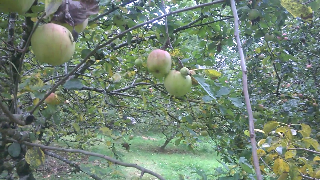

inference took: 4.415488004684448  seconds
num_detections: 100
Detection Classes:  [53 53 53 53 53 53 53 53 53 53 53 53 53 53 55 53 53 56 53 16 53 37 53 53
 37 53 53 56 53 56 53 56 53 56 56 56 53 56 53 53 53 56 53 56 56 56 56 56
 56 53 56 56 56 56 53 56 56 53 56 53 56 56 56 56 53 56 53 56 56 56 56 56
 56 56 56 53 56 56 56 56 53 56 56 56 53 53 53 56 53 56 53 56 56 56 56 53
 56 56 56 56]
Detection Scores:  [0.9486543  0.36964118 0.23162872 0.22308162 0.19798157 0.19271055
 0.13437158 0.12559202 0.11918971 0.11855003 0.11543727 0.10813445
 0.10616213 0.10538718 0.0977281  0.09762129 0.09584737 0.0925009
 0.09211206 0.08816451 0.08651966 0.08648583 0.08639628 0.08523253
 0.08368209 0.08155513 0.08137435 0.08126152 0.08096552 0.07818016
 0.07725859 0.07651231 0.07630458 0.07622981 0.07616314 0.07542837
 0.07515967 0.07393935 0.07013512 0.06993729 0.069534   0.06897652
 0.06857097 0.06788659 0.06781188 0.06776893 0.06733987 0.06654024
 0.06597689 0.06580704 0.06577411 0.06576103 0.06522864 0

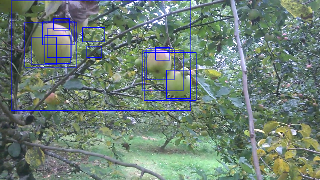

In [28]:

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(19)#3) #19

#Before processing
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # #OpenCV is BGR Blue Green Red
cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )
#Change back ? Why? Try BGR and RGB and see the effect on the detection rate 
# HINT 53 is an APPLE in COCO and 55 is an Orange
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # #OpenCV is BGR Blue Green Red

my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
output_dict = my_detector.run_inference_for_single_image(frame, show_stats = True)# False) # True)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = True, colour = 'Red')#False ) #True)
#After processing
#cv2_imshow(final_image)
cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


In [38]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import tensorflow_backend as ktf
from pathlib import Path

from os import listdir
from os.path import isfile, join


apple_type = ['ripe', 'not_ripe'] #TRY adding 'branches' ,'leaves'
#categories = [[1,0], [0,1]] # TRY increasing to 4 ie = [ [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]
categories  = [ [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1] ]
#not??
#categories  = [ 'ripe', 'not_ripe', 'branches', 'leaves' ]

# see here https://keras.io/getting-started/sequential-model-guide/
# and here not the utility to change labels in sample code
# https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py



def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[0])


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[1])

  # Add below for 4 categories
  
  for root, dirs, files in os.walk(images_path+'leaves/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'leaves/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[2])


  for root, dirs, files in os.walk(images_path+'branches/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'branches/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[3])
   

  return np.array(features), np.array(labels)



#preprocess_images(images_path):
#preprocess_images(base_dir + 'data/' + 'Ripe_not_ripe/')


features, labels = load_prepared_images(base_dir + 'Data/' )

train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # TRY Remove normalisation to see what happens

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=4, activation = 'softmax')) #units = 2 for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])


score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save(base_dir + 'apple_lenet_model.h5')





# of training images: 444
# of test images: 24
   Label  Count
0      0   1332
1      1    444
# of training images: 355
# of validation images: 89
(468, 32, 32, 3)
(468, 4)
Updated Image Shape: (32, 32, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_7 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_8 (Average (None, 6, 6, 16)          0         
_____________________________________________

In [0]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os

#class_model = load_model(base_dir + 'apple_lenet_model.h5')

#traffic_light_colors = ['ripe', 'not_ripe']

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class ObjectClassifier:

    def __init__(self,location_path = base_dir, model_name = 'apple_lenet_model.h5' ):       
  
            try:
              self.class_model = load_model(base_dir + 'apple_lenet_model.h5')
              
            except Exception as e:
                print(e)
                exit()

            self.traffic_light_colors = ['ripe', 'not_ripe', 'branches', 'leaves'] # ['ripe', 'not_ripe'] # or ['ripe', 'not_ripe', 'branches', 'leaves']

    def predict(self,image_name): #not used

        img = load_img(image_name, False, target_size=(32, 32))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = selfclass_model.predict_proba(x)

        return preds[0], prob[0]

    def predict_for_detected(self, image_name):
      
        resized_image = image_name.resize((32,32), resample=0)

        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def draw_positive_boxes(self,final_image,object_data, object_images, show_each_addition =  False , show_results = False):

      height, width ,_ = final_image.shape #  as per PIL
      print('final_image.shape : ', final_image.shape)


      for   i in  range(0, len(object_images ) ) :
        start = time.time()
        pred, prob = self.predict_for_detected( object_images[i]) 

        #plt.imshow(object_images[i])
        #plt.show()
        elapsed = time.time() - start
        #Next line will show when objects are Deemed Ripe or Not Ripe
        if show_results:
          print('Result: ', ':', self.traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')

        if pred == 0 :# or pred == 1 : 0 is Ripe, 1 is not_ripe, 2 is branches , 3 is leaves
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)

          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
          if show_each_addition  :
            cv2_imshow(final_image)
            

          #return final_image # <-------------wrong indentation caused return only if apple sucessfully calssified

      return final_image





In [43]:
#the complete pipeline


from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

# to test one one frame use this
#clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
#frame = clip1.get_frame(3)#3) #19

#Beware a sinlge frame colour scheme is different!
#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
my_classifier = ObjectClassifier(base_dir ,'apple_lenet_model.h5'  )


# pipeline


def pipeline(frame) :
  
  #Step 1: Run inference and get bounding box data
  output_dict = my_detector.run_inference_for_single_image(frame, show_stats = True) # True)
  
  #Step 2: Overlay the bounding boxes and generate cropped sub-images
  # I return final image here to allow for display you may not need to
  step_2_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = False ) #True)
  
  # Optional Display After Step 2:
  #cv2_imshow(step_2_image) #full size (Big)
  #cv2_imshow( cv2.resize(step_2_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #resized

  # Step 3: Run classifer on detected object
  step_3_image = my_classifier.draw_positive_boxes(step_2_image, object_data,object_images, show_results = True)
  #cv2_imshow( cv2.resize(step_3_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #fails here if no image or objects?
  
  return step_3_image
  #return step_2_image # use to make video of step 2 results

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,5)
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile(base_dir + 'output_clip_12.mp4', audio = False)



inference took: 4.943436145782471  seconds
num_detections: 100
Detection Classes:  [53 16 16 37 16 53 53 53 16 53 53 53 16 56 56 37 56 56 56 53 53 16 16 56
 56 56 16 56 56 53 16 56 56 53 53 16 16 16 53 53 34 16 56 53 56 16 16 53
 56 53 53 53 56 53 56 53 56 37 56 56 56 53 55 53 53 56 16 56 56 56 56 16
 53 53 56 56 16 53 53 56 56 53 53 16 56 53 16 56 56 53 53 56 16 53 16 16
 16 53 56 53]
Detection Scores:  [0.4729719  0.35329184 0.25767666 0.22500464 0.21511349 0.20591608
 0.18931365 0.17896089 0.16962692 0.16006461 0.14393875 0.13932362
 0.10430148 0.09702134 0.09506235 0.09236744 0.08825043 0.08793828
 0.08465391 0.08404952 0.08056563 0.07874864 0.07748961 0.07642645
 0.07446495 0.07360008 0.07324073 0.07224506 0.07196721 0.07098863
 0.07064372 0.06946552 0.06882912 0.06878757 0.06704357 0.06550157
 0.06492236 0.06477329 0.06390417 0.0627248  0.0624328  0.06239069
 0.06215122 0.06120777 0.06047922 0.05933064 0.05884665 0.05873597
 0.05829298 0.05791545 0.05734104 0.05630261 0.05622172 

  1%|          | 1/151 [00:00<00:29,  5.03it/s]

inference took: 0.1619870662689209  seconds
num_detections: 100
Detection Classes:  [37 53 37 53 16 11 16 53 37 53 16 53 11 56 56 56 53 53 16 16 16 16 16 56
 56 53 11 56 56 56 56 53 56 16 56 16 53 53 16 53 11 56 16 56 53 56 56 16
 53 16 53 64 10 53 55 56 53 56 56 11 56 56 16 16 53 11 56 56 56 53 16 56
 16 16 55 64 56 11 53 53 88 53 11 53 56 56 16 56 56 56 11 56 53  1 53 64
 56 35 16 64]
Detection Scores:  [0.31798044 0.22398576 0.16718096 0.14877596 0.1340363  0.12990287
 0.09404227 0.08952445 0.08922789 0.0848707  0.07478699 0.07358298
 0.0671815  0.06689972 0.06401137 0.06341234 0.06180343 0.06128356
 0.06044534 0.06033841 0.0586271  0.05817461 0.05747777 0.05713785
 0.05605906 0.05475217 0.05471307 0.05309516 0.05292073 0.05224541
 0.05209744 0.05107862 0.04977059 0.04925078 0.04884335 0.04848137
 0.04820386 0.04746592 0.04571572 0.04568595 0.04548669 0.04508221
 0.04493433 0.04382983 0.04370144 0.04356417 0.04324916 0.04181316
 0.04141387 0.04119742 0.04079425 0.03971624 0.03967991

  1%|▏         | 2/151 [00:00<00:32,  4.53it/s]

inference took: 0.17160534858703613  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 16 53 53 53 53 37 53 53 16 16 53 53 16 53 53 53 53 16 16 16
 37 16 53 53 53 34 56 53 53 16 53 53 16 56 53 56 53 16 16 53 53 38 53 56
 56 16 37 56 57 16 64 16 56 53 56 16 56 56 56 16 53 56 53 56 56 56 16 16
 53 57 53 57 53 56 53 56 16 53 53 56 16 56 56 53 16 53 53 53 16 53 55  1
 55 16 55 53]
Detection Scores:  [0.5201941  0.4320071  0.24386343 0.23037228 0.21344158 0.1782867
 0.17049754 0.16409099 0.15935561 0.13157707 0.12854263 0.10816324
 0.09892619 0.09329483 0.09273759 0.09139311 0.08462331 0.08311483
 0.07712817 0.07361376 0.07095772 0.07009163 0.06835386 0.06821436
 0.06648612 0.06603974 0.06299376 0.06195042 0.05793941 0.05790845
 0.05773592 0.0576427  0.05741969 0.05731273 0.0556865  0.05549067
 0.05533597 0.05501616 0.05426779 0.05208999 0.05130327 0.05060318
 0.04960611 0.04916412 0.0489417  0.04770651 0.04727286 0.04701006
 0.04674459 0.04665038 0.04590183 0.04584143 0.04476795

  2%|▏         | 3/151 [00:00<00:33,  4.39it/s]

inference took: 0.16958045959472656  seconds
num_detections: 100
Detection Classes:  [53 16 53 16 53 16 53 53 53 53 53 53 37 53 16 53 53 37 53 53 53 56 53 16
 53 53 53 53 56 16 16 16 53 53 56 16 53 53 16 56 53 56 53 53 16 56 53 53
 56 16 53 56 34 16 53 53 53 56 53 53 16 64 53 37 56 56 37 16 56 56 53 56
 53 16 56 56 53 53 53 53 64 56 53 57 57 53 16 16 56 56 56 53 53 56 53 53
 56 16 53 16]
Detection Scores:  [0.42254373 0.37215889 0.29832637 0.23458692 0.21310163 0.16882104
 0.16058788 0.15614787 0.15535441 0.12596405 0.12262008 0.12099856
 0.10999733 0.10271168 0.09586447 0.09170288 0.07587427 0.07376131
 0.07323861 0.07109505 0.07039022 0.07026953 0.06931552 0.06816712
 0.06802768 0.06748319 0.06747618 0.06738731 0.06667957 0.06610611
 0.06586447 0.06314313 0.06240806 0.06192634 0.06169745 0.06107727
 0.06068218 0.06042945 0.05924168 0.05838156 0.05665368 0.05646738
 0.05633447 0.05490574 0.05484101 0.05420569 0.05071127 0.04967612
 0.049182   0.04868233 0.04755747 0.04713377 0.0468048

  3%|▎         | 4/151 [00:00<00:33,  4.35it/s]

inference took: 0.16538023948669434  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 53 53 37 53 16 53 53 53 53 16 53 53 53 16 16 16 16 37 53 53
 16 53 16 53 16 16 53 55 53 56 53 53 53 53 53 53 16 53 53 53 34 56 55 56
 16 16 16 56 53 64 53 16 56 53 55 16 53 56 53 55 37 56 52 16 56 55 16 16
 16 53 53 16 53 16 16 53 16 53 53 64 16 16 56 16 16 16 64 56 53 64 53 64
 53 56 16 56]
Detection Scores:  [0.5385145  0.44170552 0.3095957  0.22265118 0.21762028 0.17754796
 0.1637758  0.14215818 0.1381334  0.13578677 0.12445357 0.11253789
 0.09916493 0.09233308 0.09112737 0.09059221 0.09019652 0.08241355
 0.07940802 0.07518008 0.07128069 0.06952775 0.06760553 0.06720337
 0.06584048 0.06403741 0.06217244 0.06135294 0.06085646 0.06028309
 0.05834952 0.05109185 0.04992104 0.04965398 0.04956234 0.04929292
 0.04886642 0.04875997 0.04874262 0.04849783 0.04828835 0.04780892
 0.0477652  0.04602304 0.04578489 0.04567564 0.04536977 0.04450789
 0.04378024 0.04242632 0.04234362 0.04233935 0.0414068

  3%|▎         | 5/151 [00:01<00:33,  4.35it/s]

inference took: 0.158888578414917  seconds
num_detections: 100
Detection Classes:  [16 53 53 37 53 53 53 53 16 53 53 16 53 16 53 53 53 16 53 16 53 16 16 16
 53 16 16 53 53 16 64 16 53 53 53 53 53 55 56 53 53 56 53 53 53 53 53 53
 53 53 53 53 55 53 53 57 55 53 16 53 53 15 16 53 56 56 53 56 16 16 37 55
 56 52 55 56 64 53  1 15 53 55 16 16 55 56 16 53 53 56 16 15 16 64 53 28
 53 15 53 56]
Detection Scores:  [0.48610336 0.39869505 0.29110122 0.24889818 0.20085278 0.1502274
 0.14004758 0.11945829 0.11428165 0.1040611  0.10251677 0.10123694
 0.0950096  0.09354088 0.08960053 0.08493027 0.08053064 0.07911772
 0.07889187 0.0779697  0.07659137 0.07500309 0.07000884 0.06472957
 0.06374025 0.06110474 0.06038815 0.06010944 0.05698538 0.0569202
 0.05614397 0.05457839 0.05419412 0.05325085 0.05258459 0.05231252
 0.05207244 0.05198821 0.0517295  0.04962271 0.04917696 0.04887432
 0.04847646 0.04812348 0.04768622 0.04616269 0.04607201 0.04603934
 0.04465431 0.04446435 0.04387659 0.04216623 0.04148456 0.

  4%|▍         | 6/151 [00:01<00:35,  4.13it/s]

inference took: 0.1671614646911621  seconds
num_detections: 100
Detection Classes:  [16 53 53 16 53 53 16 53 53 16 53 53 53 16 53 53 53 53 53 53 53 53 16 16
 16 53 16 53 16 55 53 16 56 53 16 53 16 53 55 56 37 16 53 53 53 56 53 55
 56 16 16 53 56 53 53 56 16 56 55 64 16 53 16 55 56 56 53 53 16 16 16 53
 56 16 56 56 53 56 64 53 57 56 53 56 55 16 53 64 56 16 64 56 37 53 16 56
 16 53 16 53]
Detection Scores:  [0.58636284 0.48379025 0.25457108 0.22151992 0.2202028  0.18782377
 0.18550181 0.17313978 0.15800181 0.1553154  0.1402891  0.14021397
 0.12769926 0.12299782 0.12004122 0.11231849 0.10521108 0.09481183
 0.09056231 0.08371437 0.08345553 0.08172128 0.07965368 0.07929245
 0.07850483 0.07622722 0.07567957 0.07318813 0.07079026 0.06938785
 0.06774271 0.06601283 0.06521359 0.06188619 0.06184188 0.0617241
 0.06165171 0.06102467 0.06010985 0.05970457 0.05912092 0.05852264
 0.05795431 0.05581307 0.0552133  0.05400011 0.05280602 0.05210698
 0.05120191 0.05117247 0.05083704 0.05082417 0.05061695 

  5%|▍         | 7/151 [00:01<00:35,  4.08it/s]

inference took: 0.16281414031982422  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 16 53 53 16 16 53 53 37 16 16 53 53 53 16 53 53 16 16 16 16
 16 16 53 16 16 53 16 16 53 53 16 16 56 16 16 56 16 56 16 56 53 16 16 16
 16 16 56 56 16 16 56 16 55 55 56 53 56 53 56 53 16 16 56 56 16 16 16 56
 53 16 56 16 16 53 16 37 53 16 53 16 16 16 16 53 16 53 53 16 56 64 34 16
 16 16 56 16]
Detection Scores:  [0.6099386  0.34837145 0.3434121  0.3143748  0.2139402  0.20243862
 0.16926026 0.16882834 0.13469765 0.13150838 0.12863466 0.12630025
 0.11584178 0.10894534 0.10802034 0.10731637 0.10260949 0.0943785
 0.09407672 0.08628932 0.08474755 0.08384424 0.07754087 0.07398087
 0.07022691 0.06979415 0.06959069 0.0688875  0.06798333 0.06713751
 0.06612217 0.06589699 0.06567582 0.06408045 0.06298447 0.05996042
 0.05830878 0.05783927 0.05737194 0.05732095 0.05432144 0.05342621
 0.05304033 0.05209112 0.05125436 0.05064625 0.0504216  0.0502086
 0.04989293 0.0490689  0.04694459 0.04688081 0.04649669 

  5%|▌         | 8/151 [00:01<00:34,  4.13it/s]

inference took: 0.1641247272491455  seconds
num_detections: 100
Detection Classes:  [16 53 53 16 53 37 16 53 53 53 53 16 16 16 53 16 16 53 53 53 53 53 56 16
 56 16 56 56 16 56 53 16 16 56 56 16 56 56 16 53 53 53 53 53 53 16 56 56
 16 56 16 53 56 56 53 53 56 53 53 56 16 56 16 53 56 53 56 16 53 56 64 53
 56 16 53 56 16 53 53 16 56 53 56 53 56 53 53 53 16 53 56 53 57 53 16 16
 16 55 53 53]
Detection Scores:  [0.59470236 0.37295222 0.33460492 0.3129135  0.23011908 0.22812599
 0.21848625 0.20083582 0.17139015 0.17022905 0.16081601 0.1565271
 0.13485345 0.12566641 0.12155387 0.09903085 0.09679005 0.0961009
 0.09256527 0.09114879 0.08965421 0.08646014 0.08617276 0.08462217
 0.08340678 0.08311275 0.08205986 0.07898054 0.07870755 0.0783914
 0.07736447 0.07733878 0.07561535 0.07528204 0.07417318 0.07177415
 0.07011458 0.06895798 0.06671232 0.06603119 0.06554177 0.06544238
 0.06497708 0.06490809 0.06356457 0.0634582  0.06145376 0.06036133
 0.06017682 0.05974439 0.05879614 0.05796587 0.05782244 0.

  6%|▌         | 9/151 [00:02<00:34,  4.16it/s]

inference took: 0.1685171127319336  seconds
num_detections: 100
Detection Classes:  [16 53 53 16 53 16 37 16 53 53 16 53 16 53 16 53 16 53 53 16 53 16 16 16
 16 53 16 16 53 16 53 16 16 53 53 53 53 16 56 56 16 53 53 56 16 53 53 16
 53 16 56 53 53 56 16 56 16 16 37 16 55 53 16 16 53 53 53 16 16 56 53 16
 53 53 53 16 16 53 53 56 53 16 53 53 53 37 16 38 16 53 16 16 56 16 64 56
 16 16 53 16]
Detection Scores:  [0.46052065 0.4200188  0.40086356 0.3825661  0.29721585 0.2888662
 0.24698234 0.23549059 0.19418159 0.18368983 0.14395005 0.13474938
 0.13425562 0.12287676 0.0979951  0.09590197 0.09375146 0.08961076
 0.08957297 0.08710006 0.0844368  0.0819256  0.08191693 0.08164841
 0.08069581 0.08036977 0.07996896 0.079537   0.07574254 0.07219809
 0.07027298 0.06993106 0.06842667 0.06651807 0.06382397 0.06376407
 0.06209806 0.06158182 0.05976954 0.05747738 0.0557172  0.05516279
 0.05492833 0.05492282 0.05464244 0.05368033 0.05312037 0.05161926
 0.05137211 0.05107096 0.05072421 0.05013916 0.04969984 

  7%|▋         | 10/151 [00:02<00:33,  4.21it/s]

inference took: 0.16874170303344727  seconds
num_detections: 100
Detection Classes:  [16 16 16 53 53 53 16 37 53 16 53 16 16 16 53 53 16 16 53 53 16 53 16 53
 16 16 16 53 53 56 16 53 16 16 16 56 53 16 53 16 56 56 16 16 16 16 16 56
 53 56 53 56 16 53 53 53 16 53 56 16 16 56 16 56 16 56 16 16 56 56 53 64
 53 56 16 16 53 16 53 16 16 16 56 16 56 16 53 53 16 56 53 16 16 56 56 56
 53 53 53 16]
Detection Scores:  [0.45188364 0.4366809  0.41333997 0.35218102 0.23499346 0.2300047
 0.19838023 0.18770665 0.17864096 0.14019668 0.13806674 0.13001281
 0.12123775 0.10407883 0.09098873 0.09080857 0.08662668 0.08267489
 0.08196509 0.08146477 0.07970151 0.07809526 0.07685733 0.07641599
 0.07473218 0.07434386 0.07046685 0.06923699 0.06641173 0.06523874
 0.06027853 0.05983999 0.05982006 0.05923897 0.0582937  0.05727735
 0.05689555 0.05545226 0.05425641 0.05417067 0.05348727 0.05336913
 0.05316001 0.0526953  0.0516603  0.05126011 0.05103192 0.05020711
 0.04949033 0.04924789 0.04924041 0.0491648  0.04855895

  7%|▋         | 11/151 [00:02<00:32,  4.29it/s]

inference took: 0.16101408004760742  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 16 53 16 53 16 16 16 16 16 37 53 53 16 16 16 53 16 16 56 16
 16 56 53 53 16 16 16 53 16 16 16 53 16 16 56 56 53 56 16 16 53 53 16 53
 16 53 56 53 16 16 56 56 16 53 56 16 37 16 16 53 53 56 56 53 56 56 16 16
 16 16 16 56 16 52 56 52 56 56 16 16 16 64 16 16 56 16 56 56 56 16 53 56
 56 16 53 16]
Detection Scores:  [0.5136603  0.27629477 0.18968427 0.17167804 0.15598965 0.1521441
 0.14731276 0.14365324 0.13387847 0.1329982  0.11930209 0.11018354
 0.10615066 0.09844124 0.09045863 0.08124185 0.07927847 0.07423404
 0.06584111 0.06465298 0.06424567 0.06347251 0.06318069 0.06317574
 0.06227452 0.06055653 0.06024855 0.05997533 0.05963066 0.05786499
 0.05771539 0.05748379 0.05629578 0.05584639 0.05476055 0.05422553
 0.05117133 0.05115846 0.05099174 0.05079138 0.05049148 0.04925242
 0.04841554 0.04815409 0.04750994 0.04696214 0.04696101 0.04690325
 0.04626325 0.0462206  0.04606313 0.045739   0.04565823

  8%|▊         | 12/151 [00:02<00:31,  4.36it/s]

inference took: 0.1640307903289795  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 53 16 53 16 16 16 16 37 53 16 53 16 16 53 16 56 16 16 16 16
 56 16 16 53 16 16 56 16 53 53 16 16 53 16 64 16 56 56 53 56 53 16 53 53
 16 16 56 56 37 53 56 53 53 16 16 56 56 53 53 16 56 16 56 16 16 15 53 56
 56 16 16 16 16 15 16 15 16 15 53 16 56 16 16 53 56 56 16 56 56 16 56 56
 53 16 56 15]
Detection Scores:  [0.5816752  0.3499638  0.3213889  0.248725   0.20615113 0.15675327
 0.13591862 0.13401115 0.12457466 0.12156537 0.10284546 0.10114008
 0.100366   0.09276015 0.08484432 0.08430666 0.08333579 0.08169457
 0.07840115 0.07412007 0.07231712 0.07082307 0.06898576 0.06756425
 0.06700039 0.066753   0.06421223 0.06336465 0.06257913 0.06204703
 0.06048983 0.05931526 0.0583185  0.05401555 0.05326012 0.05200717
 0.0512754  0.05111441 0.05042714 0.04929295 0.04925492 0.04923111
 0.04791999 0.04758829 0.04754221 0.04710475 0.04685962 0.04645655
 0.04595149 0.04476997 0.04457414 0.04432058 0.04377824

  9%|▊         | 13/151 [00:03<00:31,  4.38it/s]

inference took: 0.1660149097442627  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 16 53 53 16 16 16 53 37 16 53 16 16 16 53 53 16 16 53 53 16
 16 16 53 53 53 16 53 53 16 16 16 16 53 16 56 56 53 16 16 53 16 16 37 16
 16 16 16 64 16 37 53 53 53 16 53 16 56 53 16 53 53 16 16 16 16 56 16 16
 16 53 16 53 16 16 56 16 16 16 16 16 16 53 16 53 16 56 16 53 16 16 53 52
 53 16 16 16]
Detection Scores:  [0.43085518 0.40857273 0.2927898  0.2722025  0.21678194 0.19857568
 0.17947617 0.1606569  0.13571247 0.11008263 0.10523418 0.10450286
 0.10044888 0.0907799  0.08852616 0.08791438 0.08542213 0.08503073
 0.08188871 0.0798949  0.07776985 0.07653746 0.07587725 0.07343209
 0.07201496 0.06979951 0.06587306 0.06538525 0.06333026 0.0632529
 0.06307581 0.06306297 0.06256363 0.05939901 0.05927151 0.05888635
 0.05756545 0.05727509 0.05598122 0.05539632 0.0549807  0.05381536
 0.05368596 0.05347669 0.05345094 0.05255356 0.05178273 0.05168524
 0.05096009 0.0504055  0.04955712 0.0494419  0.04907945 

  9%|▉         | 14/151 [00:03<00:30,  4.42it/s]

inference took: 0.1670377254486084  seconds
num_detections: 100
Detection Classes:  [16 16 16 53 53 53 16 53 16 16 16 53 53 16 53 16 16 16 16 16 53 16 53 53
 53 37 16 16 16 53 16 16 53 16 16 16 16 53 64 53 53 16 16 56 64 16 53 16
 64 53 56 16 16 16 16 16 16 56 53 53 16 56 53 53 11 64 16 16 16 56 16 37
 16 53 16 16 16 15 16 53 16 53 16 53 16 56 53 64 16 15 37 53 53 16 16 16
 53 56 56 16]
Detection Scores:  [0.45358455 0.22595859 0.21781424 0.21196246 0.20322949 0.17986521
 0.12133777 0.11547107 0.10580841 0.1015448  0.10005063 0.0957084
 0.08548889 0.08548555 0.07979694 0.07797903 0.07390854 0.07356411
 0.0718275  0.06592283 0.0648174  0.06394807 0.05654177 0.055123
 0.0549784  0.05266675 0.05248451 0.05206069 0.05187255 0.05186391
 0.05164418 0.05113056 0.05104917 0.04887629 0.04853356 0.04767224
 0.04742759 0.04639429 0.04604641 0.04604188 0.04523626 0.04515406
 0.04487193 0.04484943 0.0442073  0.04416645 0.04416323 0.04387417
 0.04358748 0.04224575 0.04211909 0.04197904 0.04167855 0.

 10%|▉         | 15/151 [00:03<00:30,  4.46it/s]

inference took: 0.1590745449066162  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 16 53 16 16 37 16 53 53 53 16 56 16 53 16 16 56 56 53 53 53
 53 53 53 53 53 53 53 53 56 56 56 16 16 53 53 56 16  3 53 53 56 16 56 56
 53 52 37 53 16 28 16 64 16 56 16 56 16 16 56 52 53 11 16 53 56 53 16 53
 16 56 64 16 56 56 64 64 53 56  1 64 16 56 52 16 57 53 53 64 53 64 64 16
 56 56 64 16]
Detection Scores:  [0.5091099  0.39316243 0.22729641 0.18681976 0.13735434 0.12486124
 0.11625823 0.10080814 0.09808725 0.09612891 0.09533581 0.09400186
 0.08808643 0.07432169 0.07400072 0.07352334 0.07333738 0.07304332
 0.07163104 0.07138687 0.07035547 0.0694122  0.06672487 0.06636962
 0.0651291  0.06255856 0.05846748 0.05751249 0.05667976 0.05634084
 0.05461991 0.05385086 0.05284882 0.05257887 0.05119485 0.05082163
 0.05010429 0.0493736  0.04935628 0.04800466 0.04764426 0.04694426
 0.04672682 0.04564285 0.04490539 0.04455757 0.04435459 0.04419664
 0.04404205 0.04381967 0.04363337 0.04298487 0.04276219

 11%|█         | 16/151 [00:03<00:30,  4.49it/s]

inference took: 0.15857815742492676  seconds
num_detections: 100
Detection Classes:  [16 53 16 16 53 53 16 16 53 53 53 37 16 16 53 53 53 53 16 53 16 16 56 53
 56 53 16 16 53 56 16 53 16 16 53 37 56 53 56 53 64 53 56 53 53 56 64 53
 53 16 64 16 64 56 16 16 16 34 16 53 56 38 16 56 16 56 56 64 53 64 64 56
 56 64 53 64 16 56 64 16 56 16 64 53 53 64 64 56 16 16 16 53 53 16 53 16
 56 64 16 53]
Detection Scores:  [0.7184452  0.38181844 0.24496183 0.24490798 0.22656274 0.16323811
 0.14802879 0.11713424 0.11325577 0.11185867 0.11143577 0.1053893
 0.09781784 0.09714627 0.09328961 0.07927197 0.0790545  0.07635459
 0.07400885 0.07310104 0.07301322 0.06391394 0.06352043 0.0613547
 0.06063211 0.05852205 0.05803663 0.05437323 0.05371583 0.05317006
 0.05268225 0.05255798 0.0521726  0.05175453 0.05135161 0.0511249
 0.04959536 0.04908794 0.0465827  0.04647675 0.04606867 0.04553008
 0.04550132 0.04468209 0.04427779 0.0440501  0.04401955 0.04401231
 0.04391319 0.04355261 0.04333273 0.04299101 0.04282546 0

 11%|█▏        | 17/151 [00:03<00:31,  4.27it/s]

inference took: 0.1946568489074707  seconds
num_detections: 100
Detection Classes:  [16 16 53 53 53 53 16 16 56 53 16 56 53 56 56 53 16 56 56 16 56 53 53 53
 53 56 53 37 53 56 53 16 56 16 56 56 56 56 56 16 16 56 53 53 16 56 56 16
 37 56 16 56 16 53 53 16 56 53 53 56 16 16 16 56 55 56 15 53 16 56 28 53
 56 56 53 56 56 16 53 56 56 53 64 34 16 16 56 56 56 16 56 56 55 53 56 53
 56 16 53 56]
Detection Scores:  [0.5652171  0.52512497 0.3340329  0.28048435 0.1715531  0.16865894
 0.11361414 0.10837165 0.10459203 0.10368234 0.10160086 0.10139585
 0.09389827 0.09040773 0.08945748 0.08437866 0.08425483 0.07831022
 0.07807395 0.07633424 0.0760166  0.07571858 0.07546622 0.07294887
 0.07207665 0.07179067 0.07001653 0.06991112 0.06715041 0.06680092
 0.06523776 0.0644581  0.06425485 0.06328902 0.06305033 0.06190246
 0.06154627 0.0613375  0.06092888 0.06035334 0.06019196 0.06011018
 0.0600988  0.05805203 0.0570308  0.05598605 0.05551115 0.05549875
 0.05463907 0.05443296 0.0539763  0.05308264 0.05107322

 12%|█▏        | 18/151 [00:04<00:30,  4.34it/s]

inference took: 0.1601090431213379  seconds
num_detections: 100
Detection Classes:  [16 53 53 16 16 56 16 56 53 53 53 56 56 56 56 16 53 56 56 53 56 56 16 56
 56 56 16 16 53 56 56 53 16 56 56 16 56 34 53 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 53 52 16 56 53 56 53 56 16 53 56 56 53 56 56 53 56 56
 37 64 53 56 64 56 53 16 56 16 16 56 52 56 56 53 56 56 52 56 53 56 53 53
 53 16 64 56]
Detection Scores:  [0.4597495  0.39180243 0.19552651 0.15670818 0.15212649 0.13175371
 0.12669721 0.12343249 0.1217705  0.11198965 0.10509768 0.10495034
 0.10423383 0.10422382 0.09868449 0.09418818 0.0921672  0.09101626
 0.08960995 0.08959517 0.08694011 0.08409581 0.08406338 0.08350492
 0.08265957 0.08264226 0.08053425 0.08011988 0.07771525 0.07766387
 0.07726446 0.07661292 0.07440904 0.07253963 0.07224613 0.07143643
 0.07138455 0.0710465  0.07070714 0.06855929 0.06835857 0.06727687
 0.06710652 0.06382799 0.06307617 0.06293967 0.06272215 0.06211841
 0.06203914 0.06197679 0.0611321  0.06043243 0.05958208

 13%|█▎        | 19/151 [00:04<00:29,  4.42it/s]

inference took: 0.16756010055541992  seconds
num_detections: 100
Detection Classes:  [16 53 16 16 53 53 16 53 53 56 16 56 56 16 56 56 16 56 56 56 56 53 53 56
 56 56 53 16 56 56 56 53 56 16 56 56 56 37 53 16 53 34 16 56 56 56 53 53
 56 16 16 53 56 56 56 56 56 53 16 16 56 56 56 53 56 56 56 56 56 56 56 56
 16 56 56 56 52 56 56 16 16 56 56 56 56 56 56 53 56 16 56 56 53 53 16 56
 56 53 56 56]
Detection Scores:  [0.4053347  0.3753989  0.31387278 0.19595832 0.14598733 0.10838252
 0.10772151 0.09086433 0.08891439 0.086909   0.0868479  0.08632863
 0.08576974 0.08145371 0.08102402 0.07963541 0.07901657 0.07855102
 0.07774958 0.07519189 0.0748381  0.07341087 0.07086831 0.07044539
 0.0685595  0.0681535  0.06802747 0.06652012 0.06646445 0.06636876
 0.06626251 0.0654687  0.06516069 0.06384128 0.06343251 0.0632681
 0.0631156  0.06199241 0.06136554 0.06132105 0.06115595 0.06098437
 0.06068504 0.06059009 0.06034389 0.05824867 0.05726627 0.05718935
 0.05624115 0.0561589  0.05555671 0.05464584 0.05413574

 13%|█▎        | 20/151 [00:04<00:29,  4.40it/s]

inference took: 0.1629343032836914  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 53 53 16 16 53 53 16 53 16 34 53 56 53 16 56 16 56 56 53 53
 53 16 56 56 16 37 52 53 53 56 56 56 16 56 56 56 56 56 56 53 16 53 56 16
 56 56 56 53 16 56 56 53  1 56 53 52 56 53 53 56 56 56 53 53 53 56 16 56
 53 56 56 53 64 16 56 56 53 56 56 56 53 53 56 16 56 16 56 52 56 56 53 38
 53 56 56 56]
Detection Scores:  [0.54590166 0.40928218 0.21235445 0.18971854 0.1617535  0.1614886
 0.14367378 0.12771222 0.11725524 0.09918469 0.09181616 0.08683911
 0.08514398 0.083451   0.08274421 0.080345   0.0771797  0.07503659
 0.07231101 0.07183266 0.07115105 0.07064649 0.07046348 0.07044488
 0.06905711 0.06836703 0.06824067 0.06606245 0.06425399 0.06348294
 0.06266022 0.06201887 0.0615527  0.06138694 0.06062511 0.06047386
 0.06023926 0.05999404 0.05950108 0.05945033 0.05753839 0.05637032
 0.05622068 0.05599511 0.05317095 0.05289066 0.05247855 0.05247018
 0.05162978 0.05157235 0.05140609 0.05125782 0.05098116 

 14%|█▍        | 21/151 [00:04<00:29,  4.37it/s]

inference took: 0.1731579303741455  seconds
num_detections: 100
Detection Classes:  [16 53 16 16 16 53 53 53 53 16 53 53 16 53 16 16 53 53 16 53 16 16 56 53
 16 56 53 56 16 52 56 56 56 11 16 56 56 53 56 52 56 53 53 16 16 16 56 56
 56 56 53 16 52 56 56 16 53 53 16 56 53 56 53 56 53 56 56 56 56 16 16 53
 56 56 56 56 53 56 56 16 56 56 53 52 53 53 16 56 56 16 56 56 56 16 53 16
 53 20 56 56]
Detection Scores:  [0.64082444 0.4004648  0.26821956 0.17232695 0.15472701 0.14460406
 0.12341756 0.12226522 0.12198192 0.09586245 0.08742732 0.08331618
 0.08319658 0.0809395  0.07918096 0.07903484 0.07272887 0.07091397
 0.06886104 0.06786892 0.0665364  0.06334567 0.06330955 0.06272087
 0.06257635 0.06213906 0.06136221 0.05925068 0.05923185 0.05890417
 0.05629355 0.05539998 0.05525389 0.05501258 0.05447787 0.0520176
 0.05141407 0.04996786 0.0498879  0.0487459  0.04802233 0.04778865
 0.04748201 0.04734594 0.04715127 0.0468027  0.04623488 0.04615754
 0.04602551 0.0455215  0.0455201  0.04521647 0.04494229 

 15%|█▍        | 22/151 [00:05<00:29,  4.36it/s]

inference took: 0.17054986953735352  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 16 53 53 53 53 56 16 53 56 56 53 16 53 56 16 53 16 53 56 56
 53 53 56 53 16 53 52 53 53 56 56 53 56 56 16 53 56 52 52 56 56 53 56 11
 56 56 56 16 16 56 53 16 56 56 56 56 56 16 56 53 56 56 56 56 56 56 53 56
 56 56 56 16 53 56 56 56 53 53 53 56 53 16 56 56 53 53 56 56 53 56 56 20
 56 56 53 16]
Detection Scores:  [0.4034865  0.35976055 0.17823887 0.16895407 0.14213982 0.13495049
 0.11662337 0.11217791 0.10785228 0.10183617 0.10092008 0.09798941
 0.09238204 0.09134609 0.09082097 0.09036845 0.08216566 0.08073729
 0.07810831 0.07802561 0.07783464 0.07488909 0.07304692 0.07144275
 0.07097811 0.06933704 0.06725457 0.06502551 0.06445006 0.06436452
 0.06408489 0.06402248 0.06373945 0.06307906 0.0616996  0.05913877
 0.05880043 0.05709434 0.05708149 0.05635729 0.05544037 0.05483064
 0.0544571  0.0539813  0.05381915 0.05377209 0.0531204  0.05159155
 0.05129281 0.05075493 0.05037448 0.04958758 0.0495831

 15%|█▌        | 23/151 [00:05<00:30,  4.24it/s]

inference took: 0.17308902740478516  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 16 53 53 53 52 16 16 56 53 56 56 56 16 16 53
 53 53 16 56 52 56 52 56 53 56 53 52 16 56 56 11 53 56 53 56 56 56 56 16
 52 56 16 53 16 56 56 56 16 16 52 53 53 56 56 56 56 56 35 64 52 56 56 56
 56 53 56 53 53 56 53 56 53 56 53 53 56 53 53 56 56 56 64 56 56 56 53 16
 56 53 56 64]
Detection Scores:  [0.345047   0.32469827 0.22462198 0.17150709 0.1448558  0.13797128
 0.12518275 0.10682318 0.10681078 0.09994954 0.0993191  0.08948874
 0.08011335 0.07493159 0.07379484 0.07373568 0.07192567 0.07115161
 0.06603733 0.06581533 0.0655849  0.06502774 0.06478524 0.06359053
 0.06230617 0.06157669 0.06149074 0.05943057 0.05935633 0.05914348
 0.05899101 0.05686435 0.05655035 0.05637282 0.05618253 0.05594423
 0.05547559 0.05517966 0.05348146 0.05271724 0.05228248 0.05096972
 0.05084965 0.04893368 0.04875773 0.04815912 0.04797566 0.04772919
 0.04753712 0.0466502  0.04648867 0.04627061 0.0452192

 16%|█▌        | 24/151 [00:05<00:30,  4.21it/s]

inference took: 0.16793179512023926  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 53 53 53 53 16 16 53 16 53 53 56 53 53 56 53 56 56 56 56 56
 53 53 56 56 53 11 53 56 53 56 53 16 56 16 56 53 56 56 56 56 56 53 16 53
 53 53 53 53 56 56 53 56 56 53 56 56 53 53 53 16 16 16 56 56 53 64 53 56
 56 56 56 56 53 56 56 56 16 56 57 53 16 56 53 53 56 56 16 56 56 56 16 53
 56 56 56 16]
Detection Scores:  [0.38786972 0.38029295 0.21873632 0.20209283 0.17623982 0.1678155
 0.14586926 0.1272479  0.12581363 0.1216746  0.11829337 0.10326642
 0.09741038 0.09694281 0.0926908  0.0887481  0.08666191 0.08404282
 0.08377317 0.08034614 0.07823485 0.07654607 0.07551834 0.07477641
 0.07346949 0.07052705 0.07049483 0.06992957 0.06990033 0.06937736
 0.06922156 0.06857166 0.06775388 0.06746173 0.06454352 0.0640898
 0.06193137 0.0601497  0.05874556 0.05868825 0.05795625 0.05685064
 0.05668035 0.05579549 0.05545425 0.05538931 0.05459496 0.05433914
 0.05306149 0.05228156 0.05061412 0.0501399  0.04993418 

 17%|█▋        | 25/151 [00:05<00:30,  4.09it/s]

inference took: 0.17044568061828613  seconds
num_detections: 100
Detection Classes:  [53 53 16 53 37 53 53 53 53 53 53 56 53 56 56 56 53 53 56 56 53 53 53 53
 53 53 56 56 53 56 56 56 56 56 56 56 56 56 56 16 53 56 56 56 56 56 53 56
 56 53 53 16 56 16 56 56 56 53 56 56 56 56 56 52 56 53 53 56 53 53 56 53
 56 56 16 56 56 53 56 56 56 56 53 53 56 16 56 53 52 56 16 56 56 56 56 11
 16 53 57 56]
Detection Scores:  [0.48832324 0.48097166 0.29468644 0.23135424 0.18180564 0.16948843
 0.13821173 0.13782004 0.12447259 0.11418894 0.11024415 0.10617566
 0.10525054 0.10249937 0.09694982 0.09372875 0.09138152 0.09049872
 0.08948612 0.08839047 0.08816338 0.08775461 0.08459562 0.0835093
 0.08258107 0.08211863 0.08103597 0.08095309 0.07930285 0.0786241
 0.07847419 0.07838553 0.07708934 0.07386419 0.0737448  0.07278466
 0.07248801 0.0722585  0.07206798 0.07079235 0.070272   0.069368
 0.06892255 0.06846753 0.06659532 0.06576076 0.06461713 0.0640848
 0.06379396 0.06302431 0.06280947 0.06241295 0.06198993 0.0

 17%|█▋        | 26/151 [00:06<00:30,  4.06it/s]

inference took: 0.1647028923034668  seconds
num_detections: 100
Detection Classes:  [53 16 53 16 37 53 53 53 16 53 16 53 16 53 53 53 53 56 56 53 56 56 52 53
 53 56 56 53 53 16 56 56 56 53 56 56 56 56 52 56 56 53 53 56 56 56 53 56
 56 56 56 56 56 56 53 56 56 56 56 56 52 53 52 16 53 16 56 56 53 56 53 56
 56 56 56 56 53 56 56 53 56 53 52 56 56 52 53 64 16 56 53 56 16 53 16 53
 53 56 56 56]
Detection Scores:  [0.50233954 0.4143226  0.23134908 0.22983867 0.21804678 0.2146169
 0.17264521 0.1645053  0.15057173 0.13850707 0.1370872  0.12538937
 0.11353219 0.11343363 0.1132597  0.1102314  0.10958323 0.10700956
 0.10099629 0.09746295 0.0928703  0.08893672 0.08710876 0.08621868
 0.0854362  0.08539957 0.08405969 0.08281973 0.08126467 0.07718253
 0.07621738 0.07540008 0.07340044 0.07331768 0.07325119 0.07292551
 0.07284135 0.07134286 0.07070467 0.07061478 0.07012349 0.06996831
 0.06969371 0.0689542  0.06864667 0.06782842 0.06775045 0.06774279
 0.06773308 0.06768399 0.06672201 0.06671372 0.06667322 

 18%|█▊        | 27/151 [00:06<00:29,  4.19it/s]

inference took: 0.16072916984558105  seconds
num_detections: 100
Detection Classes:  [53 16 16 16 53 53 16 16 53 56 56 56 56 16 16 56 16 16 56 56 56 56 56 37
 56 56 56 56 56 56 53 56 56 16 56 56 56 16 56 56 56 16 56 56 53 16 56 56
 56 56 53 56 53 56 53 56 56 56 53 56 56 53 56 53 53 56 56 16 16 56 56 56
 52 56 56 56 56 56 56 56 53 16 16 56 56 56 56 52 56 52 56 16 16 52 56 56
 53 53 16 16]
Detection Scores:  [0.4158506  0.3790622  0.1992543  0.196385   0.18879008 0.15529901
 0.13162786 0.12469    0.11366802 0.10926288 0.10481402 0.10207453
 0.10001907 0.09928292 0.0969193  0.0961242  0.0958662  0.09513384
 0.08964306 0.08923301 0.08106419 0.07937214 0.07914701 0.07913515
 0.07733268 0.07726002 0.07695299 0.076033   0.07569233 0.07468677
 0.0746246  0.07460183 0.07414246 0.07341823 0.07322016 0.07236925
 0.07068267 0.0705108  0.07011342 0.07010627 0.06969142 0.06894994
 0.06879514 0.06764641 0.06721374 0.06685755 0.06645152 0.06626374
 0.06542468 0.06464124 0.06432736 0.06354192 0.0633390

 19%|█▊        | 28/151 [00:06<00:29,  4.17it/s]

inference took: 0.15982890129089355  seconds
num_detections: 100
Detection Classes:  [53 53 16 53 53 16 53 53 53 53 53 53 53 53 16 53 56 53 56 16 37 53 53 56
 53 53 53 53 56 56 56 56 56 56 53 53 16 53 56 53 16 53 53 56 56 56 56 56
 56 53 16 56 56 56 53 53 56 56 56 16 16 56 53 53 56 56 53 56 56 56 56 56
 56 56 56 56 56 53 56 16 16 16 16 56 56 56 56 37 56 56 56 56 56 53 15 53
 53 53 53 16]
Detection Scores:  [0.43565094 0.3171516  0.20483807 0.18230581 0.16667631 0.16294742
 0.12273824 0.11450008 0.10253823 0.1013253  0.09686363 0.09670272
 0.09485349 0.09237969 0.09091848 0.08139744 0.07956439 0.07455498
 0.07378453 0.07211646 0.06878835 0.0684723  0.06779945 0.06339449
 0.06303746 0.06301743 0.06242275 0.06224629 0.06171325 0.06109649
 0.05954355 0.05932054 0.05884755 0.05664837 0.05592078 0.05567688
 0.05561772 0.05243981 0.05116206 0.05045897 0.0495407  0.04863194
 0.04841498 0.0481883  0.04816699 0.04780421 0.04777646 0.04765776
 0.04666859 0.04636148 0.04631677 0.04556721 0.0455574

 19%|█▉        | 29/151 [00:06<00:29,  4.07it/s]

inference took: 0.17371058464050293  seconds
num_detections: 100
Detection Classes:  [53 53 53 53 53 16 16 53 53 53 37 53 53 37 53 53 53 56 53 53 53 53 56 53
 53 16 16 53 16 56 53 53 56 53 16 53 53 56 53 56 16 37 55 56 53 56 56 53
 56 56 56 53 56 53 16 56 56 56 53 56 55 56 56 56 53 53 16 56 56 56 56 53
 56 56 53 53 56 56 56 53 56 56 56 56 56 56 56 56 56 16 55 53 56 53 16 53
 56 53 56 56]
Detection Scores:  [0.57765067 0.29124102 0.27829683 0.2593857  0.2554072  0.19501391
 0.18946338 0.14755335 0.14695108 0.13831273 0.13306457 0.13097373
 0.12855536 0.12424663 0.12175298 0.11015466 0.10380375 0.09949243
 0.09660521 0.09503946 0.08659261 0.08412269 0.08099467 0.08011466
 0.07873192 0.0768064  0.07588795 0.07381698 0.07092506 0.0693903
 0.06588319 0.06581357 0.06496567 0.06473711 0.06450054 0.06213978
 0.05978847 0.05937645 0.05898637 0.05835477 0.05743495 0.05634102
 0.05616689 0.05526718 0.05478483 0.05453786 0.05389923 0.05307811
 0.05304947 0.05294958 0.05165842 0.05117998 0.05092311

 20%|█▉        | 30/151 [00:07<00:30,  3.93it/s]

inference took: 0.16632604598999023  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 37 53 53 53 53 53 53 53 53 56 53 53 53 16 53 53
 16 16 56 53 53 53 53 53 56 53 53 56 56 53 56 56 56 53 56 56 37 56 56 56
 56 56 56 56 56 53 56 56 56 56 56 56 56 16 53 56 56 53 53 53 16 53 53 15
 53 56 53 16 56 56 56 56 56 53 16 56 56 56 56 56 56 56 53 56 56 16 56 56
 56 53 53 56]
Detection Scores:  [0.68818814 0.4480416  0.26681393 0.2089647  0.19764695 0.196055
 0.16057569 0.1492478  0.13068941 0.12665385 0.12365922 0.11779591
 0.11060184 0.1094808  0.10938671 0.10737216 0.10702866 0.10365215
 0.09921768 0.09900618 0.09087783 0.08976227 0.08752549 0.0874269
 0.08574685 0.08487475 0.0838314  0.08193964 0.08076087 0.07977083
 0.07952449 0.07718027 0.0759508  0.07553706 0.07463792 0.07297841
 0.07278159 0.0726831  0.06805867 0.06682652 0.06657884 0.06540433
 0.06523103 0.06509763 0.06488797 0.06457874 0.06437731 0.06425795
 0.0642052  0.06169814 0.06129518 0.06070873 0.06015474 0

 21%|██        | 31/151 [00:07<00:30,  3.99it/s]

inference took: 0.16400504112243652  seconds
num_detections: 100
Detection Classes:  [53 53 16 53 53 53 53 53 53 16 56 56 53 56 53 56 56 56 53 53 56 53 53 53
 16 56 16 56 56 53 56 56 56 53 53 56 56 56 56 53 56 56 16 53 53 53 56 53
 56 56 56 56 53 53 53 56 56 56 56 56 53 56 53 16 56 53 56 53 56 56 53 56
 53 56 56 56 16 53 56 53 16 53 56 56 56 53 56 16 56 53 16 53 56 56 56 56
 53 56 56 56]
Detection Scores:  [0.3204947  0.30756706 0.26105958 0.2571937  0.20108503 0.19995314
 0.1626406  0.14689797 0.12117952 0.10982665 0.1095711  0.10927528
 0.10910076 0.10552147 0.10503194 0.10440853 0.10029939 0.09938848
 0.09923601 0.09920707 0.0975188  0.09609294 0.09570748 0.09441572
 0.0937885  0.09132028 0.0908455  0.08954331 0.08899531 0.08820054
 0.08675185 0.08665332 0.0862267  0.08590245 0.08295316 0.08194929
 0.08153522 0.08072552 0.0802564  0.07981059 0.07972392 0.07800582
 0.07777241 0.07766712 0.0770267  0.07680815 0.0757249  0.07486314
 0.07442081 0.07407323 0.07229853 0.0718129  0.0711463

 21%|██        | 32/151 [00:07<00:31,  3.81it/s]

inference took: 0.16439557075500488  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 16 16 53 53 37 53 53
 16 53 37 53 53 56 56 53 53 53 16 53 53 53 53 53 16 53 53 53 16 53 56 53
 53 53 56  1 56 56 56 53 56 53 56 56 56 53 56 56 53 56 53 53 53 56 56 53
 53 53 56  1 56 56 53 56 53 56 56 53 53 56 56 56 56 56 56 56 53 56 53 56
 56 56 56 56]
Detection Scores:  [0.4672105  0.42811215 0.37332237 0.24373242 0.20783082 0.18238458
 0.16585523 0.1639545  0.15642509 0.13339707 0.12840706 0.1222606
 0.12173811 0.11646861 0.11472625 0.1132468  0.10885829 0.09976617
 0.09932899 0.09908819 0.09778547 0.09599325 0.09385881 0.09306577
 0.09141293 0.09046313 0.08760378 0.08446193 0.0828917  0.08220556
 0.0813067  0.08121699 0.08109745 0.08100206 0.07995331 0.07833418
 0.07825604 0.07673788 0.07556447 0.07460099 0.07446393 0.07319483
 0.07228002 0.07165322 0.07100692 0.07097921 0.07040852 0.07033288
 0.06912008 0.06755835 0.06514025 0.06447974 0.06434527

 22%|██▏       | 33/151 [00:07<00:30,  3.84it/s]

inference took: 0.1725015640258789  seconds
num_detections: 100
Detection Classes:  [53 53 16 53 53 16 53 16 16 53 53 53 53 37 16 53 16 16 37 16 53 53 53 53
 53 53 16 53 53 53 56 53 53 53 53 53 53 16 16 53 16 16 56 16 16 53 56 56
 53 56 53 16 56 53 53 16 56 56 53 53 16 16 53 64 53 53 53 53 16 53 64 53
 56 64 16 56 64 53 56 56 16 53 16 16 56 64 56 53 53 53 16 56 64 56 16 56
 56 56 16 64]
Detection Scores:  [0.38412893 0.35622674 0.3184958  0.3112778  0.27844602 0.25238276
 0.23440692 0.23334691 0.21124175 0.18296582 0.18000785 0.15815207
 0.15751329 0.13448197 0.12006652 0.1186232  0.11685905 0.11346152
 0.11219552 0.11160898 0.10763308 0.09949067 0.09437066 0.08619773
 0.08523419 0.08337775 0.0707832  0.06731784 0.06618407 0.06535575
 0.06256127 0.06172809 0.06019208 0.05900156 0.05856839 0.0584498
 0.05835304 0.05830058 0.05686712 0.05659208 0.05526456 0.05521327
 0.0551579  0.05499533 0.05496892 0.05444565 0.05409381 0.05383646
 0.05372283 0.0536685  0.05337131 0.05236936 0.05170718 

 23%|██▎       | 34/151 [00:08<00:30,  3.85it/s]

inference took: 0.16627812385559082  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 37 53 53 53 53 16 53 53 53 53 16 53  1 53 53 53 53 53 37 16
 53 53 16 53 53 53 16 53 53 53 56 53 56 56 56 53 53  1 56 56 53 56 56 56
  1 56 56 56 53 16 56 53 53 56 56 56 16 53  1 53 56  1 53 56 53 53 56 16
 56 56 64  1 16 56 56 56 53 56 53 56 16 28 16 53 53 56 16 56 16 53 53 56
 56 64 16 56]
Detection Scores:  [0.32171035 0.2987787  0.2881079  0.24717677 0.24042907 0.22462863
 0.1738948  0.16480127 0.16031933 0.13768882 0.1313875  0.12473804
 0.12243292 0.11242276 0.104231   0.10170534 0.09858105 0.09744427
 0.09439707 0.09338796 0.09295836 0.08993703 0.0830422  0.08247501
 0.0810807  0.0805307  0.08045906 0.0791887  0.07737735 0.07702461
 0.07579339 0.07452103 0.07149187 0.07107019 0.07047886 0.06962991
 0.06895342 0.06848675 0.06599256 0.0653404  0.06519097 0.06454065
 0.06424019 0.06415662 0.06244987 0.06155372 0.06147242 0.06122458
 0.06098694 0.06042188 0.05977115 0.05976012 0.0596301

 23%|██▎       | 35/151 [00:08<00:30,  3.84it/s]

inference took: 0.1640338897705078  seconds
num_detections: 100
Detection Classes:  [53 53 16 53 37 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53
 53 53 53 53 53 53  1 56 16 16 53 16 53 56 53 53 16 56 16  1 53 56 53 53
 56 53 56 53 53  1  1 53 56 53 53 16 53 56 53 56 56 53 53 56  1  1 56 53
 56 16 56 16 53 56 16 56 16 56 53 56 16 53 56 56 53 56 37 53 53  1 56 56
 53 56 53 53]
Detection Scores:  [0.47974694 0.4331433  0.3851198  0.22691622 0.22328714 0.16133413
 0.14843783 0.12242854 0.11878809 0.1107997  0.10713992 0.10705078
 0.10584965 0.10334435 0.10310549 0.09986463 0.09873444 0.09417763
 0.09305441 0.09254986 0.0921613  0.08890769 0.08536181 0.08513698
 0.08458307 0.08314359 0.08141553 0.07738101 0.07682267 0.07477093
 0.07354161 0.06825036 0.06799462 0.06742489 0.06496078 0.06494838
 0.06487608 0.064123   0.06292799 0.06204894 0.06184369 0.06074682
 0.06048235 0.05884042 0.05748627 0.05623642 0.0554612  0.05199632
 0.05110186 0.05101955 0.05097994 0.05065134 0.04995131

 24%|██▍       | 36/151 [00:08<00:30,  3.79it/s]

inference took: 0.16830706596374512  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 16 53 53 53 53 53 16 53 53 53 53 53 53 53 53 53 53 16 53 37
 56 56 56 53 16 56 16 16 56 56 56 56 56 56 56 56 16 53 56 16 56 56 16 53
 56 16 53 53 53 56 53 53 56 56 56 56 16 16 56 16 56 56 53 56 56 56 56 16
 56 56 53 53 53 56 53 53 56 16 56 53 16 53 56 53 56 56 56 56 56 56 56 56
 56 53 56 53]
Detection Scores:  [0.5699596  0.4645732  0.3475873  0.25507092 0.2487754  0.23216155
 0.22115108 0.1593099  0.13987055 0.13638872 0.11407936 0.1105921
 0.10969067 0.1076012  0.1029807  0.10089207 0.0993239  0.09840256
 0.09180158 0.09068668 0.089275   0.08783004 0.0835858  0.08025458
 0.07803202 0.07775423 0.0761157  0.07553673 0.07507432 0.07490581
 0.0731338  0.07296833 0.07192561 0.07180148 0.07169041 0.07120338
 0.06995857 0.06860414 0.0683789  0.06835267 0.06822601 0.06784979
 0.06762215 0.0668371  0.06426692 0.06388155 0.06312242 0.06308478
 0.06275845 0.0626148  0.06232616 0.06183395 0.06155723

 25%|██▍       | 37/151 [00:08<00:29,  3.93it/s]

inference took: 0.1651921272277832  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 53 53 53 16 16 53 53 56 53 53 56 56 16 53 16 56 53 56 56 56
 16 56 16 53 53 53 16 56 16 16 16 56 56 56 53 53 16 53 56 56 53 16 56 56
 56 56 56 20 20 53 56 56  1 53 56 37  1 56 56 16 53 56  1 56 56 16 56 56
 56 56 53 53 16 56 53 56 53 16 56 53 56 56 53 56 56 53 16 56 56 20 16 56
 56 53 56 56]
Detection Scores:  [0.6828064  0.37487978 0.22062424 0.15509385 0.13136342 0.12497827
 0.1176528  0.1060546  0.10206747 0.09967038 0.09609762 0.09501544
 0.0943161  0.09398508 0.09096968 0.07946682 0.07845077 0.07738242
 0.07629642 0.07347676 0.07310018 0.06824714 0.06593913 0.06589609
 0.06456268 0.06449836 0.06286034 0.06117222 0.06082398 0.06080544
 0.05930752 0.05843714 0.05829281 0.05821529 0.05819634 0.05806586
 0.0580532  0.05804688 0.05735299 0.05670282 0.05633095 0.0560331
 0.05564827 0.05536059 0.05453199 0.05326411 0.0526405  0.05206421
 0.05201793 0.05187738 0.05145764 0.05142352 0.05134189 

 25%|██▌       | 38/151 [00:09<00:29,  3.86it/s]

inference took: 0.1737537384033203  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 53 53 53 53 53 53 53 53 53 37 53  1 53 53 53 16 53 53 53 53
 56 16 56 53 53 53  1 16 16 56 53 56 53 56 16 53 56 53 53  1 56 53 56 53
 56 56 16 16 56 56 16 53 53 53 56 53 53 16 56 56 53 53 53 53  1 53  1  1
 56 56 16 53 53 53 16 53 53 16 53  1 56 56 56 53 53 53 56  1 56 56 56 56
 16 56 56 16]
Detection Scores:  [0.60364556 0.52369004 0.21975014 0.18505615 0.14401656 0.14365217
 0.14070728 0.13408595 0.1262947  0.12570864 0.12367144 0.11434534
 0.1117965  0.11046085 0.09942231 0.09600055 0.09089485 0.08616239
 0.08403194 0.08391535 0.08276981 0.08158597 0.08141464 0.0786266
 0.07674012 0.07414562 0.07379007 0.07028544 0.069552   0.06917664
 0.06916776 0.06852645 0.0675768  0.06752309 0.06575906 0.06542373
 0.06528315 0.06512091 0.0641081  0.06400368 0.06277516 0.06159517
 0.06148395 0.06074399 0.05989251 0.05974913 0.05967936 0.05941772
 0.0589745  0.05879715 0.05866376 0.05789235 0.05754912 

 26%|██▌       | 39/151 [00:09<00:28,  3.89it/s]

inference took: 0.1614513397216797  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53  1 16 53 53 53 53 16 53 53 16  1 53 53 37 53 53 53 56
 53 16 16 56 53 16 56 56 56 53 56 56 53 53 16 53 53 56 56 56 16 53 56 53
 53 56 56 53 53  1 53 53 16 53 53 56 56  1 53 53 53 16 16  1 53  1 56 53
 53 53 56 53 56 56 56 56 53 56 53 16 56 16 56 56 56  1 56 56 53 53 53 56
 16 16 56 53]
Detection Scores:  [0.6446453  0.33101785 0.24816915 0.20609108 0.16922781 0.16650566
 0.16348302 0.15022826 0.1460484  0.12825453 0.12470803 0.12132728
 0.1147837  0.11179295 0.11175001 0.1075218  0.10502627 0.1045675
 0.09477004 0.09333217 0.09265244 0.09157437 0.08581108 0.08442757
 0.082919   0.07476622 0.07376933 0.07363701 0.07206294 0.07189944
 0.07090226 0.06976727 0.06854945 0.06769389 0.06703749 0.06557947
 0.06479195 0.06310883 0.06266156 0.0621562  0.06158838 0.06021726
 0.0600017  0.05979997 0.05976504 0.05916673 0.05788338 0.05740115
 0.05612293 0.05570459 0.05537543 0.05532113 0.05507448 

 26%|██▋       | 40/151 [00:09<00:29,  3.74it/s]

inference took: 0.16415810585021973  seconds
num_detections: 100
Detection Classes:  [53 16 16 53 53 53 53 53 53 53 53 53 53 53 16 53 53 53 53 16 53 53 16 53
 53 53 53 53 16 56 53 53 53 16 56 53 16 53 53 56 53 53 56 56 56 56 56 56
 56 16 16 16 56 53 53  1 53 53 56 53 56 53 56 16 56 56 16 56 56 53 53 53
 53 16 56 53 56 56 56 56 16 53 16 16 56 53 56 56 16 56 56 53 53 56 53 53
 37 56 16 56]
Detection Scores:  [0.65930426 0.3405705  0.27136678 0.22024429 0.19547811 0.18209764
 0.18015876 0.1727058  0.16587439 0.14763871 0.14351955 0.14069214
 0.13055208 0.12920171 0.12011597 0.11355132 0.11002949 0.10462439
 0.10225439 0.09866273 0.09274268 0.09144509 0.09078267 0.08840019
 0.08517128 0.08226672 0.08169568 0.0776872  0.07134351 0.07076091
 0.07069102 0.06884721 0.06865722 0.06851715 0.06832913 0.06722969
 0.06590647 0.06520534 0.06485811 0.06444037 0.06331161 0.06266648
 0.06246209 0.06211165 0.06176463 0.06173199 0.06069252 0.06039619
 0.05818847 0.05769056 0.05698818 0.05542883 0.0554174

 27%|██▋       | 41/151 [00:09<00:28,  3.84it/s]

inference took: 0.17503857612609863  seconds
num_detections: 100
Detection Classes:  [53 16 16 53 53 53 16 53 53 53 56 53 16 53 16 53 16 53 53 16 53 56 53 53
 53 53 56 56 16 53 16 16 53 56 53 37 56 56 16 53 56 56 56 53 56 56 56 16
 16 56 53 56 56 53 56 53 16 56 56 56 56 37 53 56 56 56 53 56 56 53 53 56
 56 16 56 56 56 56 16 56 16 56 53 53 56 56 56 56 16 56 53 16 56 56 56 16
 56 56 56 16]
Detection Scores:  [0.68040997 0.33667064 0.16096947 0.15965772 0.15234518 0.14102238
 0.13487652 0.13078022 0.11941928 0.11521065 0.11252046 0.10152006
 0.09804446 0.09801802 0.0953086  0.0903182  0.09020689 0.08760193
 0.08556032 0.08440349 0.07545269 0.06970936 0.06783259 0.06517899
 0.06363714 0.06223589 0.06203216 0.06085792 0.06035247 0.05992925
 0.05956912 0.05905119 0.05751485 0.05738524 0.05697879 0.05663261
 0.05650043 0.05590805 0.05562696 0.05547801 0.05456898 0.05418932
 0.05368546 0.05307835 0.05185103 0.05154887 0.05145866 0.05139568
 0.05093676 0.05081853 0.05062282 0.05015299 0.0499898

 28%|██▊       | 42/151 [00:10<00:28,  3.84it/s]

inference took: 0.16811633110046387  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 16 16 53 53 53 53 53 53 53 16 53 53 53 16 53 53 53
 53 56 56 56 56 56 56 16 53 53 53 37 56 53 53 53 56 53 53 53 56 53 56 16
 53 56 53 16 53 53 16 56 53 53 56 56 37 53 16 53 56 56 56 16 53 53 56 56
 53 53 56 56 53 53 56 53 56 53 56 56 56 56 56 16 56 56 16 56 16 53 16 16
 16 56 56 53]
Detection Scores:  [0.69375163 0.39797172 0.2842723  0.2655339  0.23103642 0.18603119
 0.16511592 0.13532418 0.12326241 0.12035078 0.11423793 0.11150348
 0.10755751 0.10392198 0.10267255 0.09982449 0.09416333 0.09329799
 0.08422866 0.08054966 0.07861251 0.07644361 0.07512623 0.07234561
 0.07229409 0.06756279 0.06746083 0.06523395 0.06491143 0.0638932
 0.06366399 0.06167656 0.06166992 0.06023225 0.05993983 0.059228
 0.05886185 0.05840704 0.05749205 0.05609247 0.0555698  0.05481276
 0.05458459 0.05456883 0.05448246 0.05377248 0.05367094 0.05303082
 0.0529168  0.05244604 0.05216578 0.05168194 0.05144686 0

 28%|██▊       | 43/151 [00:10<00:33,  3.25it/s]

inference took: 0.2765507698059082  seconds
num_detections: 100
Detection Classes:  [53 53 53 53 53 53 16 53 53 53 53 53 16 53 53 53 53 53 53 53 53 56 53 16
 16 53 53 56 53 56 53 16 56 53 56 53 53 53 56 56 53 56 56 53 56 56 56 53
 56 53 16 53 53 56 53 53 16 56 56 53 56 53 56 56 53 53 53 56 53 56 56 53
 56 56 56 53 53 53 16 56 56 56 56 56 56 53 53 16 53 37 53 53 53 53 56 56
 56 56 56 53]
Detection Scores:  [0.64011353 0.25663915 0.22272572 0.19177687 0.18893337 0.18809512
 0.17483798 0.17423043 0.17176726 0.16754079 0.13885483 0.13125947
 0.12631229 0.11173105 0.10986203 0.10978428 0.10968554 0.10727865
 0.10695544 0.09765023 0.08929521 0.08906233 0.08744735 0.08477226
 0.08366612 0.08311334 0.08059284 0.07481024 0.07397863 0.07322332
 0.07309511 0.07273453 0.0725663  0.07135963 0.06822753 0.06598943
 0.06563848 0.06510887 0.06503704 0.06447777 0.06294191 0.06222373
 0.06090111 0.06006393 0.05987716 0.05918324 0.05796602 0.05715573
 0.05710885 0.05670288 0.05661523 0.05531085 0.05401647

 29%|██▉       | 44/151 [00:11<00:35,  3.00it/s]

inference took: 0.2614717483520508  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 16 53 53 53 53 53 53 53 53 53 53 53 53 53 53 16 53 53 53
 53 53 16 53 53 53 53 53 53 53 53 16 56 53 53 53 53 56 53 16 53 56 53 53
 53 53 56 53 53 53 53 16 53 53 53 56 53 53 56 56 37 53 53 53 53 53 56 53
 53 56 56 53 56 56 53 56 56 56 56 56 53 56 53 56 53 53 53 53 56 53 53 16
 56 56 56 56]
Detection Scores:  [0.6516157  0.27401716 0.23155957 0.23136848 0.19402453 0.1921233
 0.18306378 0.16158134 0.1606766  0.15199125 0.15125886 0.14660037
 0.1463952  0.13554591 0.1145896  0.11097479 0.1082876  0.09833589
 0.09671396 0.09522548 0.08929619 0.08816016 0.08386177 0.0832907
 0.08154342 0.07742819 0.07678089 0.07597706 0.07450128 0.07143417
 0.0708929  0.06958595 0.06898335 0.0647364  0.06402335 0.06235889
 0.06168306 0.0611577  0.06077468 0.0590483  0.05892378 0.05828694
 0.05783918 0.05754516 0.05727613 0.05689642 0.05641565 0.05611458
 0.05611315 0.05585134 0.05553183 0.05506074 0.05460984 0

 30%|██▉       | 45/151 [00:11<00:33,  3.20it/s]

inference took: 0.1641249656677246  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 16 53 53 53 53 53 53 56 53 53 53 56 56 53 56 53 56 56
 56 56 56 56 56 56 56 56 56 56 16 53 53 53 56 56 56 53 56 56 16 56 56 56
 56 53 16 56 56 16 16 56 56 56 56 16 56 53 56 16 56 56 53 53 56 53 56 53
 56 56 16 53 56 53 16 56 56 56 56 56 56 53 56 56 53 16 56 16 56 56 53 56
 53 56 56 53]
Detection Scores:  [0.61049545 0.47288293 0.27109265 0.2506523  0.22852892 0.22158301
 0.21056041 0.16637781 0.14818057 0.13846761 0.12765065 0.11894733
 0.11531812 0.11365634 0.10745883 0.10696051 0.09675822 0.09195098
 0.09012121 0.08986285 0.0853022  0.0844042  0.08240327 0.07998079
 0.07835779 0.0779728  0.07543993 0.07346421 0.07199684 0.07187903
 0.07095462 0.07069942 0.07037297 0.07009956 0.06922197 0.0691326
 0.06860092 0.06826627 0.06721112 0.06691489 0.06632724 0.06536332
 0.06523657 0.06495699 0.06487426 0.06483886 0.06345648 0.06259072
 0.0620693  0.06175995 0.0595378  0.05893856 0.05879843 

 30%|███       | 46/151 [00:11<00:31,  3.36it/s]

inference took: 0.16874146461486816  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 56 53 53 53 53 56 53 56 56 56 56 53 56
 53 16 56 53 56 53 53 53 37 56 53 16 56 53 53 53 16 56 56 53 56 56 56 16
 53 56 56 56 53 56 56 56 53 53 56 56 53 56 53 56 56 53 56 53 56 53 53 56
 56 53 56 16 16 53 56 56 53 56 53 56 56 56 56 53 53 53 53 16 53 56 16 53
 56 56 53 16]
Detection Scores:  [0.697888   0.23376831 0.23067346 0.18744102 0.18613389 0.16976985
 0.16342711 0.1520564  0.13032621 0.12130237 0.11536679 0.10964569
 0.10819116 0.10626686 0.10536239 0.09947571 0.09724572 0.0968805
 0.09659111 0.09055412 0.09007871 0.08945119 0.08822829 0.08479875
 0.0842984  0.07863837 0.07839128 0.07165411 0.06873277 0.06721321
 0.06696147 0.06660053 0.06493393 0.06423151 0.061961   0.06193498
 0.06185615 0.06162727 0.0610328  0.0599556  0.05697709 0.05533981
 0.05475622 0.05393413 0.05366659 0.05231366 0.05224803 0.05156747
 0.05151039 0.05105805 0.05103642 0.05078515 0.050295  

 31%|███       | 47/151 [00:11<00:32,  3.21it/s]

inference took: 0.21622729301452637  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 56 53 53 53 56 53 37
 16 53 53 56 53 56 56 56 53 56 53 53 56 53 16 56 56 53 53 56 56 53 53 16
 56 34 56 53 56 56 16 16 56 53 53 53 56 53 53 56 56 53 56 56 56 16 53 56
 56 53 16 53 56 56 56 56 53 38 56 56 53 56 16 53 56 56 56 56 56 16 56 53
 53 53 64 16]
Detection Scores:  [0.6451231  0.35820046 0.2542783  0.24114707 0.19633207 0.19225898
 0.1839968  0.16757756 0.13094994 0.12005591 0.12000895 0.11875829
 0.11706954 0.11245504 0.11191809 0.10692206 0.10326308 0.0974353
 0.09692839 0.09495407 0.09195784 0.08596188 0.08549088 0.08395088
 0.07886872 0.0767819  0.07587934 0.07547158 0.073708   0.0716964
 0.07015705 0.07008356 0.0694918  0.06854421 0.06731191 0.06647807
 0.06599972 0.06486633 0.06417722 0.06362426 0.0635787  0.06210113
 0.06159452 0.06007481 0.06002232 0.05956489 0.05783039 0.05752945
 0.05609748 0.05609164 0.05476856 0.05473393 0.05407628 

 32%|███▏      | 48/151 [00:12<00:33,  3.03it/s]

inference took: 0.25365614891052246  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 53 37 53 53 53 53 53 56 53 16 53 53
 53 53 53 53 56 56 56 53 56 56 37 56 56 56 53 56 53 53 56 53 56 16 56 56
 53 53 53 56 56 53 56 56 53 56 56 56 56 53 53 53 56 56 53 53 56 64 53 53
 53 56 56 56 56 56 56 53 56 16 16 56 56 56 56 53 56 56 56 15 16 56 53 56
 56 53 53 56]
Detection Scores:  [0.5756625  0.26160958 0.2259304  0.22185087 0.1788359  0.17329112
 0.16271028 0.15888473 0.14407071 0.13299686 0.1273475  0.12029722
 0.11256546 0.10493052 0.09720856 0.09408826 0.08505777 0.08127525
 0.0797323  0.07622185 0.07467976 0.07382709 0.07378772 0.06989431
 0.06931067 0.06726545 0.06702641 0.06516322 0.06472543 0.06335065
 0.06172502 0.06167158 0.06112593 0.06069145 0.05982503 0.05975428
 0.0595217  0.05823928 0.05808619 0.05741403 0.05734479 0.05689281
 0.05675179 0.0564664  0.05575144 0.05523145 0.05521327 0.05506957
 0.05463317 0.054416   0.05416247 0.05289748 0.0527602

 32%|███▏      | 49/151 [00:12<00:33,  3.03it/s]

inference took: 0.22672581672668457  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 56 53 53 53 53 56 56 56 56 56 53 56
 56 53 56 53 56 56 53 56 56 16 53 53 56 56 56 56 56 56 56 56 56 56 53 56
 56 53 56 56 56 56 56 56 56 56 16 56 56 56 56 37 56 56 53 56 56 53 56 16
 56 16 56 56 56 56 53 56 56 53 56 56 56 56 56 56 16 56 56 56 56 53 56 53
 53 56 56 56]
Detection Scores:  [0.57382613 0.3996827  0.3249355  0.18465799 0.17570192 0.17324653
 0.16282812 0.15140721 0.14307952 0.13729703 0.12255821 0.11277431
 0.11203745 0.11016846 0.10010087 0.09575343 0.0953719  0.09024128
 0.08821416 0.08490333 0.0808118  0.07427421 0.07421154 0.07413194
 0.07388359 0.07165745 0.07095215 0.07085755 0.07024768 0.06955013
 0.06948242 0.06938142 0.0689505  0.06583098 0.06563297 0.06524095
 0.06516224 0.06455708 0.06430215 0.062103   0.06173226 0.06118804
 0.05951852 0.0592109  0.05846685 0.05796325 0.05778235 0.05775785
 0.05642197 0.0556207  0.05522913 0.05515453 0.0546615

 33%|███▎      | 50/151 [00:12<00:32,  3.11it/s]

inference took: 0.20631790161132812  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 53 53 56 53 16 53 53 53 53 56 56 53
 56 56 16 56 56 16 56 56 56 56 37 56 56 53 56 56 56 56 56 56 56 56 53 16
 56 53 56 53 56 53 56 56 53 56 56 56 56 56 56 56 34 16 53 56 56 53 56 56
 56 16 16 56 56 56 56 56 56 53 56 56 56 56 56 56 56 37 56 53 53 56 56 56
 55 56 56 56]
Detection Scores:  [0.8098194  0.5360505  0.2053748  0.1745274  0.14895108 0.138201
 0.1363501  0.13341671 0.13270658 0.12857598 0.12743896 0.12606424
 0.0992898  0.09774157 0.08512962 0.08467349 0.08313102 0.08079317
 0.07968697 0.07658577 0.07572684 0.07486156 0.07416496 0.07333657
 0.07238343 0.07236925 0.07086524 0.07050213 0.06921616 0.06663382
 0.06552836 0.06511325 0.06399345 0.0614045  0.06128198 0.06104973
 0.06037584 0.05985177 0.0598397  0.05962366 0.05921093 0.05870688
 0.05838424 0.05700767 0.05662552 0.05628991 0.05604365 0.05458644
 0.05452412 0.05449438 0.05439427 0.05409622 0.053473   

 34%|███▍      | 51/151 [00:13<00:31,  3.19it/s]

inference took: 0.21636748313903809  seconds
num_detections: 100
Detection Classes:  [16 53 53 53 53 53 53 53 53 53 16 53 56 16 56 56 56 56 56 56 55 56 56 56
 56 56 53 53 56 56 56 53 56 53 16 56 56 56 56 56 53 56 56 56 53 56 56 56
  1 56 56 34 56 56 16 56 16 53 56 56 16 56 16 56 56 56 56 56 56 56 56 56
 56 56 56 16 56 56 16 16 38 56 16 53 56 53 56 56 56 53 53 16 53 16 56 56
 56 53 56 56]
Detection Scores:  [0.6543461  0.6165177  0.23658511 0.16373456 0.14685199 0.14527982
 0.10851157 0.10773256 0.1029526  0.09335127 0.08222541 0.08049172
 0.07575908 0.072548   0.07202956 0.07107842 0.06899455 0.06640264
 0.06354955 0.06276193 0.06254417 0.06249961 0.0621824  0.06170022
 0.06111795 0.06105205 0.06102356 0.05912247 0.058974   0.05811504
 0.05700257 0.05600074 0.05532163 0.05434501 0.05424792 0.05347112
 0.05132326 0.05036029 0.05026817 0.04957929 0.04932946 0.04779318
 0.0471487  0.04689115 0.04683664 0.0465222  0.04600221 0.04560447
 0.04537225 0.04525331 0.04516619 0.04511184 0.0447139

 34%|███▍      | 52/151 [00:13<00:31,  3.16it/s]

inference took: 0.24204587936401367  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 56 56 53 56 56 53 53 53 53 56 56 53 53 56 56
 56 56 53 53 56 53 56 53 56 53 56 56 56 56 56 56 56 56 56 56 53 56 56 56
 56 56 56 56 53 56 56 56 56 56 56 56 56 56 56 53 53 56 53 56 56 53 56 53
 56 56 53 53 56 56 53 56 53 53 56 53 56 53 56 56 56 53 56 53 56 56 56 53
 56 56 56 56]
Detection Scores:  [0.84112    0.35797802 0.24226487 0.2320168  0.18190187 0.1406596
 0.13799807 0.10906354 0.09729868 0.09552014 0.0943847  0.0938389
 0.09306046 0.09093758 0.09034723 0.08788157 0.08737695 0.08577543
 0.08454692 0.0839968  0.08360669 0.07851839 0.07808614 0.07615635
 0.0757595  0.07534236 0.07481927 0.07423645 0.07317138 0.07183617
 0.07129183 0.06951156 0.06949034 0.06946385 0.06919658 0.06863225
 0.06854397 0.06835267 0.06812099 0.06700099 0.06681418 0.06668964
 0.06641385 0.06595302 0.06472388 0.06405815 0.06392911 0.06379482
 0.06326398 0.06317696 0.06295663 0.06262672 0.06256118 

 35%|███▌      | 53/151 [00:13<00:32,  3.01it/s]

inference took: 0.2529304027557373  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 56 53 56 56 53 56 37 53 53 53 53 53 53 56
 56 53 53 53 56 56 56 53 53 56 53 53 56 56 53 53 53 56 53 53 56 56 53 56
 53 56 56 56 56 56 56 53 56 53 53 53 56 56 56 56 53 53 56 53 53 56 56 56
 56 53 56 56 53 56 56 53 56 56 56 56 53 53 53 56 56 56 56 56 53 56 56 56
 56 53 56 53]
Detection Scores:  [0.9020981  0.31880194 0.23952508 0.22029614 0.18370831 0.18177539
 0.17878976 0.17290673 0.11036661 0.10765561 0.10239714 0.10213283
 0.09602278 0.09236202 0.08958122 0.08705154 0.08504522 0.08330369
 0.08259094 0.08196637 0.07872632 0.07866406 0.07808524 0.07801059
 0.07653928 0.07628134 0.07604259 0.07595813 0.07575545 0.07453972
 0.07401213 0.07308176 0.07233202 0.0722459  0.07214656 0.07071164
 0.06983986 0.06959519 0.06914923 0.06891531 0.0687964  0.06727704
 0.06634089 0.06590426 0.06563485 0.06548312 0.06548271 0.06441876
 0.06439915 0.06364155 0.06268835 0.06245896 0.0615842 

 36%|███▌      | 54/151 [00:14<00:32,  2.99it/s]

inference took: 0.23660922050476074  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 56 53 53 53 53 56 56 56 53 56 56 56 56 56 53 53
 53 56 56 56 56 56 56 34 56 56 56 56 56 53 56 56 56 56 56 56 56 56 56 56
 56 56 53 53 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 16 56 56 53 56
 56 56 56 56 56 53 56 56 56 56 56 56 56 53 56 56 56 56 56 56 56 56 53 56
 56 38 56 56]
Detection Scores:  [0.8096176  0.3794804  0.23474878 0.21784121 0.21771961 0.2144213
 0.20906094 0.16087374 0.13600042 0.1343621  0.11766031 0.11416048
 0.11096904 0.10985637 0.10889885 0.10651505 0.10576016 0.10196742
 0.10165548 0.09672126 0.09669107 0.09583643 0.09441817 0.09332728
 0.09182978 0.08656549 0.08641499 0.08492345 0.08463725 0.08420905
 0.08291844 0.08228481 0.08181438 0.0801487  0.07830828 0.07816958
 0.07811129 0.07572016 0.07467493 0.07450703 0.07395023 0.07337314
 0.07332626 0.07265335 0.07258222 0.07143596 0.06963077 0.0693737
 0.06836304 0.06835631 0.0680958  0.06808606 0.06782815 

 36%|███▋      | 55/151 [00:14<00:30,  3.13it/s]

inference took: 0.19767045974731445  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 56 56 56 53 56 56 53 53 56 53 56 37 56 56 56 56
 56 56 56 56 56 53 56 56 56 56 53 56 56 56 56 56 56 56 56 56 56 53 56 56
 56 53 56 56 16 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 53 56 53 56
 56 53 56 56 56 56 56 56 56 56 56 56 56 16 56 56 56 56 56 53 56 53 53 53
 56 56 53 56]
Detection Scores:  [0.87601453 0.21109417 0.16940656 0.15994489 0.15361756 0.13207698
 0.13151991 0.11719367 0.11065665 0.10653386 0.10539857 0.10342932
 0.10165742 0.099251   0.09893963 0.09869924 0.09748381 0.09549451
 0.09547302 0.093734   0.09090692 0.08973661 0.088534   0.08595049
 0.08575302 0.08542567 0.08474973 0.08095646 0.0802457  0.07999623
 0.07965469 0.07850614 0.07807392 0.07806432 0.07739714 0.0769667
 0.07575282 0.0754272  0.07474723 0.07451341 0.07411301 0.07362598
 0.07309884 0.07286704 0.07272387 0.071933   0.07161999 0.06981254
 0.06892923 0.06797472 0.06750318 0.06731158 0.0662106 

 37%|███▋      | 56/151 [00:14<00:31,  3.04it/s]

inference took: 0.23573517799377441  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 37 53 53 53 53 53 53 56 56 53  1  1 53 56 56 53 53
 56 56 53 56 53 38 56 56 56 56 56 56 56 56 56 56 56 56 53 56 56 56 56 56
 56 16 56 56 56 56 56  1 53 53 53 16 53 56  1 38  1 64 56  1 56 53 56 56
 56 38 56 53 56 56 56 56 56 37 56 56 16 56 56 56 56 38 38 56 16 56 56 56
 53 56  1  1]
Detection Scores:  [0.8190954  0.25609034 0.19231445 0.19078594 0.16998005 0.14570469
 0.13521585 0.13497964 0.13040847 0.11031437 0.10831955 0.10341674
 0.09760064 0.09336692 0.09321046 0.08716607 0.07999501 0.07537189
 0.07536492 0.07177168 0.07167524 0.0712319  0.06922057 0.06864956
 0.06734458 0.0642215  0.06335336 0.06210244 0.06180185 0.06172097
 0.06087095 0.0608606  0.06000635 0.05985051 0.05978003 0.05929136
 0.05911425 0.0587126  0.05759445 0.05683231 0.05680197 0.05663571
 0.05648184 0.05640823 0.05620122 0.05606195 0.05562565 0.05551866
 0.05539846 0.05508792 0.05499277 0.05496284 0.0548400

 38%|███▊      | 57/151 [00:15<00:31,  2.96it/s]

inference took: 0.24505996704101562  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 16 53 53 37 56 37 53 53 53 38 16 56 16 56 56 56 53 56
 16 56 53 56 53 56 56 38 56 56 56 53 56 56 56 53 56 56 56 56 16 56 56 56
 56 56 53 53 56 56 56 56 56 53 53 56 56 56 56 56 56 56 56 53 38 53 56 56
 38 53 53 56 64 56 56 56 53 56 56 56 64 56 56 53 56 53 56 56 56 56 64 56
 56 16 56 64]
Detection Scores:  [0.81828976 0.3221653  0.21156591 0.15960872 0.15679139 0.14692634
 0.14255628 0.11749521 0.11023301 0.0868741  0.08612558 0.08541486
 0.08449206 0.08182836 0.07374769 0.07257256 0.07142705 0.07045934
 0.06923097 0.06334755 0.06320089 0.06189302 0.05902869 0.05764946
 0.0572018  0.05689672 0.0567117  0.05618736 0.05516645 0.05451113
 0.05425805 0.05415064 0.0539014  0.05321208 0.05320886 0.05229202
 0.05227929 0.05198988 0.05182204 0.05156359 0.05139494 0.05122182
 0.05094609 0.05041388 0.04925629 0.04924232 0.04906493 0.04891911
 0.04868877 0.04766521 0.04729375 0.0472132  0.0469723

 38%|███▊      | 58/151 [00:15<00:31,  2.97it/s]

inference took: 0.24874114990234375  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53  1 56 53 37 53 56 16 16  1 56 53 56
  1 56 16 53 16 56 56  1 56  1 56  1 53  1 16 56 53 53 53 56 56 16 56 53
 56  1 16 16 56 16 64 56 16  1 56 53 56 53 16  1 56 53 56 56 56 56  1 56
 16 16 56 56 56 16 53 56 16 56 56 56 56 16 16 56 56 53 53 56 56 56 37 56
 56 56 64 56]
Detection Scores:  [0.8767756  0.4136039  0.18283522 0.16631651 0.14650497 0.11964515
 0.11766234 0.11407244 0.11341155 0.10561204 0.10367912 0.08914638
 0.07218358 0.07216033 0.07174131 0.06187585 0.06065372 0.06057903
 0.05785361 0.0567953  0.05596593 0.05522582 0.05445439 0.05212003
 0.05176759 0.05150938 0.05010197 0.04930055 0.04877838 0.04837894
 0.04825595 0.04807019 0.04667345 0.04567903 0.04541963 0.04501104
 0.04449186 0.04441848 0.04440978 0.04405063 0.04341996 0.04321516
 0.04316729 0.04280135 0.04253867 0.04216069 0.04195654 0.0413796
 0.04117593 0.0403544  0.04031122 0.040124   0.04010618

 39%|███▉      | 59/151 [00:15<00:30,  3.02it/s]

inference took: 0.2252960205078125  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 37 53 53 53 53 53 53 53 53 56 56 53 56 56 56 56  1 56 53
  1 56 56 53 53 53 56 56 56 56 53 56  1 56  1 56 56 56 53 56 53 53 53 56
  1 56 53 53 53 53 56 56  1  1 56 53 53 56 56 53 16 56 56 53 56 56 56 56
  1 56 53 56 56 56 53 56 56 56 56 56 16 56 56 56 56  1 56 56 53 56  1 56
 56 56 56 56]
Detection Scores:  [0.8926298  0.17927021 0.16429311 0.15256187 0.13323128 0.1230675
 0.1136044  0.11247367 0.10841191 0.1053147  0.10383669 0.0980092
 0.09177157 0.08841041 0.08656317 0.08642724 0.08194405 0.08079457
 0.07933319 0.07020089 0.06901076 0.06793478 0.06765124 0.06503406
 0.06385618 0.06383762 0.06125703 0.06028488 0.05976009 0.05881789
 0.05733308 0.05670869 0.05656663 0.05577442 0.05534697 0.05490565
 0.05424157 0.05371302 0.05359295 0.05352208 0.05305737 0.05276248
 0.05147997 0.05053741 0.04960546 0.04945636 0.04926863 0.0488694
 0.04869899 0.04854059 0.04802054 0.04754934 0.04715374 0.

 40%|███▉      | 60/151 [00:16<00:30,  3.01it/s]

inference took: 0.22233033180236816  seconds
num_detections: 100
Detection Classes:  [53 16 37 53 53 53 53 53 53 53 53 53 53 53 61 53 53 53 53 53 53 53 53 53
 53 56 53 53 42 53 53 53 53 53  1 53 56  1 55 56 53 53 56 56 53 56 53 56
 56 53 56  1 56 56 56 16 53 56 53 56 64  1 56  1 56  1  1  1 56 56 53 64
  1 56 56 56 53 56 53 56  1 53 56 56  1 56 56  1 56 56 56 56  1 28 53 53
 53 56 53 53]
Detection Scores:  [0.9207011  0.32792312 0.30855578 0.14304608 0.14053679 0.13717023
 0.13690147 0.12065631 0.11468932 0.1109691  0.10627866 0.10033518
 0.0976851  0.07093737 0.0652563  0.06325459 0.05987635 0.05764934
 0.05330771 0.05312461 0.05164069 0.05123028 0.05082566 0.05036193
 0.04866877 0.04786083 0.04756787 0.04718843 0.04560134 0.04516023
 0.04496396 0.04463461 0.04398885 0.04293633 0.04239264 0.04192781
 0.04155374 0.04134649 0.04041606 0.0400824  0.03988928 0.03888193
 0.0385474  0.03845361 0.03817242 0.03728798 0.03718922 0.03718767
 0.03642553 0.03630319 0.0356403  0.03544673 0.0351975

 40%|████      | 61/151 [00:16<00:29,  3.09it/s]

inference took: 0.22092485427856445  seconds
num_detections: 100
Detection Classes:  [53 37 16 53 53 53 53 53 53 53 53 53 53 53 53 53 16 16 53 53 53 53 53 28
 53 53 53  1 53 64 53 53 53 53 53 53 64 53 53 53 53 53 53 53 53 53  1 16
 37 53 53 16 53 53 16 64 53 28 16 53 56 53 64 53 53 64 53 38  1 53 53 53
 38  3 64 56 53 55  1 53 53 64 16 53 20 53 55 53  1 28 64 53  1 53 16 28
 53 64 53 16]
Detection Scores:  [0.9305921  0.2817399  0.25755683 0.15086251 0.12379998 0.12370455
 0.12122315 0.1102652  0.10179177 0.10112786 0.09324667 0.08651239
 0.08145294 0.07619324 0.07599527 0.0737617  0.07362363 0.06522635
 0.06339958 0.06011799 0.05896389 0.05618477 0.05318749 0.04857451
 0.04826853 0.04816821 0.04814392 0.04736564 0.04697153 0.04469085
 0.04239571 0.04124352 0.04123229 0.04096612 0.04045707 0.03939909
 0.03860837 0.03858015 0.03793678 0.03761819 0.03737235 0.03710392
 0.03704119 0.03695539 0.0361594  0.03582269 0.03577399 0.03558207
 0.03542852 0.03497672 0.03435618 0.03433967 0.0333904

 41%|████      | 62/151 [00:16<00:29,  3.06it/s]

inference took: 0.2293853759765625  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 55 16 56 53
 53 16 16 53 53 53  1 56 53 53 53 16 53 53 16 16 53 56 56 16 53 53 43 53
 53 53 53 16 53 53 53 64 64 16 53 16 16 53 16 16 16  1 16 16 56 53 53 16
 53 53 53 16  1 43 53 53 37  1 53  1 16 56 16 53 53 64  1 16 53 53  3 16
 55  1 56 16]
Detection Scores:  [0.78231275 0.32157207 0.20578584 0.17207184 0.16230726 0.14793542
 0.14130282 0.13113159 0.12546498 0.11768553 0.11235443 0.10665306
 0.10228613 0.10163411 0.09189957 0.08041018 0.06754282 0.0658198
 0.06516987 0.06446955 0.06437472 0.05828169 0.0563128  0.05535281
 0.05370235 0.0524106  0.05220434 0.05156514 0.05065072 0.05035365
 0.05034298 0.04879534 0.04841548 0.04810381 0.04747757 0.04445642
 0.04439905 0.04392102 0.04358125 0.04338488 0.04267967 0.04209852
 0.04108554 0.04084453 0.03958318 0.03907058 0.03903669 0.03872973
 0.03856015 0.03839916 0.03823805 0.03762457 0.03746152 

 42%|████▏     | 63/151 [00:17<00:29,  3.01it/s]

inference took: 0.22608351707458496  seconds
num_detections: 100
Detection Classes:  [53 16 53 53 53 53 53 53 53 53 53 53 53 16 53 53 16 56 53 53 53 53 53 53
 53  1 53  1 16 53 53 16 56 53 16 56 16 16 55 56 53 53 53 53  1 37 53  1
 53 53 53 53 53  1 53 16 53 16 53 53 53  1 16 53  1 53 53  1 56 56 56 53
  1 53 16 16 64 53 16 53 53  1 53 53 56 16 16 64 16 56 56 53  1 64 53  3
 64  1 53 53]
Detection Scores:  [0.8580656  0.40963632 0.17942762 0.16236523 0.16133836 0.14629877
 0.1397793  0.13785109 0.13725293 0.11659035 0.11453581 0.10418749
 0.10379303 0.10104433 0.100748   0.07443461 0.07282504 0.07134008
 0.07071614 0.06945845 0.06731659 0.06508294 0.06443194 0.06320167
 0.06310263 0.06296781 0.06261617 0.06256482 0.06152347 0.05978629
 0.05814078 0.05799535 0.05762029 0.05554891 0.0552716  0.05361053
 0.05193222 0.05173516 0.05092219 0.05078259 0.05033755 0.05015481
 0.04972818 0.04877317 0.04873934 0.0484488  0.0477114  0.04746705
 0.04742041 0.04640844 0.04494357 0.04464614 0.0437499

 42%|████▏     | 64/151 [00:17<00:28,  3.02it/s]

inference took: 0.22758173942565918  seconds
num_detections: 100
Detection Classes:  [53 16 53 37 53 53 53 53 53 53 53 53 53 53 55 53 53 53  1 55 53 53  1 53
  1 53 53 53  1 53 53 53  1 53 53 53 53  1  1 53 53 53 55 16 16  1 53 53
 16 53 53 56 55  1  1 16 53 53 64  1  7 53  1 55 53 64 53 53 53 53  1 55
 55 16 53 53 53  1 53 53  1  1 55 64 16 53 53 64  1 16 16 16 53  1 16 55
 53 56 64 64]
Detection Scores:  [0.8231056  0.3731327  0.15497845 0.1469087  0.13698968 0.13634035
 0.12077913 0.1177288  0.10803762 0.10666648 0.10638925 0.09567526
 0.08792126 0.08514363 0.08389387 0.08376831 0.06888086 0.06702778
 0.0626393  0.0600799  0.05976093 0.05922979 0.05702066 0.05257121
 0.052423   0.05174792 0.05095458 0.04895377 0.04886162 0.04365841
 0.04347491 0.04342535 0.04244769 0.04130986 0.04124945 0.04112309
 0.04090291 0.04058844 0.04050919 0.04028326 0.03881359 0.03878516
 0.03873545 0.03837624 0.03826308 0.03823254 0.03807476 0.03710479
 0.03684932 0.03665385 0.036383   0.03595623 0.0358725

 43%|████▎     | 65/151 [00:17<00:28,  3.05it/s]

inference took: 0.21306443214416504  seconds
num_detections: 100
Detection Classes:  [53 37 16 53 53 53 53 53 53 53 53 53 53 53 53  1  1 53 53 64 53 53 64 53
 53  1 64 64 53 53 16 64  1 53 53  1 53 28 55  1 53 64 64 53 64 53 56 53
 53 64 53 53 16 16 56 53  1  1  1 16 56  1 53 53 64 16 64 28  1  1 56 16
 53  1 16 53  1 56 53 64 53 16  1 53 16 53 53  1 16 16 64 16 53 53  1  1
 53 56 64  1]
Detection Scores:  [0.78945416 0.21403632 0.19585824 0.17315978 0.1516949  0.14958233
 0.1412175  0.13371962 0.13276789 0.12019244 0.10714617 0.1021452
 0.08697197 0.07368979 0.06820756 0.06792721 0.06737703 0.06438029
 0.06372529 0.06258577 0.05796194 0.0578351  0.05740073 0.05722457
 0.05718127 0.05716923 0.05703577 0.05642575 0.0561153  0.05466831
 0.05344507 0.05322859 0.05312946 0.0530417  0.0526776  0.05171725
 0.05124351 0.05076131 0.05035892 0.05034751 0.04992437 0.04825339
 0.04806694 0.04802418 0.04779258 0.04770714 0.04732218 0.04698232
 0.04672629 0.0455586  0.04515088 0.04504102 0.04338974

 44%|████▎     | 66/151 [00:18<00:28,  3.03it/s]

inference took: 0.2327873706817627  seconds
num_detections: 100
Detection Classes:  [53 37 53  1 53 53  1 53 16 53 55 53  1 53 53  1  1 56 64 64 53  1 53 37
 53 53 56  1 53 53 56 56  1 35  1 56 56 56 56 35 56 64 64 56 56 56 53 56
 56 56 64 56 64  1 64 56 28 53 56 35  1  1 56  1  1 56  1 53 53 37 56 53
 56 64  1 56  1 56  1 16 56  1 53 56 56  1 56 53  1 56 16 53 56  1 56 56
 86 56 53 56]
Detection Scores:  [0.66121423 0.6319883  0.08568701 0.0818941  0.08182251 0.07820889
 0.07677871 0.06879941 0.06825864 0.06767553 0.06463006 0.06372857
 0.06352755 0.05997348 0.05712211 0.05475652 0.05439666 0.05431229
 0.0540196  0.05323294 0.05049935 0.04981405 0.04943699 0.04714853
 0.0463495  0.0460287  0.04598975 0.04598418 0.04547355 0.04501814
 0.04416147 0.04412553 0.04369152 0.04314539 0.04215443 0.04189906
 0.0417906  0.04170746 0.04056221 0.03995401 0.03786221 0.03768
 0.03724819 0.03696895 0.03598312 0.03568566 0.03561199 0.03512451
 0.03509638 0.0350025  0.03476676 0.03421301 0.03358907 0.

 44%|████▍     | 67/151 [00:18<00:26,  3.15it/s]

inference took: 0.21593976020812988  seconds
num_detections: 100
Detection Classes:  [53 37 53 53 53 53 53 53 55 53 53 53 16 53  1 53 53  1 53 56 56 56 53  1
 56 56  1 53 56  1 37  1 64 53 53 53 53 53 56 56 53 28  1 53 53 56 53  1
 56 53 53 56 53  1 86 53 64 53 56 56 56 28 53 53 53 56 53 53 56 53 56 56
 53 64 56 56 53 56 56 56 56 64 56 56 56 53 56 28 56 53 28 56 53  1 53 56
 64 64 56 53]
Detection Scores:  [0.8039261  0.64256746 0.13285571 0.10091868 0.09312004 0.09266523
 0.08353028 0.08262771 0.0777559  0.07653216 0.0728536  0.07100791
 0.06783471 0.06528389 0.06428465 0.06276089 0.05727285 0.05650735
 0.0537957  0.05317736 0.05201966 0.0509057  0.04897317 0.04861185
 0.04758656 0.04695088 0.04571095 0.04547995 0.04455525 0.04399532
 0.04366234 0.0433751  0.04329836 0.04309738 0.04301041 0.04249653
 0.04244354 0.04163185 0.04134858 0.04124323 0.04088885 0.04062095
 0.04053819 0.04051664 0.04049659 0.0404678  0.04028288 0.0398176
 0.03970522 0.03937909 0.0383285  0.0379011  0.03780729

 45%|████▌     | 68/151 [00:18<00:26,  3.15it/s]

inference took: 0.26424741744995117  seconds
num_detections: 100
Detection Classes:  [53 37 53 16  1 53 53  1 55 53 53 53  1 53 53 53  1 38 38 53 53 56  1 56
 53 53 56 56 38 56 53 53  1  1 86  1 28 38 64 53 53 53 38 56 53  1 56  1
 56 56 56 56 56 56 53  1 16 53 64 53 56 56 53 38 53  1 38 56 38 53 53 53
 28 53 38 56 53  1 53 56 56 53 53 56 53 53 38 56 16  1 56 28 53 28 38 56
 53 56 37 56]
Detection Scores:  [0.6663888  0.6276528  0.09880286 0.09183675 0.08938318 0.08214176
 0.0793564  0.0786598  0.07583565 0.06810471 0.0669643  0.06638584
 0.06473288 0.06429985 0.06208843 0.06122246 0.06013873 0.05818442
 0.05795351 0.05621254 0.05613473 0.05468249 0.05255774 0.05197358
 0.0516547  0.05024901 0.0499683  0.04994723 0.04937381 0.04891893
 0.04781315 0.04736939 0.04719085 0.04690063 0.04670843 0.04589334
 0.04577592 0.04390374 0.04353604 0.04312751 0.04241985 0.04231185
 0.04221603 0.04203975 0.04188165 0.04184562 0.04172716 0.04146501
 0.04051608 0.04003584 0.04002681 0.03897846 0.0386683

 46%|████▌     | 69/151 [00:19<00:25,  3.23it/s]

inference took: 0.23805761337280273  seconds
num_detections: 100
Detection Classes:  [16 53 37 53 53 16 53 53 53 53 53 53 53 53 53 53 16 55 16 53 56 53 16  1
  1 16 16 16  1 16  1 56 16 16 53 53  1 64 53 53 35 16 53 16 53 35 16 35
 16 53 16  1 61 64 61 53 16 64 61 16 16 64 64 16 16 38 53 53 16 16 35  1
 64 64 16  1 53 16 16  7  1 53 16  1 16  1 16 53 16  1 16 35 16 16 16 53
 56 16 16 56]
Detection Scores:  [0.6418817  0.56519413 0.44859505 0.09752408 0.09522775 0.09359348
 0.08233967 0.08139533 0.08009434 0.07619816 0.07214591 0.07080737
 0.06677827 0.06643793 0.061589   0.06151104 0.05755809 0.05440006
 0.05214149 0.05169442 0.05145895 0.04993707 0.04612592 0.04583767
 0.04553786 0.04461071 0.04325119 0.04235664 0.04205847 0.04144347
 0.0407002  0.04047188 0.04018876 0.03984553 0.03979507 0.03884605
 0.0381352  0.03708637 0.03681305 0.03672418 0.03627947 0.03620914
 0.03592893 0.0358007  0.0355126  0.03479972 0.03413525 0.03389204
 0.03367364 0.03364354 0.03337488 0.03332031 0.0331932

 46%|████▋     | 70/151 [00:19<00:23,  3.46it/s]

inference took: 0.18474388122558594  seconds
num_detections: 100
Detection Classes:  [53 16 37 53 53 53 53 16 55  1  1  1 16 16  1 53 16 53  1 16 16 16  1  1
 53  1 35  1 16  1 53  1  1 53  1 16 16 16  1 16  1 16 53 16 53  1 53 16
 16  1  1 53  1 16  1 16 16  1 16 16 16  1 16  1  1  1 35  1 16  1  1 16
 16  1 16  1 53 61 53 53 16 16 16 53  1  1 53  1  1  1  1 10  1  1 64 64
 35  1  1 10]
Detection Scores:  [0.6107744  0.5493169  0.3314295  0.09979987 0.08353159 0.07642087
 0.07181573 0.07026801 0.0662545  0.06624997 0.06068906 0.05975702
 0.05894965 0.05874676 0.05781654 0.05682656 0.05391738 0.05391449
 0.05313239 0.04992434 0.04963291 0.04915684 0.04801688 0.04769558
 0.04759946 0.04707256 0.04699963 0.04677504 0.04485264 0.044121
 0.04405877 0.04319301 0.04184484 0.04110157 0.04110053 0.04047093
 0.03998819 0.03826538 0.03812948 0.0378015  0.03756776 0.03750059
 0.03713769 0.03649172 0.03609553 0.03582323 0.035689   0.03530949
 0.03478259 0.03473467 0.03471512 0.03468016 0.03465042 

 47%|████▋     | 71/151 [00:19<00:22,  3.48it/s]

inference took: 0.22022700309753418  seconds
num_detections: 100
Detection Classes:  [37 16 53 53 16 53 53 16 53  1 53 16 16  1 16 53 16 16 53 53 16  1  1  1
 16 53  1 53  1 16  1 16  1 16  1 53 16 53  1  1 53 53 16 53 16 16 53 35
 16  1  1 64  1  1  1 64 53 53 16 53 16 53  1 53 53 16 16 16 64  1 53 53
 16 16  1 16 16 16 16 53  1 53  1  1  1  1 53 16 53  1 64 16 53 16 56 53
 16 16 64  1]
Detection Scores:  [0.53212345 0.5173882  0.38556337 0.22596869 0.15414473 0.10750988
 0.10113034 0.09964737 0.09922963 0.08425155 0.08052492 0.0792487
 0.07321173 0.072373   0.06794986 0.06570882 0.06450093 0.06365272
 0.06218964 0.05973643 0.05918229 0.05905771 0.0589467  0.05890158
 0.05878887 0.05859861 0.05826423 0.05819544 0.05809069 0.05745646
 0.05735052 0.05573037 0.05499429 0.05368316 0.05228287 0.05227077
 0.05077127 0.04988831 0.04963714 0.04838356 0.04804504 0.04722854
 0.04716173 0.04692155 0.04641116 0.04619014 0.04597107 0.04570225
 0.04553989 0.04548725 0.04477662 0.04430181 0.04413942

 48%|████▊     | 72/151 [00:19<00:24,  3.27it/s]

inference took: 0.2707231044769287  seconds
num_detections: 100
Detection Classes:  [53 16 37 53 53 53 53 53 53 53 16 34 16 53  1 16 53 16 53 16 16 53 53 16
 16 53 16 53  1 16 53 16 16 16  1  1 53 16 16 16 53 16 16 53  1 16 53 16
 16  1 16 16 16 53 16 53 16 53 16 16 16  1 16 16 28 53 16 16 16 53  1 16
 16 16 16  1  1 16 64 16  1  1  1 64  1 16 56 53  1  1 16  1  1 53 16  1
 16 28 16 16]
Detection Scores:  [0.4848179  0.35856158 0.27613705 0.25318953 0.11782691 0.10198441
 0.08919236 0.08223233 0.08085817 0.08068281 0.07416904 0.06914893
 0.06661266 0.06302094 0.06056029 0.0567238  0.05648521 0.05348852
 0.05308065 0.05191052 0.05178091 0.05098882 0.05081719 0.05056378
 0.04857221 0.04732892 0.04622158 0.04615882 0.04580358 0.04551706
 0.04498407 0.04409251 0.0430769  0.04260939 0.04113886 0.04097134
 0.04017279 0.03889969 0.03879541 0.03871486 0.03868896 0.03843564
 0.03620243 0.03606156 0.03600642 0.03599793 0.03570047 0.0353567
 0.03503147 0.03495845 0.03475222 0.03370973 0.03364053 

 48%|████▊     | 73/151 [00:20<00:24,  3.19it/s]

inference took: 0.19893121719360352  seconds
num_detections: 100
Detection Classes:  [16 53 37 53 16 53 53 53 53 16 53 53 53  1 53 53 53 53 53 16 53 16 53  1
 16 16  1 53 16 16 16 16 38 53 16 53  1 16  1  1  1 16  1  1 16  1 16 38
 16 53 53 16  1 16  1 16 16 16 53 16 64 16 16 16 64 28 16 16  1 16 16  1
 53  1 53  1 28  1  1 16  1 16 53 25 16  1 53 38  1 64 38 16 53 38 16  1
 16 16  1  1]
Detection Scores:  [0.6925646  0.35932985 0.21879888 0.16383716 0.12795773 0.11320597
 0.10256386 0.10136884 0.09751222 0.09431997 0.09399486 0.08699733
 0.0857529  0.08138964 0.07858098 0.07231754 0.07198325 0.07134718
 0.06938267 0.0646013  0.06062073 0.06003121 0.0596979  0.05821633
 0.05763939 0.05695999 0.05361307 0.05277807 0.05232325 0.05181417
 0.05155197 0.05136403 0.05089161 0.0505361  0.050181   0.04831538
 0.04761952 0.0472205  0.04600534 0.04487401 0.04448751 0.04349136
 0.0434477  0.0430693  0.04302636 0.04282546 0.04265106 0.04231074
 0.04215765 0.04174218 0.04124305 0.04077899 0.0405864

 49%|████▉     | 74/151 [00:20<00:24,  3.13it/s]

inference took: 0.26106691360473633  seconds
num_detections: 100
Detection Classes:  [53 37 16 53  1 53 53 53 53 53 53  1 53 16 53 53 53 53  1 53 53  1 16  1
  1 16 53  1 16 53 53 16 53  1 64 16 53  1 16 53  1 53 16 53 64 53 53 53
 53 16 16 53  1  1 53 53 53  1 53 53 64  1 53 53 64 53 64 64  1  1 16 25
 53  1  1 16  1 16 53 35 53 53 16  1 16  1 35 64  1 16  1 16  1  1 53 53
 53  1  1 16]
Detection Scores:  [0.4059403  0.2751036  0.1748366  0.10613337 0.10338932 0.10227454
 0.0952653  0.08806959 0.07851857 0.07709068 0.07415444 0.06837341
 0.06507066 0.06499442 0.06403992 0.06273133 0.06024444 0.05979219
 0.05960372 0.05955485 0.05847564 0.05679455 0.05447045 0.05382118
 0.05340335 0.05297136 0.05283505 0.05130848 0.0505704  0.04916188
 0.04915571 0.04876351 0.04706258 0.04702604 0.04614213 0.04578429
 0.04559132 0.04532272 0.0452354  0.04459426 0.04371491 0.04300737
 0.04295993 0.04201549 0.04038227 0.04034916 0.04034731 0.0399332
 0.03973651 0.03899255 0.03805158 0.03801286 0.03778717

 50%|████▉     | 75/151 [00:20<00:23,  3.19it/s]

inference took: 0.23737454414367676  seconds
num_detections: 100
Detection Classes:  [53 37 16 16 16 16  1 16 53  1 53 16 53  1 16 53  1 16 16 53 16  1 16 16
 16 16 16  1  1 53 53 53 53  1 53 16 16  1 53 53  1 16  1 16  1 53  1 16
 25 16 16  1 53 16 53 16 16  1 56 16 16 16  1  1 16 53 16  1  1  1  1 16
  1  1 16  1  1 64 16  1 53 16 64 16 16  1 53 28 16 53 16 16 56 16 16 16
 53 16 16 28]
Detection Scores:  [0.28980988 0.24001741 0.14243877 0.13742712 0.09896508 0.08687097
 0.0819701  0.08138824 0.07446328 0.07281238 0.07194865 0.06935847
 0.06827185 0.06800276 0.06476584 0.06412423 0.06069005 0.06016791
 0.05858541 0.05780986 0.05600125 0.05398038 0.05289212 0.05239093
 0.05153355 0.05144069 0.05082747 0.05008024 0.04969791 0.04834479
 0.04790488 0.04751658 0.04714331 0.04627883 0.04618937 0.04604399
 0.045966   0.04463413 0.04459122 0.04301402 0.04184824 0.04177982
 0.04158893 0.0413875  0.0400863  0.03999504 0.03968748 0.0394839
 0.03932154 0.03922579 0.03838974 0.03807691 0.03752431

 50%|█████     | 76/151 [00:21<00:22,  3.35it/s]

inference took: 0.2129049301147461  seconds
num_detections: 100
Detection Classes:  [16 53 37 16  1 53 16 16 53 16 53 16 16 53 16 16 16 56 53  1 16 56  1 53
 16 16 16 53  1 53 56 16 56 53 16 56 16 56 56  1 56  1  1 53 16 16 53 56
 16 16 53 53 16 16  1 16 56 16 16  1 25 56 56  1 16  1 53 16  1 53 16 56
 53 16 16 16 53 16  1  1 53 56 16 56 16 53 16 16 56 38  1  1 53 16 16 53
 56  1 16 53]
Detection Scores:  [0.3115682  0.29894912 0.16946018 0.15967959 0.11653835 0.09475502
 0.08798286 0.0855231  0.08077425 0.07741871 0.06827202 0.06809232
 0.06691292 0.06565377 0.06483105 0.06441295 0.06438348 0.06315434
 0.0630174  0.06171915 0.06059492 0.05814162 0.05731782 0.05650893
 0.05551556 0.05523741 0.05343774 0.05296946 0.05209064 0.05158252
 0.05147713 0.04940766 0.04845938 0.04809451 0.04807773 0.04799107
 0.04783687 0.04625323 0.04609048 0.04540256 0.04534552 0.04518738
 0.0450893  0.04495153 0.04489118 0.04470333 0.04423395 0.04349139
 0.04284814 0.04243487 0.04241547 0.04238045 0.04225653

 51%|█████     | 77/151 [00:21<00:20,  3.60it/s]

inference took: 0.18573403358459473  seconds
num_detections: 100
Detection Classes:  [53 16 16  1 16 16 16 16 16 16 53 16 16 53 53 53 16 16 16 37 53 16  1  1
 16 16 53 16 16 53  1 53 16  1 16 16 53 16 16 16 16  1 16 16 16 16 16  1
 53 53 16 53  1 53 53 16  1 53 53 16 16 53 53 28 16 53 16  1 16 16 16 16
 53 16 53 28 53 35 16  1 16 28 16 16 16 16 16 16 53  1  1 16 53  1 35 16
 16 16  1  1]
Detection Scores:  [0.33584917 0.27041584 0.25789455 0.13950321 0.13119441 0.11649835
 0.10482004 0.09337768 0.08457595 0.0835351  0.079523   0.07948947
 0.07845429 0.07558301 0.07470819 0.07307953 0.07022679 0.06720999
 0.06620556 0.06554815 0.06404933 0.06402433 0.0612528  0.06097785
 0.06007648 0.05974823 0.05955991 0.05764928 0.05704513 0.05660361
 0.05524769 0.05515686 0.05500612 0.05500069 0.05462939 0.05372408
 0.05347228 0.05336463 0.05279014 0.05266213 0.05265766 0.05252782
 0.05243844 0.05242562 0.05203703 0.04991466 0.04986122 0.04971755
 0.04930601 0.04890579 0.04867235 0.04844067 0.0483132

 52%|█████▏    | 78/151 [00:21<00:20,  3.53it/s]

inference took: 0.24310994148254395  seconds
num_detections: 100
Detection Classes:  [53 16 16  1 16 53 53 16 53 16 16 16 16 53 16 16 16 53 16 53 53 16 53 53
  1 53 53 16 53 16 53 53 16 53 53 16 16 53 16 16 53 53 16 53 16 16 16 16
 53 35 53 16 53 16 16 35 16 53  1 53 53 16 16 53 53 16 16 16 16 16 53 16
  1  1 16 53 16 53  1 16 16  1 53 16 16 35 16 53 53 35 53 16  1 16 16  1
 16 38  1 16]
Detection Scores:  [0.48797047 0.17357498 0.15202624 0.15164825 0.11565715 0.10603243
 0.10182601 0.09160244 0.09150541 0.09007668 0.08910149 0.08650714
 0.08350089 0.08326733 0.08249673 0.08007208 0.0788264  0.07626405
 0.07491222 0.07410324 0.06910506 0.06846887 0.06802407 0.06575459
 0.06533137 0.06421143 0.0634203  0.06267744 0.06263414 0.05913848
 0.05749613 0.05690834 0.05647275 0.05602226 0.05584395 0.05434453
 0.05325165 0.05299285 0.05258754 0.05177757 0.05139312 0.05082005
 0.05081385 0.05058914 0.05018795 0.05000645 0.04993501 0.04970527
 0.04962251 0.04945558 0.04900205 0.04882091 0.0483738

 52%|█████▏    | 79/151 [00:22<00:21,  3.35it/s]

inference took: 0.26604199409484863  seconds
num_detections: 100
Detection Classes:  [16 53 37  1 16 53 16 16 16 35 35 35 35 53 16 35 16  1 35  1 16 21 53 16
 16  1 16  1  1  1 16 53 55 16  1 35 35 16 35 53 16 16 16 35 16 38 16 53
 53 35 64 53  1 35  1 53 53 53 16  1 53 53 16 16 16 16 16 53 53 16 38  1
  1  1 16  1 35 16  1 16 16 53 11  1 35 16 16  1 38  1 16 35 53 16  1 16
 16  1  1  1]
Detection Scores:  [0.31409788 0.23283017 0.14606073 0.12008294 0.09955245 0.08153018
 0.08146265 0.07622406 0.07614592 0.06984079 0.06915632 0.06859639
 0.06790814 0.06707865 0.06571743 0.06315923 0.06261358 0.06048417
 0.0603469  0.05928031 0.05863088 0.05780479 0.05683911 0.05681205
 0.05658251 0.05596271 0.05481946 0.05349678 0.05347502 0.05339521
 0.05272165 0.05243856 0.04991275 0.04959503 0.04952496 0.04910818
 0.04806161 0.04777631 0.04771897 0.04771778 0.04760817 0.04736894
 0.04726177 0.04724285 0.04623571 0.04470307 0.04465169 0.0445545
 0.04454014 0.04449058 0.04410174 0.0440034  0.04284942

 53%|█████▎    | 80/151 [00:22<00:23,  3.07it/s]

inference took: 0.19925165176391602  seconds
num_detections: 100
Detection Classes:  [53 55 16 53 37 53 53 53 35 53 16 53  1 35 16 53 53 35 16 16 35 16 53 35
 35 53  1 35  1 53 53 35 53 53 16 35 53 53 53 53 53 53 16 35 16  1 53 53
  1 16 53 53 16 35 53  1  1 53 53  1 16 53 53 53 16 53  1 16 53 53 35 16
 53  1 53 11 35 16  1 16  1 16 16 35 53 53  1 16 53 16 16 35 35  1 53 16
 16 53 16 35]
Detection Scores:  [0.27159524 0.26874402 0.18848005 0.14041436 0.12726858 0.09787223
 0.09128731 0.08757177 0.08588374 0.08418152 0.08385423 0.08036646
 0.07832941 0.07696    0.07422847 0.06826681 0.06071055 0.05963808
 0.05958733 0.05879655 0.05766699 0.05747184 0.05523849 0.05393606
 0.0538702  0.05359945 0.05117005 0.05058229 0.05051145 0.0502139
 0.04978222 0.04969314 0.04881987 0.04864118 0.04853168 0.04788175
 0.0476585  0.04712191 0.04695606 0.04693839 0.04671955 0.04632762
 0.04613739 0.04579738 0.04574853 0.04493275 0.04483169 0.04463467
 0.04434165 0.0441896  0.04361558 0.04343629 0.04320323

 54%|█████▎    | 81/151 [00:22<00:21,  3.26it/s]

inference took: 0.19783687591552734  seconds
num_detections: 100
Detection Classes:  [16 53 37 16  1 53 35 16 16 53 35 53 53 16  1 53 16 16 56 16 16 16 53 16
 53 53 16  1 16 53 53 53 35 53  1 53 16 35 53 35 16 55 16  1  1  1 53 16
  1 16 16 53 35 35 53 53  1  1 16  1 16 35 56 16 35 16 53  1  1 35 16 53
 16 16 16 35 16 53 16 16 16 28  1  1  1 35 20 16 35 35 53 16 56 16 16  1
 16  1  1 35]
Detection Scores:  [0.49960923 0.14367807 0.10498402 0.08404395 0.08312088 0.07909691
 0.07884401 0.07851815 0.07809553 0.07544166 0.07167748 0.0714874
 0.07116315 0.06146947 0.0606994  0.05951655 0.05908567 0.0576697
 0.05743387 0.05702668 0.05613992 0.05595016 0.05591318 0.0543609
 0.054129   0.0533244  0.05227122 0.0520432  0.05198967 0.05150634
 0.05124399 0.04916006 0.04865056 0.04862294 0.04780671 0.04765329
 0.04728919 0.04724613 0.04666254 0.04658687 0.04633382 0.04632416
 0.04613051 0.04550359 0.04511952 0.0450803  0.04474127 0.04439086
 0.04425648 0.04404595 0.04376006 0.04373065 0.04329801 0

 54%|█████▍    | 82/151 [00:23<00:21,  3.15it/s]

inference took: 0.24569988250732422  seconds
num_detections: 100
Detection Classes:  [16 53 55 53 16 53 53 37  1 16 16 16 16  1 53 53 16  1 16 53 53 53 53 16
 53 16 16 53  1 16 16 35 53 16 16 16 53 16 35 53 16  1 53 53 16 53 53 53
 16  1 53  1 16 53 16 53 16 53 53 16 16 35 35 10  1 53 55 16 16 53 16 16
  1 16 16 56 55 53 16 35  1 25 16 55 56 55 35 53 55 35 16  1 53 53 56 16
  1 53 56 39]
Detection Scores:  [0.1901246  0.17781919 0.13400677 0.12037602 0.11471695 0.11471385
 0.1098282  0.10863653 0.10081613 0.09681237 0.09659472 0.09631759
 0.09565419 0.08649716 0.0835999  0.08299255 0.07543808 0.07494342
 0.07393703 0.07263517 0.07232714 0.0711239  0.0703342  0.06945336
 0.06717479 0.06457379 0.06225145 0.06031477 0.06013975 0.06001925
 0.05791956 0.05760142 0.05718139 0.05706576 0.05693609 0.05650204
 0.05490318 0.05481753 0.05459586 0.05277577 0.05134478 0.05004373
 0.04948971 0.04849952 0.04719695 0.04677168 0.0467639  0.04658014
 0.04653382 0.04577532 0.04563874 0.04514274 0.0448918

 55%|█████▍    | 83/151 [00:23<00:21,  3.24it/s]

inference took: 0.22623133659362793  seconds
num_detections: 100
Detection Classes:  [53 16 37 53 16 53  1 16 16 53 53 53 55  1 16 53 53 53 53  1  1 53 16 16
 16 53 53 16 16 53 53 53 16 16 16  1 53 16 16  1 16 16 25 53 16 16 53 16
 16 16 16 16 16 16 53 16 35 16 16 16 16 16 16 53 16 16  1 16 16 16 16 16
 16 16 16 16 55 16 16 16  1 16  1 53 16 16 16 16 20 53 16 16 16 53 16 16
 35 16  1 16]
Detection Scores:  [0.3273958  0.15100223 0.12647405 0.09250593 0.084674   0.07701758
 0.07468051 0.07361463 0.07138401 0.07101339 0.07066548 0.0676218
 0.06683949 0.06667498 0.06634533 0.06594589 0.06363088 0.06273478
 0.06151053 0.05643734 0.0561831  0.05562228 0.05465248 0.05376741
 0.05321851 0.05212715 0.05137983 0.0504829  0.05031982 0.04679897
 0.04660115 0.0453594  0.04487628 0.04474068 0.04348856 0.04098067
 0.04056412 0.04048666 0.04035255 0.03942457 0.03927663 0.03922299
 0.03891447 0.03880668 0.03878552 0.03866991 0.03816834 0.0375846
 0.03735006 0.03720418 0.03666037 0.03664726 0.03656477 

 56%|█████▌    | 84/151 [00:23<00:19,  3.43it/s]

inference took: 0.19717812538146973  seconds
num_detections: 100
Detection Classes:  [53 55 37 16  1 53 16 16  1 16 16 53 53 53 16 53 16 53  1 53 53 53 16 16
 53 16  1  1 53  1 16 16 16 53 53 16 16 16 16  1  1 53  1 53 16 53 25 16
 16 53 16 53 16 16 16 16 16  1 16 16  1 16 16 20 16 16 16 16 16 53 16 16
 16 16 55  1 16  1 16 16 16 16 53 16  1 16 53 53 16 53 16 16 16 16 16 53
 16  1 16 53]
Detection Scores:  [0.24452758 0.18533123 0.12124732 0.07510653 0.07284889 0.07050145
 0.06852922 0.06369817 0.06332287 0.06170529 0.06058818 0.05828857
 0.05822927 0.05399027 0.05398875 0.05393755 0.05241254 0.05023709
 0.04909164 0.04826191 0.04786751 0.04646194 0.04392841 0.04320809
 0.04282272 0.04256627 0.04206693 0.04161152 0.04128027 0.04045537
 0.03990138 0.03987923 0.03963098 0.0393874  0.0392434  0.0391337
 0.03878421 0.03868094 0.03819591 0.037135   0.03687504 0.03677437
 0.03642231 0.03619543 0.03614014 0.03593248 0.03569719 0.03545973
 0.03542694 0.03482971 0.0347597  0.03462294 0.03406754

 56%|█████▋    | 85/151 [00:23<00:19,  3.39it/s]

inference took: 0.20821261405944824  seconds
num_detections: 100
Detection Classes:  [16 16 16 16 53  1 16 16 16 37 16 16 16 16 53 16 20 16 16  1 16  1 53 16
 16 16 16 16 16 53 16 53 53 53 16 53 16 20 16 16 16 16 16 20 16 21 53 55
 16 16 53 20 16  1 16 20 20 20 28 16 16 16 16 53 16 20 20 16 16 16 20 16
  1 53 16 16 16 16 16 16 16 38  1 53 20  1 16 16 53 16 16 16 16 53  1 53
 16 16 16 16]
Detection Scores:  [0.24631605 0.12548721 0.10127676 0.09770298 0.09031019 0.07844412
 0.07745463 0.06920731 0.06888252 0.0660601  0.06222981 0.05973345
 0.05945176 0.05710393 0.05385357 0.05245805 0.05227771 0.05034658
 0.04965764 0.04956305 0.0495604  0.04833424 0.04805875 0.04794574
 0.0478259  0.04763114 0.04718721 0.04701468 0.04425058 0.04412365
 0.04237637 0.0423333  0.04174691 0.04119653 0.04112297 0.04065776
 0.04003289 0.03994226 0.03923306 0.03871101 0.03833771 0.03825817
 0.03746313 0.03733057 0.03727761 0.03701785 0.03697911 0.03694648
 0.03658313 0.03633323 0.03617692 0.03605765 0.0360383

 57%|█████▋    | 86/151 [00:24<00:19,  3.25it/s]

inference took: 0.25007033348083496  seconds
num_detections: 100
Detection Classes:  [53 55 16 16  1 16 53  1 35 53 37 16 53 35 16 53 16 16 35 35  1 35 53 35
 16 35 16 35 16 35 35 53 35 53 16  1 16 16 53 53 16 16 16 16 16 53 16 35
 16 53 35 53 53 53 20 16 16 16  1 16 53  1 35 53 16 16 53 16 16 16 16 16
 16 16 16 35  1 16 53 55 16 35  1 16 16 16 16 16 35 35 56 16 35 16 35 35
 16 16 16 53]
Detection Scores:  [0.24046117 0.14858955 0.10790229 0.09381613 0.08699149 0.08460057
 0.08124641 0.08065808 0.0781633  0.07272628 0.07205829 0.06861556
 0.06839994 0.06776357 0.06356308 0.06324622 0.06167811 0.05950844
 0.05854276 0.05779463 0.05768323 0.05698356 0.05668309 0.05515334
 0.05320907 0.05186668 0.05122465 0.05044457 0.05033877 0.04980105
 0.04962876 0.04913175 0.04844984 0.0482313  0.04812181 0.04797968
 0.04745531 0.0472852  0.04690197 0.04480693 0.04419991 0.04415029
 0.04321066 0.04320338 0.04259199 0.04256022 0.04184708 0.04177985
 0.04155692 0.04057398 0.04013088 0.04006457 0.0395706

 58%|█████▊    | 87/151 [00:24<00:20,  3.20it/s]

inference took: 0.27417778968811035  seconds
num_detections: 100
Detection Classes:  [16 55 53 16 16  1 16  1 53  1 37 16 53 53 16 16 35 53 53 16  3 16 16 16
 16 35 16 16 16 16 16 16 16 16  1 16 28 35 53 16 16 28 16 35 16 16 16 53
 53 16 16 16 16 16 16 20 16 53 16 28 53  1 53 37 16 16 16 53  1 16 16 35
 16 53 28 53 16 16 16 16 28 16 20 16 16 16 16 16 16  1 16 16 16 16 16 53
 16 16  1  1]
Detection Scores:  [0.33824462 0.2960229  0.18769911 0.11728722 0.09379339 0.08602268
 0.08460668 0.08395982 0.08253881 0.0776813  0.07334304 0.06243318
 0.06195319 0.06188846 0.06154391 0.06147456 0.0613541  0.05978453
 0.0566282  0.05594525 0.05481794 0.0523527  0.05176458 0.05112803
 0.05034178 0.05014873 0.04902071 0.04900694 0.04864642 0.04843533
 0.04818061 0.04758918 0.04755205 0.0464001  0.0460971  0.04539284
 0.04472691 0.04450038 0.04432622 0.04431176 0.04419535 0.04403794
 0.04364002 0.04357505 0.04333249 0.04307932 0.04243636 0.04233724
 0.0422987  0.04158667 0.04154906 0.04135552 0.0412286

 58%|█████▊    | 88/151 [00:24<00:18,  3.33it/s]

inference took: 0.21033620834350586  seconds
num_detections: 100
Detection Classes:  [16 55 53  1 16 56 16  1  1 35 16  1  1 56  1 16 53 16 37 53 16 16 53  1
 16 16 53 16 20 53 53  1 56  1 53 16 53 16 53 16 16  1  1 20  1 53 16 16
  1 53 20 16 16 16  3 53 53  1 35 53 16 20 16 16 16 53 35 16 56  1 16  1
 53 16 16 16 16 53 16 16 56 16  1 25 16  1 16 16 20  1 16 55 53 53 53 16
  1 16  1 53]
Detection Scores:  [0.40220302 0.29884386 0.16254383 0.15024933 0.1160284  0.06767508
 0.06632257 0.06600335 0.06506279 0.06316712 0.05926451 0.05738166
 0.05724692 0.05587536 0.05520186 0.05391982 0.05273479 0.05219498
 0.05182591 0.04966956 0.04876885 0.04810551 0.04804277 0.04765609
 0.04756597 0.04703975 0.04696718 0.04688439 0.0443989  0.04419389
 0.04414481 0.04398301 0.04391655 0.04316747 0.04282808 0.04248825
 0.0416989  0.04061165 0.04029807 0.04021776 0.04008865 0.03997278
 0.03984317 0.03978011 0.03939188 0.03915748 0.03913739 0.03905672
 0.03896421 0.03888711 0.03843996 0.03820184 0.0381312

 59%|█████▉    | 89/151 [00:25<00:18,  3.35it/s]

inference took: 0.18828105926513672  seconds
num_detections: 100
Detection Classes:  [55 53 37 16  1 16 16 16 16 28 16 53 16 53 53  1 16 16 16 16 16 53 53 53
 53 53  1 16 16  1 16  1 16 53 53 53  1 34 28 53 53 55 16 56 16 16 35 16
 16 16 20 53 16 16 53 16 28 16 35 20 28 53 16 16 21 16 53 53 35 16 16 53
  1 53 56 53 53  1 16  1 16 16 56 53  1 53 25  1 53 56  1 55 53  1 37 25
 16 53 16 16]
Detection Scores:  [0.4056472  0.32330513 0.16918099 0.15630934 0.12204501 0.09741929
 0.06825823 0.06464607 0.06311682 0.06274834 0.06035796 0.0598883
 0.05789343 0.05758569 0.05620492 0.05577362 0.05511072 0.05351233
 0.05233601 0.0491274  0.04731351 0.04726952 0.04670835 0.04664469
 0.04552683 0.04393381 0.04381984 0.04380319 0.04357326 0.04334673
 0.04294711 0.04219997 0.04119793 0.04078817 0.04069415 0.04068708
 0.040575   0.04039922 0.04031521 0.03974482 0.03946283 0.03878942
 0.03821748 0.03816146 0.03777245 0.03765437 0.03759584 0.0374406
 0.0369505  0.03692031 0.03677616 0.03619131 0.03613424 

 60%|█████▉    | 90/151 [00:25<00:17,  3.49it/s]

inference took: 0.19830536842346191  seconds
num_detections: 100
Detection Classes:  [55 16 16 53 37 16 16 16  1 16 20 20 53 35 53 16 16 16 16 16 16 35 16 35
 20 20 35 53 53 53 16 16 20  1 16 35 53  1 53 53 34 53 16 53 16 35 20 16
 16 53 16 20 35 16 16  1 20 53 20 16 53 20 25 20 16 64 16 88 16 20 35 53
 16 16 16 16 35 53 64  1 35 37 53 52 16 53 16 20 53 53 16 16 16 16 53 53
 53 16 53 88]
Detection Scores:  [0.27305073 0.27042407 0.15984905 0.15100849 0.12327221 0.10100973
 0.09672326 0.08151549 0.08053398 0.07715872 0.06968114 0.06558034
 0.06518552 0.06460598 0.06423163 0.06412876 0.06333432 0.06214097
 0.06176573 0.06166026 0.0616504  0.05985737 0.05899322 0.05538777
 0.05358094 0.05356616 0.05244699 0.05184504 0.05040082 0.04586363
 0.04540217 0.04477146 0.04473659 0.04470658 0.04462814 0.04462472
 0.04404521 0.04379159 0.04362684 0.04304403 0.04277188 0.04241374
 0.04133344 0.04107812 0.04097888 0.04065713 0.04051009 0.04003584
 0.0400025  0.03980279 0.03979373 0.03886324 0.0388024

 60%|██████    | 91/151 [00:25<00:17,  3.35it/s]

inference took: 0.25739026069641113  seconds
num_detections: 100
Detection Classes:  [16 55 53 16  1 88 53 20 37 53 53 53 53 16 20 16 20 34 53 88 53 53 53 20
 53 53  1 53 53 16 16  1  1 53 16 16 35 53 38 53 20  1 16 53 53  1 38  1
 28 88 53 16 53 25 53 35 20 20 53 20 16  1 16 53 53 53 20 20 16 16 16 88
  1 53 35 16 53 28  1 16 16 53 56 16 35 88 16 28 56 53 16 16 16 16 37 53
 56  1 20 16]
Detection Scores:  [0.44882435 0.30604818 0.14579594 0.10771912 0.10189667 0.09554869
 0.0836457  0.07696134 0.07651103 0.07546681 0.07365412 0.06872049
 0.06767267 0.06114969 0.05947378 0.05646738 0.0531143  0.0521439
 0.05203244 0.05115455 0.05020589 0.04969659 0.04911137 0.04800421
 0.04634672 0.04632267 0.04516554 0.04482126 0.04453772 0.04407945
 0.04292715 0.04281995 0.04269952 0.0426293  0.04222956 0.04221973
 0.04170522 0.04166642 0.04163447 0.04079941 0.04073793 0.04069299
 0.04043424 0.04039401 0.0403856  0.03991979 0.0398857  0.03960451
 0.03934771 0.03927827 0.03910977 0.03897557 0.03880772

 61%|██████    | 92/151 [00:26<00:17,  3.34it/s]

inference took: 0.25344276428222656  seconds
num_detections: 100
Detection Classes:  [55 16 53 20 37 16 20 20 53  1 16 16 20 20 16 16 16 16 20 16 16 53 16 16
 16 16 37 20 53  1  1 20 53 53 20 16 20  1 16 35 53 16 53 16 53 16  1 20
 16 53 53 20  1  1 16 16 25 16 53 16 16  1  1 16 20  1  1 16 20 16 16 87
  1 20 53 16 16 16 16 37 16 16 53 20 16 20 25 53 16 53 16 20 35 53 16  1
 20 53 16 25]
Detection Scores:  [0.18939823 0.15223756 0.15002668 0.09032229 0.08999074 0.07567167
 0.07110691 0.06897721 0.06561041 0.06540045 0.05640405 0.05541876
 0.05483228 0.05348015 0.05324388 0.05320975 0.05230284 0.04901493
 0.04707068 0.04586318 0.04563719 0.04535395 0.0450004  0.04467604
 0.0445103  0.04442579 0.04422837 0.04392067 0.04322439 0.04317737
 0.04309213 0.04239729 0.04202965 0.04197249 0.04072133 0.04061538
 0.04050416 0.04009688 0.04004991 0.03986788 0.03978771 0.0385831
 0.03834465 0.03741267 0.03733632 0.03718957 0.03681421 0.03670493
 0.03664058 0.0362941  0.03605178 0.03598022 0.03589872

 62%|██████▏   | 93/151 [00:26<00:17,  3.31it/s]

inference took: 0.26114606857299805  seconds
num_detections: 100
Detection Classes:  [55 16 53 16 16 37 16 20  1 16 16 16 16 16 19 16 16 20 16 16 16 16 20 16
 16 16 20 20 16 16 10 20 20 16 16 37 16 16 20  1 16 16 16  1 16  1 20 10
 10 16 16  1 20 20 16 16 10 20 16 53 16  1 20 16 16 16 53 37 16 53 16 16
 16 16 16 28 20 16 10 16 16 16 20 53 16  1 16 53 53 16 16 35 16 16 55 25
 20  1 25 16]
Detection Scores:  [0.23803264 0.12226537 0.12071368 0.11173099 0.10705289 0.09768903
 0.09451336 0.08504564 0.0841535  0.07889748 0.07328779 0.0732761
 0.06580365 0.06262705 0.06153342 0.06116313 0.05950218 0.05691701
 0.05647266 0.05430141 0.05425486 0.053987   0.05360946 0.05325109
 0.05312631 0.05293065 0.05039039 0.05028802 0.04845551 0.04841983
 0.04823768 0.04744136 0.04734635 0.04645008 0.04619494 0.04580942
 0.04578796 0.04572538 0.0447661  0.04384521 0.04327095 0.04243702
 0.04223159 0.04142219 0.04128128 0.04117346 0.04116267 0.04093638
 0.04086185 0.0406504  0.04052243 0.04017124 0.03999564

 62%|██████▏   | 94/151 [00:26<00:16,  3.50it/s]

inference took: 0.18471646308898926  seconds
num_detections: 100
Detection Classes:  [55  1 53 37 16 16 20 16 16 53 16 16 16 35 35 53  1 16 55 16 34 37 53 53
 37 16 16 16 16 16 35 19 16 16 16 20  1 16 16  1 16 16  1 10 16 16 16 10
 16 16  1 53 53 16 16 35 16 16 53 16 16 53 16  1 16 16 35 38 16 16 53 53
 37 35 16 53 16 16 16 16 10 16 35 16 53 53 16 37 16 16  1 53 20  1 53 16
 16 16 16 20]
Detection Scores:  [0.19550905 0.12335986 0.11279273 0.11077398 0.10139376 0.09263352
 0.07828388 0.06723094 0.06381813 0.06171179 0.06111625 0.06067544
 0.05584604 0.05451754 0.05442929 0.05347458 0.05321074 0.05263805
 0.050926   0.04999554 0.04968435 0.04922459 0.04891241 0.04873455
 0.0487099  0.04695892 0.04578373 0.04571804 0.04562256 0.04560298
 0.04527816 0.04517323 0.04467601 0.04441148 0.04401854 0.04360551
 0.0433881  0.04297552 0.04284114 0.04262829 0.0424673  0.04210007
 0.0418486  0.04097477 0.0403181  0.04023167 0.03998977 0.03979248
 0.03964883 0.03942806 0.03941515 0.03937915 0.0391391

 63%|██████▎   | 95/151 [00:26<00:16,  3.31it/s]

inference took: 0.2816808223724365  seconds
num_detections: 100
Detection Classes:  [55 53 37  1 16  3 20 16 53 53 56 53 20 53 20 56 56 53 20 56  1 20 20 20
 16 20  1 16 53 16 53 53  1 16 16 37 53 16 16 10  1 53 53 55 16 53 56 10
 16 16 56 10 53 16 20 53 20 53 16 16 56 37 20 53 53 16 10 53 20 56 16  1
 16 16 37 16 16 56 16 53 53 16 53 16 53 20 16 20 16 16 53 20  1 16 53 16
 16 55 16 53]
Detection Scores:  [0.39999533 0.16865468 0.16702771 0.14689592 0.11771488 0.09230408
 0.08736888 0.08625484 0.07163647 0.06998542 0.06905544 0.06653631
 0.06544894 0.06442854 0.0606114  0.05872306 0.05834571 0.0580698
 0.05642799 0.05514547 0.05486119 0.05344835 0.05331171 0.05263603
 0.05192092 0.05138344 0.0509128  0.05077311 0.04836249 0.04820725
 0.04758114 0.04673231 0.04645503 0.04641095 0.04608238 0.04589036
 0.04496425 0.04369816 0.04288453 0.04284844 0.04255351 0.04237744
 0.04231492 0.04226574 0.04180095 0.04176947 0.04130954 0.04095569
 0.03996253 0.03974909 0.03966251 0.0393908  0.03923628 

 64%|██████▎   | 96/151 [00:27<00:15,  3.55it/s]

inference took: 0.1730332374572754  seconds
num_detections: 100
Detection Classes:  [55 53 37 16 53 53 53 16 53 53 52 53 53 16 53 37 16 16 53 16 53 53 52 16
 53 53 16 53 16 16  1  1 20 53 16 53 20 53 16 53 16 53  1 16 53 16 53 16
 53 16  1 53  1 53 16 37 53 53 53 16 16 16 53 16 55 16 16 37 16  1 55 16
 53 16 16 16 16  1 16 53 16 16 52 16 16 53 20 53 16 52 53 53 56 37 53 16
 16 53 56 16]
Detection Scores:  [0.4462498  0.40910935 0.20012295 0.13596854 0.07867566 0.07787573
 0.07423896 0.0560905  0.05035299 0.05023354 0.04864585 0.04816172
 0.04521284 0.04446557 0.04441276 0.04409853 0.04408473 0.04344514
 0.04316628 0.04183492 0.04073766 0.04040563 0.04017913 0.0401189
 0.04003519 0.03943601 0.03935897 0.03888226 0.03854698 0.03847739
 0.03835374 0.03816301 0.0374116  0.03663099 0.03654265 0.03654256
 0.03635478 0.03612044 0.03590736 0.03576139 0.03476575 0.03469449
 0.03468955 0.03467539 0.0346075  0.03443769 0.03422824 0.03414753
 0.03371873 0.03357193 0.03320909 0.03313854 0.03304702 

 64%|██████▍   | 97/151 [00:27<00:14,  3.69it/s]

inference took: 0.1968703269958496  seconds
num_detections: 100
Detection Classes:  [53 16 55 37 16 16  1 16 16 20 16 53 20 53 20 16 16 53 16 16 16 16 20 20
 16 16 16 53 16 16  1 53 53 20 16  1 20 53 16 16 16 53 16 16 53  1  1 53
 16 53 53 53 16 16 16 16 25 16 16 16 53 16 16 53 16 53 56 16 20 16 16 16
  1 16  1 16 16 53 20 16 53  1 16 16 16 16 53 20 16 16  1 53  1 37 16 16
 16 16 16 56]
Detection Scores:  [0.31724194 0.30564985 0.2173326  0.09670001 0.09556252 0.0867798
 0.08497185 0.06861034 0.06693271 0.06203663 0.06147173 0.06002966
 0.05913934 0.05909774 0.05747712 0.05736262 0.0557774  0.05564216
 0.05270228 0.0522756  0.05156401 0.05155024 0.05142832 0.05065182
 0.05040702 0.05025539 0.04954728 0.04905432 0.0490444  0.04838687
 0.04801959 0.04781818 0.04595536 0.0452832  0.04409382 0.04409331
 0.04406622 0.04354832 0.04337117 0.04259172 0.04243129 0.04230243
 0.04199326 0.04136106 0.04121739 0.04097217 0.04073226 0.0406436
 0.04030961 0.03985769 0.03966767 0.03836057 0.03801075 0

 65%|██████▍   | 98/151 [00:27<00:15,  3.45it/s]

inference took: 0.21005558967590332  seconds
num_detections: 100
Detection Classes:  [16 53 16 37 55 56 16 16 20 53 53 16 56 16 16 53 20 16 53 20 20 53 37 53
 10 53 53 16 20 16 53 16 28 16 16 16 52 16 16 16 35 16  1 16 20 16 16 53
 37 53 16 16 53 53 53 16 16 16 56 16 16 16 53 20 16 53 53 53 53 20  3 16
 16 20 16 53 20 16 20 53 16 16 16 16 16 55 16 16 56 53 53 55  1 20 16 53
 16  1 16 28]
Detection Scores:  [0.38822898 0.27287516 0.09668458 0.08905402 0.08810493 0.08570269
 0.0742889  0.07039645 0.06748044 0.06569824 0.06305736 0.06127876
 0.06005576 0.05692428 0.05510136 0.05442929 0.05399716 0.05351433
 0.05326098 0.05193526 0.05155343 0.04955623 0.0493786  0.04904118
 0.04828191 0.04792881 0.04765072 0.04717886 0.04696691 0.04645634
 0.04624531 0.0460813  0.04561856 0.04489943 0.04477149 0.04470035
 0.04448968 0.04438961 0.04420686 0.04392269 0.04370508 0.04275784
 0.04271662 0.0426968  0.04262072 0.04220662 0.04217815 0.04184955
 0.04178697 0.04169402 0.04136288 0.04128855 0.0409602

 66%|██████▌   | 99/151 [00:28<00:14,  3.47it/s]

inference took: 0.20752739906311035  seconds
num_detections: 100
Detection Classes:  [53 55 37 56 53 56 56 16 56 56 56 56 16 53 53 56 56 53 56 55 53 56 53 53
 53 53 53 53 56 16 53 53 56 53 53 56  1 53 56 53 53 37 53 16 56 16 53  1
 53 55 56  1 16 53 16 56 53 53 56 16 37 20 53 56 53 16 16 16 20 16 37 55
 56 16 20 53 16 16 16 16 16 53 53 16 53 53 53 53 16 53 20 53 53 16 16 53
 16 37 16 16]
Detection Scores:  [0.19768259 0.15922087 0.13628706 0.11465311 0.11149901 0.10439798
 0.09471413 0.0933134  0.09274682 0.08410525 0.0822925  0.0732474
 0.07207078 0.0668458  0.06627214 0.06538299 0.06520283 0.064924
 0.06430715 0.06350401 0.06293717 0.06165725 0.06096131 0.06008163
 0.05917051 0.05552736 0.05549338 0.05188921 0.05166021 0.05144769
 0.0493241  0.04927644 0.04833972 0.04690859 0.04673317 0.04582381
 0.04563946 0.04477021 0.04473981 0.0443733  0.04401627 0.04235399
 0.04232141 0.04143181 0.04136801 0.04127273 0.04068112 0.04041046
 0.03975743 0.03966314 0.03912163 0.03887543 0.0387201  0

 66%|██████▌   | 100/151 [00:28<00:14,  3.58it/s]

inference took: 0.20069575309753418  seconds
num_detections: 100
Detection Classes:  [53 37 55 53 16 16 56 53 53 53 56 16 16 56 56 53 56 16 56 53 56 56 53 16
 53 16 53 56 53 53 56 16 56 16 56 37 16 53 16 16 53 56 53 16 16 10  3 16
 56 16 10  1 53 16 16 16 53 16 16 16 16 16 16  3 16 56 16 53 16 16 16 16
 53 16 16 16 20 16 16 53 16 53 16 53 16  1 56 56 56 16 16  3 37 53 16 16
 10 16 16 16]
Detection Scores:  [0.23854041 0.20618114 0.15422001 0.09940588 0.08623114 0.0859215
 0.08326405 0.07991475 0.07650447 0.07617122 0.07410866 0.07340899
 0.07210514 0.07139817 0.0704681  0.07045063 0.06478316 0.06306428
 0.06142274 0.05968982 0.05942136 0.05867508 0.05863276 0.05660188
 0.05652103 0.05561474 0.05559629 0.05544779 0.05431572 0.05332139
 0.05289435 0.05259579 0.05251241 0.05142686 0.0512574  0.05049774
 0.04931265 0.04817253 0.0476712  0.04746559 0.04560971 0.04394522
 0.04384193 0.04381654 0.04381514 0.04363206 0.04293117 0.04268801
 0.04256409 0.04251763 0.04212075 0.04172617 0.04158646

 67%|██████▋   | 101/151 [00:28<00:13,  3.58it/s]

inference took: 0.23181748390197754  seconds
num_detections: 100
Detection Classes:  [53 16 37 16 16 53 55 53 53 53 53  1 53 37 53 53 53 16 53 53 53 56 53 53
 37 53 16 16 56 16 20 16 53 53 53 20 37 37 16 53 56 16 53 16 16 53 56 16
 16 53 16 16 16 53 53 20 53 53 16 53 55 16 37 16 53 53 53 53 53 53 20  1
  3 56 16 16 20 20 16 56 16 38 53 53 16 16 16 16 16 16 16 16 16 16 16  1
 16 16 64  1]
Detection Scores:  [0.19420037 0.11872092 0.11006403 0.0773229  0.07668591 0.07623291
 0.07290342 0.07065064 0.07049397 0.06840456 0.06819224 0.06653729
 0.06275237 0.06236091 0.060343   0.05975458 0.05748746 0.05628729
 0.05609128 0.05517933 0.05411166 0.05198488 0.04947677 0.04890084
 0.04705882 0.04688427 0.0468632  0.04414871 0.04400358 0.04352975
 0.04301867 0.04298535 0.04208341 0.04169953 0.04081455 0.0403589
 0.04029369 0.04025388 0.0384016  0.03838134 0.03819251 0.03807554
 0.03791189 0.03781494 0.03747055 0.03732744 0.03702006 0.03672805
 0.03625023 0.03613007 0.03491172 0.03438425 0.03435814

 68%|██████▊   | 102/151 [00:28<00:13,  3.55it/s]

inference took: 0.24319815635681152  seconds
num_detections: 100
Detection Classes:  [16 53  1 56 56 53 53 53 37 53 53 16 56 16 20 53 53 16 53 16 16 16 23 16
 16 37 23 53 53 16 16 53 16 53 16 16 37 16 16 16 20 16 53  1 16 16 16 53
 55 56 20 16 16 16 16 53 16 16 16 56 16 16 53 56 53 56 16 16 53 16 53 56
 16 16 16 16 20 16 16 53 16 16 53 38 53 16 16 16 16 23 16 53 53 53 20 16
 53 16 53 16]
Detection Scores:  [0.24670857 0.20167166 0.10935643 0.07551551 0.07076409 0.07043386
 0.06313649 0.05824417 0.05741227 0.05735156 0.05586007 0.0555189
 0.0541513  0.05401683 0.05069327 0.04982686 0.04877266 0.04797062
 0.04755044 0.04562324 0.04510933 0.04494622 0.04451019 0.04404777
 0.04358795 0.04302076 0.04301065 0.04190528 0.04172704 0.04153386
 0.04147923 0.04131907 0.04114914 0.04068166 0.04001027 0.03978053
 0.0396961  0.03879511 0.03876922 0.03876498 0.03839588 0.03806585
 0.03779116 0.03772485 0.03771397 0.03760237 0.03731504 0.03726181
 0.03710121 0.03647742 0.03627506 0.03615615 0.03609127

 68%|██████▊   | 103/151 [00:29<00:13,  3.66it/s]

inference took: 0.20708632469177246  seconds
num_detections: 100
Detection Classes:  [16 53 53 16 53 37 53 20 16 53 53 53 53 53  1 16 53 53 20 20 37 16 16 53
 56 53 16 16 16 16 56 56 16 53 20 16 56 16 16 16 16 16 56 16  3 16 16 16
 16 53 16 56 16 53 56 56 20 20 16 56 16 16 16 16 56 16 53 20 16 56 55 53
 20 20 56 56 16 16 16 16 16 16 16 16 16 16 16 16 16 20 56 16 53 16 53 56
 16 16 16 16]
Detection Scores:  [0.1245662  0.11653677 0.08069536 0.07396591 0.06809133 0.06623337
 0.06360215 0.06266579 0.05798724 0.05594829 0.05457407 0.05429295
 0.05384716 0.05228171 0.05117774 0.0500111  0.0499537  0.04969686
 0.04772145 0.04618812 0.04618511 0.04519752 0.04502666 0.04421231
 0.04299811 0.04296196 0.04289389 0.04141062 0.04108503 0.04105076
 0.04080856 0.04079753 0.04056469 0.04041389 0.04033327 0.03946936
 0.03800845 0.03780392 0.03763092 0.03732231 0.03720546 0.03699732
 0.03688234 0.03681675 0.0367485  0.03666571 0.03662902 0.03640178
 0.03614512 0.03597665 0.03536338 0.03529212 0.0350557

 69%|██████▉   | 104/151 [00:29<00:14,  3.32it/s]

inference took: 0.22165822982788086  seconds
num_detections: 100
Detection Classes:  [53 34 37 53 53 53 53 16 16 53 16 20 16 16 53 37 20 53 53 16 53 16 16 56
 56 16 16 53 16 55 16 16 20 53 16 16 53 16 53 16  3 16 56 16 37 53 20 37
 20 53 16 53 16 20 53 53  1 37 53 56 16 20 23 16 16 16 53 56 16 56 16 56
 53 20 56 53 16 53 16 16 53 16 53 16 20 16 53 16 16 16 16 16 16 53 16 16
 16 16 56 56]
Detection Scores:  [0.19540226 0.1495539  0.0919407  0.08396631 0.07918951 0.07876897
 0.07644317 0.07376364 0.06899342 0.06611016 0.06527197 0.06083381
 0.05985358 0.05937883 0.05927053 0.05848598 0.05690855 0.05287936
 0.05264053 0.05253258 0.04989874 0.04890132 0.04816675 0.04688394
 0.04484162 0.04445845 0.0439623  0.04391086 0.04367766 0.04300493
 0.04276338 0.04241937 0.04195741 0.04180855 0.04104829 0.0404101
 0.04029119 0.0401125  0.0401035  0.03991836 0.0399155  0.03989214
 0.03914499 0.03896767 0.0386942  0.03862512 0.03825828 0.03786346
 0.03764117 0.03756732 0.03670996 0.0366337  0.03584364

 70%|██████▉   | 105/151 [00:29<00:14,  3.22it/s]

inference took: 0.22384405136108398  seconds
num_detections: 100
Detection Classes:  [53 16 16 16 20 23 37 20 56 16 16 53 56 23 16  1 16 53 16 53 53 16 53 53
 16 53 16 16 16 53 53 53 56 16 20 16 55 16 16 16 16 16 16 53 16 56 20 23
 16 37 16 16 53 20 53 16 16 20 16 16  3 16 53 16 16 53 16 16 16 16 16 16
 16 16 16 16 37 16 16 16 16 16 16 16 16 16 16 20 16 16 16 53 16 53 16 16
 16 53 16 16]
Detection Scores:  [0.21797311 0.16556475 0.06601021 0.06352058 0.06297523 0.06056589
 0.05661774 0.05633196 0.0532006  0.05303764 0.05165255 0.05143976
 0.05063376 0.05022949 0.04998264 0.04961416 0.0492734  0.04916945
 0.04856884 0.04856271 0.04855043 0.04820317 0.04652491 0.04622772
 0.0459047  0.04556516 0.04490229 0.04433498 0.04411367 0.04358885
 0.04273018 0.04266408 0.04265818 0.04147434 0.04098654 0.04081529
 0.04058245 0.04057321 0.04043546 0.0396536  0.03943497 0.03903696
 0.03837657 0.03824204 0.0379211  0.03785568 0.03771168 0.03753468
 0.03677878 0.03650394 0.03641552 0.036405   0.0363238

 70%|███████   | 106/151 [00:30<00:13,  3.34it/s]

inference took: 0.18779587745666504  seconds
num_detections: 100
Detection Classes:  [53 55  1 37 53 16 16 53 53 56 56 16 53 53 16 56 16 16 53 53 53 16 16 53
 53 23 53 56 53 53 16 16 56 53 56 23 16 16 56 53 16 16  3 53 53 53 16 16
 20 53 16 56 53  1 56 16 16 53 16 16 53 56 56 37 16 16 20 16 16 16 56 56
 56 56 53 16 16 53 53 16 16 16 56 56 56 53 23 16 16 16 53 16 16  1 16 53
 56 56 16 16]
Detection Scores:  [0.2114414  0.15790096 0.148621   0.10629582 0.08672291 0.07265034
 0.0659287  0.0624072  0.06210145 0.0618937  0.06156948 0.05987883
 0.05781829 0.05664691 0.05535781 0.05428126 0.05372679 0.05306232
 0.05189362 0.05138722 0.05123541 0.04791102 0.04606161 0.04534429
 0.04519272 0.04450393 0.04449248 0.04322362 0.04249147 0.0417763
 0.04177222 0.04166389 0.04141811 0.04127941 0.04126075 0.04089808
 0.04077402 0.0404475  0.04026744 0.03988019 0.03892672 0.03854328
 0.03853989 0.03834531 0.0381726  0.03693995 0.03659037 0.03651151
 0.03614479 0.03584835 0.03583041 0.03540909 0.03534582

 71%|███████   | 107/151 [00:30<00:12,  3.42it/s]

inference took: 0.22090506553649902  seconds
num_detections: 100
Detection Classes:  [16 16 37 53 55  1 16 37 37 23 16 53 37 16 55 37 56 53 16 53 56 23 53 37
 23 23 53 53 56 37 16 53 16 53 16 16 16 53 56 53 16 16 16 53 53 56 16 53
 16 53 16 16 16 16 25 16 16 53 16 53 53 23  1 16 20 56 16 56 16 23 38  3
 16 16 37 16 53 53 56 37 56 16 53 16  1 37 16 56 16 16 16 53 56 16 16 16
 16 56 56 16]
Detection Scores:  [0.25333667 0.14356634 0.14269572 0.09537691 0.09366831 0.08478311
 0.07033899 0.06955484 0.06877989 0.06872666 0.06361526 0.06326559
 0.05973902 0.05597195 0.05292431 0.04980248 0.04956299 0.0482986
 0.04808712 0.04698071 0.04676861 0.04666772 0.04557881 0.04537401
 0.04269144 0.04254544 0.04251418 0.04238272 0.04170164 0.04113707
 0.04103553 0.04031807 0.03995287 0.0399158  0.03948337 0.03872579
 0.03815272 0.03798863 0.03757098 0.03690988 0.0365169  0.03645468
 0.03574815 0.03571111 0.03508621 0.03501827 0.0349935  0.03495216
 0.03486195 0.03473565 0.03414837 0.03411713 0.03356868

 72%|███████▏  | 108/151 [00:30<00:14,  3.03it/s]

inference took: 0.243147611618042  seconds
num_detections: 100
Detection Classes:  [16 53  1 37 56 53 20 16 56 16 53 53 53 53 56 56 23 38 53 53 56 23 16 20
 53 16 53 56 53 53 56 56 16 20 16 16 20 53 56 37 34  1 23 16 53 53 16 53
 16 56 23 16 53 56 16 53 53 56 16 53 20 53 16 56 53 16 16 16 55 56 16 16
 53 20 53 16 16 16 16 20 16 56  1 56 53 53 53 56 56 56 16 53 16 16 53 56
 16 16 56 23]
Detection Scores:  [0.34418783 0.11438903 0.0913949  0.08837157 0.08533168 0.08259192
 0.07568812 0.07476422 0.07360828 0.06939727 0.06575766 0.0657551
 0.06535396 0.0638265  0.05998912 0.05873004 0.05869433 0.05796912
 0.05755621 0.05736572 0.05681577 0.05665079 0.05522165 0.05517092
 0.05491146 0.05439132 0.05416334 0.05358896 0.05302507 0.05102682
 0.0494681  0.04884648 0.04729941 0.04669413 0.04632849 0.04603955
 0.04520115 0.04491428 0.04470447 0.04450276 0.04397532 0.04362357
 0.04326534 0.04317075 0.0429512  0.04274178 0.04202729 0.04196367
 0.04192448 0.04182425 0.04166538 0.04158375 0.04140291 0

 72%|███████▏  | 109/151 [00:31<00:13,  3.08it/s]

inference took: 0.24891066551208496  seconds
num_detections: 100
Detection Classes:  [16 55 53  1 16 53 53 37 53 53 53 16 53 56  1 56 53 53 56 56  1 56 56 56
 56 16 16 53 53 16 16  1 38 56 53 53 56 16 53 53 53 53 56 53 53 56 53 56
 16 53 53  1 56 16 53 56  1 16 56 53 16 16 56 20 53 16 16 56 56 56 53 53
 16 16 56 53 16 16 53 53  1 16 37 16 56  1 20 53 56 23 53 56 56 53 53 16
 56 16 16 20]
Detection Scores:  [0.45290765 0.15479821 0.12565383 0.11677626 0.08857292 0.08277449
 0.06820869 0.06780154 0.06596601 0.06285822 0.06025377 0.0579136
 0.05750027 0.05663952 0.05660197 0.05610096 0.05538002 0.05276281
 0.05237871 0.05139267 0.05116934 0.05047062 0.0499596  0.04993391
 0.04969078 0.049642   0.0481301  0.04721257 0.04700789 0.04661992
 0.04643911 0.04642129 0.04601249 0.04470381 0.04423553 0.04421505
 0.04325196 0.04322162 0.04240143 0.04231483 0.04188222 0.04185924
 0.04173225 0.04166341 0.04143575 0.04127532 0.040999   0.04083455
 0.04064974 0.0404667  0.03986412 0.03962204 0.03961504

 73%|███████▎  | 110/151 [00:31<00:12,  3.19it/s]

inference took: 0.2279798984527588  seconds
num_detections: 100
Detection Classes:  [16 53 53 53  1 53 53 16 53 55 53 53 53 53 53 16 16  1 53 53 53  1 53 53
 16 53 16 53 53 56 53 53 53 53 53 56 53 55 16 16 56 20 53 16 16 53 16 53
 16 53  1  1 53 53 53 55 56 53 53 37 53 53 55  1 16 16 16 56 53 53 53 53
 53 53 53 20 53 16 53 53 53 16 53 16 16 53 16 16 56 53 16 16 53 16 20 16
 56 56 20 53]
Detection Scores:  [0.5381853  0.15089768 0.14460084 0.09877339 0.09536606 0.07662046
 0.07465699 0.07260785 0.07203186 0.07179353 0.06375396 0.06306192
 0.06162992 0.05919692 0.05815205 0.05740467 0.05659977 0.05622986
 0.05170929 0.05170581 0.05127665 0.05100352 0.05087692 0.04961365
 0.04958481 0.04940888 0.04940668 0.04855493 0.04816341 0.04791063
 0.04782552 0.04766974 0.04759037 0.04715854 0.04675826 0.04674739
 0.0460138  0.04574513 0.0457257  0.04528916 0.04508117 0.04419434
 0.04404294 0.04385251 0.04340643 0.04336888 0.04272795 0.04267573
 0.04223451 0.04216832 0.04154417 0.04107058 0.04056236

 74%|███████▎  | 111/151 [00:31<00:11,  3.37it/s]

inference took: 0.21113371849060059  seconds
num_detections: 100
Detection Classes:  [16 53 55 56 56 16 10  1 56 10 53 53 56 56 56 56 10 53 55 53 16  1 55 53
 16 16 10 16 16 53 53 56 53 20 56 16 53 16 56 53 16  1  1 53 53 53 10 53
 37 53 55 16 53 53 20 56 53 56 20 53 10 53 53 53 20 16 53 56 56 56 16 53
 53 53 16 53 53 16 53 16 53 53  1 16 16 53 53 55 53 16 20  1 53 16 53 20
 16 56 53 56]
Detection Scores:  [0.40795866 0.15545958 0.10174868 0.09621847 0.08871254 0.08430839
 0.07950148 0.0768488  0.07269391 0.06665593 0.06443658 0.06346697
 0.05992064 0.05913255 0.05680278 0.05647779 0.05281207 0.05203667
 0.05161327 0.04997939 0.0485574  0.04623118 0.04600012 0.04590756
 0.04532084 0.04430982 0.04411927 0.0440973  0.04404932 0.04333001
 0.04322588 0.04273015 0.0425584  0.04227319 0.04209098 0.04147211
 0.04052073 0.04021031 0.03989136 0.03969899 0.03858805 0.03829324
 0.03819454 0.03791061 0.03751984 0.03710517 0.03705582 0.03700575
 0.03694794 0.03671792 0.03622511 0.03609738 0.0354704

 74%|███████▍  | 112/151 [00:31<00:11,  3.38it/s]

inference took: 0.2429640293121338  seconds
num_detections: 100
Detection Classes:  [53 16 56 56 56 56  1 55 56 56 56 37 56 56 56 56 56 56 56 56 56 53 56 56
 56 53 56 53 56 53  1 56 53 56 53 53 53 53 56  1 56 53 53 16  1 56 56 20
 56 53 56 16 56 53 16 53 56 16 20 16 16 16 53 16 16 53 53 16 16 53 53 16
 16 16 10 53 53 16 56 16 20 16 53 53 56 53 16 53 56 53 16 56 16 53 53 53
 16 53 56 16]
Detection Scores:  [0.24870938 0.15410048 0.11996421 0.10780352 0.10526192 0.08998674
 0.08665502 0.08548647 0.08159193 0.07518682 0.07370088 0.07350275
 0.07225853 0.0719434  0.07163718 0.07044056 0.06929487 0.06899241
 0.06782842 0.06589124 0.060204   0.05643615 0.05618373 0.05584589
 0.05486417 0.05419251 0.05396479 0.05350778 0.05311218 0.05304059
 0.05113316 0.05103666 0.05061942 0.05006486 0.04985973 0.0489623
 0.04867873 0.04801652 0.04768512 0.04609486 0.04550117 0.04510793
 0.04502276 0.04498181 0.04485103 0.04393673 0.04374203 0.04278976
 0.04265597 0.04257074 0.04235503 0.04213995 0.04200631 

 75%|███████▍  | 113/151 [00:32<00:10,  3.56it/s]

inference took: 0.1877756118774414  seconds
num_detections: 100
Detection Classes:  [16 53 37 53 56 55 56 56 55  1 56 53 56 56 10 56 53 53 56 56 56 53 56 53
 56 56  1  1 16 53 53 53 10 56 56 53 53 56 16 16  1 16 56 56 53 55 16 16
  1 16 53 56 20 53 16 56 53 10 56 16 10 53 55 53 16 53 53 16 53 53 16 56
 16 16 10 16 56 20 37 20 53 56 56 53 16 53 53 16 53 16 10 16 53 20 56 16
 16 16 16 16]
Detection Scores:  [0.20235935 0.18946579 0.15657312 0.09141618 0.08642262 0.07898033
 0.07827044 0.07308707 0.071637   0.07027009 0.0641197  0.06143105
 0.05606669 0.05599371 0.05443209 0.05257359 0.05220103 0.04999015
 0.04915097 0.04885802 0.04695681 0.04447064 0.04355133 0.04337806
 0.04315755 0.04283333 0.04242602 0.04225561 0.04161623 0.04140094
 0.04047626 0.04046097 0.04022318 0.03918996 0.03908315 0.03878194
 0.03864166 0.03830951 0.03797826 0.03701791 0.03641057 0.03623077
 0.03581381 0.03573284 0.03560877 0.0354031  0.03536165 0.03477249
 0.03460729 0.03459954 0.03437769 0.03436628 0.03394535

 75%|███████▌  | 114/151 [00:32<00:11,  3.23it/s]

inference took: 0.2870814800262451  seconds
num_detections: 100
Detection Classes:  [53 16 37  1 55 56 56 56 56 53 56 56 56 56 56 56 56  1 53 56  1 56  1 56
 56 53 53 55 53 56 56 16 55 56 56 56 56 56 56 53 10  1 16 16 10  1 56 56
 53 53 56 53 53  1 16 56 53 16 56 56 53 56 16 56 16 10 53 56 16 53 56 53
 16 16 16 16 16 23 56 55 16 16 53 16 16 16 16 20 16 53 16 16 16 56 16 56
 25  1 16 56]
Detection Scores:  [0.28738156 0.22160435 0.16889286 0.1463322  0.12790328 0.10983151
 0.09501013 0.08288941 0.08179101 0.0806438  0.07901734 0.0785158
 0.07597089 0.05998585 0.05952114 0.05893156 0.05759677 0.05530852
 0.05476704 0.05430517 0.05392286 0.05353597 0.05221668 0.05005509
 0.04972479 0.0491384  0.04885659 0.04708391 0.04689202 0.04629773
 0.04598531 0.04526445 0.04469579 0.04289359 0.04186943 0.0418188
 0.04150453 0.0412066  0.04088944 0.04064548 0.04021278 0.04006198
 0.03987414 0.03931388 0.03914329 0.03889021 0.0387744  0.03834963
 0.03814524 0.03799838 0.03780106 0.0373016  0.03718883 0

 76%|███████▌  | 115/151 [00:32<00:11,  3.24it/s]

inference took: 0.22720956802368164  seconds
num_detections: 100
Detection Classes:  [37 53 16  1 56 55 56 56 10 56 56 56 53 56 56 56 56  1 56 56 56  1 56 16
 55 56 56 56 53 16 16 16 56 16 16  1 56 56 10 16 16 16 16 56 16 53 53 16
 56 53 16 16 16 56 53 56 53 10 55 10 56 56 56 53 16 53 53  1 53 56 56  1
 16 56 16 53 56 55 53 56  1 16 56 53 53 53 16 56 56 56 16 53 16 16 56 16
 16 56 16 10]
Detection Scores:  [0.19319919 0.19057241 0.18496522 0.1394273  0.10842636 0.10524648
 0.09177017 0.09048051 0.08485246 0.07397279 0.07366502 0.07042754
 0.06407523 0.06206846 0.05502963 0.05411443 0.05376911 0.05335972
 0.05274034 0.05181178 0.05094299 0.04774475 0.04750168 0.04739407
 0.04647034 0.04595524 0.04582402 0.04577976 0.04576725 0.04560181
 0.04517484 0.04499602 0.0443123  0.04360515 0.04345405 0.0422565
 0.04218072 0.04143026 0.04071221 0.03983104 0.03923976 0.03919092
 0.03909189 0.03896022 0.03891256 0.0387266  0.03861365 0.03843352
 0.03809011 0.03806534 0.03783005 0.03778991 0.03774843

 77%|███████▋  | 116/151 [00:33<00:10,  3.25it/s]

inference took: 0.24359607696533203  seconds
num_detections: 100
Detection Classes:  [53 37 55 56 56  1 56 56 53 56 56 56 56 56 56 56  1 53 16 56  1 56 53 53
 16 53 53 56 56 53  1 56 16 53 56 53 56 53 56 56 56 53 53 53 53 56 53 53
 53 53 56 56 16 20 25 53  1 53 56 53 53 16 53  1 56 16 16 53 53 16 16 16
 53 56  1 53 16 56 56 16 56 16 16 56 53 20 56 56 16 56 56 55 16 20 53 53
 53 53 16 37]
Detection Scores:  [0.24493557 0.18753141 0.18703052 0.08845147 0.08154398 0.08036616
 0.07019231 0.06343907 0.06184262 0.06052718 0.05941033 0.05749127
 0.05683622 0.05591291 0.05571324 0.05524784 0.05519378 0.05253997
 0.05228439 0.05201378 0.05135214 0.05000478 0.04994574 0.04895249
 0.04774961 0.04774714 0.0463579  0.04593065 0.04500675 0.04471746
 0.04165384 0.04065034 0.04059485 0.04054904 0.03967139 0.03925559
 0.03896424 0.03818208 0.03742445 0.03711584 0.03670162 0.03660846
 0.03559357 0.03516322 0.03501198 0.03445289 0.03441942 0.03433928
 0.03418973 0.03417817 0.03412727 0.0337919  0.0332464

 77%|███████▋  | 117/151 [00:33<00:10,  3.36it/s]

inference took: 0.22381901741027832  seconds
num_detections: 100
Detection Classes:  [37 55 53  1 16 16 53 53 16 16 55 16 56  1 53  1 53 16 55 53 53 53 16 56
 16  1 53 53 53 53 16 53 56 16 53 53 53  1 53 53 16 56 16 56 56 16 53 20
 55 16 53 55 56 16 55 16 53 56 53 55 53 53 16 20 53 53 16 16 16 16 16 16
 55 53 55 53 16 16 16 16 56 56 53 16 16 16 37 53 16 16 20 16 16 55 53 16
 16 16 53 16]
Detection Scores:  [0.25386596 0.20459756 0.11844674 0.08794567 0.08312666 0.07111949
 0.06506625 0.06351113 0.06142053 0.05964968 0.05606356 0.0526455
 0.05076554 0.05074808 0.04958713 0.04908514 0.04662558 0.04651523
 0.04533395 0.04495263 0.04297525 0.04238153 0.04225335 0.04116049
 0.041051   0.04101029 0.04096398 0.0407024  0.04048708 0.04030353
 0.03895271 0.03892541 0.03818503 0.03792959 0.03789201 0.03770939
 0.03726387 0.03667513 0.03654683 0.03637087 0.03633085 0.03621846
 0.0357576  0.035721   0.03568608 0.03564367 0.03526619 0.03524879
 0.03514376 0.03512475 0.03505889 0.03481129 0.03465691

 78%|███████▊  | 118/151 [00:33<00:09,  3.35it/s]

inference took: 0.2433795928955078  seconds
num_detections: 100
Detection Classes:  [55 37 53  1 56 56 56 16 56 56 16 56 56 56  1  1 56  1 56 56 16 16 56 16
 56 16 56  1  1  1 16 56 56 16 16 56 56 53 56 56 16 56 56 16 56 10 16 16
 16 53 56 16 56  1 16 53 16 25 53 53 56 56 56 16 16 53 16 16 56 16 16 56
 16 16 16 56 16 16 16 53 53 16 55 53  1 16 16 16 53 53 55 15  1 23 53 56
 53 16 16 16]
Detection Scores:  [0.22193405 0.15507635 0.14554831 0.14507556 0.11410248 0.10693708
 0.08857545 0.08784455 0.07492384 0.07438165 0.07285222 0.07031965
 0.06860676 0.06763119 0.06461132 0.06456307 0.06030118 0.05678898
 0.05390784 0.05379125 0.05199766 0.04959413 0.0495851  0.04825535
 0.04814464 0.04728913 0.04663005 0.04514426 0.04488102 0.04458931
 0.04389751 0.04375854 0.04317245 0.04313967 0.04259944 0.04232055
 0.04191759 0.04104218 0.04095507 0.04077896 0.04031056 0.03955221
 0.03953198 0.03933465 0.03869265 0.03793094 0.03730068 0.03713113
 0.03694332 0.03641048 0.03639552 0.03592658 0.03532022

 79%|███████▉  | 119/151 [00:34<00:09,  3.24it/s]

inference took: 0.2481389045715332  seconds
num_detections: 100
Detection Classes:  [53 55 37 56 16  1 56 56 56 56 16 16 56 56 56 53  1 56  1  1 53 16 53 16
 53 16 53  1 16 56 16 56 20 53 53 53 16 53 53 16  1 16 56 53  1 53 16 53
 53 55 16 53 20 56 28 53 53 16 53 53 16 16 16 55 53 28 53 16 56 53 16 16
 16 16 56 16 16 16 28 20 16  1 53 53 16 53 16 53 53 16 53 16 53 16 53 16
 16 56 53 16]
Detection Scores:  [0.35602897 0.17634234 0.1318618  0.08945912 0.08835953 0.08451387
 0.07810846 0.07605782 0.07465795 0.07345888 0.07334524 0.07070372
 0.06739569 0.06554329 0.06160498 0.06155699 0.05827653 0.05647817
 0.05316845 0.05233952 0.05057815 0.05025133 0.0498687  0.04974517
 0.04925996 0.04923269 0.0491738  0.04893655 0.0487338  0.04824114
 0.04722247 0.04694754 0.04616505 0.0459348  0.04548976 0.04443392
 0.04374498 0.04321057 0.04316059 0.04270965 0.04189494 0.04187006
 0.04183865 0.04182923 0.0406929  0.04069006 0.04054573 0.03966704
 0.03943035 0.03917497 0.03905264 0.03891483 0.0388777 

 79%|███████▉  | 120/151 [00:34<00:09,  3.11it/s]

inference took: 0.2849128246307373  seconds
num_detections: 100
Detection Classes:  [55 53 37  1 56 16 56 56 56  1 25 56  1 56 53 53  1 53  1 16 16 53 55  1
 23 53 56 56 56 16 53 53 16 16 53 53 55 16 56 55 56 16 53 53 53 16 55 53
 16 16 16 53 16  1 53 53 16 56 23 16 55 55 53 25  1 56 16 56 10 56 16 10
 16 16 16 53 55 56 16 16 16  1 56 53 53 37 16 16 16 55 16 56 16 16 55 16
 56 16 16 53]
Detection Scores:  [0.28488946 0.16886768 0.14860046 0.10651323 0.06782404 0.06347388
 0.06210166 0.06050915 0.05815205 0.05595317 0.05569932 0.05533233
 0.05520579 0.05515647 0.05327177 0.05272549 0.05069116 0.04875427
 0.04787838 0.04767847 0.0462923  0.04573354 0.04502434 0.04459739
 0.04357636 0.04301786 0.04287857 0.04249099 0.04241756 0.0422655
 0.04206905 0.04178208 0.04177448 0.04107836 0.0410558  0.04097232
 0.04092956 0.04061791 0.04028133 0.04006645 0.03931963 0.03890991
 0.03890899 0.03887495 0.03849182 0.03832874 0.03779373 0.03704304
 0.03702715 0.0362803  0.03618348 0.03592941 0.03576431 

 80%|████████  | 121/151 [00:34<00:09,  3.11it/s]

inference took: 0.251176118850708  seconds
num_detections: 100
Detection Classes:  [53 55  1 16 53 20 53 56 56 53 53 16 53 16 56 53 53 56 20 53 56 53 53 16
 53  1 53 56 53 56 53 37 16 56 56 53 53 53 53 16 56 16 16 16  1 16  1 53
 53 56 20 56 20 53 53 53  1 53 16 16 20 20 16 53 16 25  1 56 53 16 56 16
 16 16 16 16 53 16 16 16 10 20 53 20 16 53 16 16 16 56 20 56 56 20 53 53
  1 56 16 16]
Detection Scores:  [0.48278734 0.21544206 0.1159007  0.09320921 0.0848901  0.08287933
 0.08101827 0.07494795 0.07366934 0.07353869 0.07222262 0.0689649
 0.06605214 0.06488717 0.06444502 0.06114951 0.05862227 0.05765924
 0.05523372 0.05349711 0.05285287 0.05279613 0.0525752  0.05166754
 0.05117279 0.05112138 0.05011514 0.05007398 0.04982415 0.0498201
 0.04886475 0.04823613 0.04769775 0.04744667 0.04695415 0.04594222
 0.04575402 0.04555035 0.04545233 0.04537767 0.04512534 0.04477787
 0.04468268 0.04444712 0.04423958 0.04347691 0.04338101 0.04336753
 0.04335526 0.04242313 0.04235974 0.04139754 0.04137969 0.

 81%|████████  | 122/151 [00:35<00:09,  3.18it/s]

inference took: 0.21457910537719727  seconds
num_detections: 100
Detection Classes:  [53 55  1 16 16 53 16 20 37 16 16 16 16 16 53  1  1 16  1 53 16 16 56 53
 55 56 16 56 16 56 16 16 55 16  1 16  1 53 53 16 53  1 56 16 53 53 16 53
 16 56 20 53 55 16 20 16 53 56 56 16 37 20 53 53 16 20 53 53 53 16 16 53
 53 25 16 16 20 53 20 16 16 37 16  1 16 56 20 55 53 55 16 16 53 25 16 53
 16 20 16  1]
Detection Scores:  [0.25564107 0.23183402 0.14256075 0.07180092 0.06742698 0.06620663
 0.06618023 0.06182733 0.061786   0.06017485 0.0600453  0.05674645
 0.05626792 0.05622932 0.05611888 0.05605397 0.05602953 0.05495393
 0.05385566 0.05330744 0.05150023 0.05028316 0.04980102 0.0497922
 0.04975736 0.04930168 0.04869249 0.04774198 0.0472396  0.04716191
 0.04648796 0.04605785 0.04590753 0.04551446 0.04549018 0.04517457
 0.04510203 0.04509079 0.0446195  0.04401648 0.0438903  0.04381976
 0.0433988  0.04306296 0.04235199 0.04227903 0.0421235  0.04181579
 0.0416252  0.04101887 0.04098478 0.03999177 0.03994986

 81%|████████▏ | 123/151 [00:35<00:08,  3.33it/s]

inference took: 0.2023603916168213  seconds
num_detections: 100
Detection Classes:  [16 53 55  1 37 16 16 16  1 16 16 16 16  1 16  1 16 16 16 16 16  1 53 16
 16 53 16 53 16 53 16 55  1 16 55 16 16 56 16 37 53 56 16  1 16 56 16 16
 16 53  1 53 53 16 55 53 34 56 16 16  1 16 16 37  1 16 16 20 53 56 53 16
 55 53 16 16 16 55 20 16 16 55 16 16 55 16 16  1 16 53 25  1 16 56 16 56
 16 16 53 37]
Detection Scores:  [0.28758115 0.18686491 0.13233012 0.12527063 0.0928303  0.08865651
 0.07257169 0.07051718 0.06185207 0.06110439 0.0587351  0.05847371
 0.05616775 0.05562946 0.05556983 0.05416021 0.05361396 0.05338979
 0.0531826  0.05317295 0.05239376 0.05143058 0.05102718 0.05003431
 0.04891723 0.0487341  0.04768893 0.04763472 0.0471693  0.04661471
 0.04624385 0.04570252 0.04547894 0.044664   0.04318914 0.04293939
 0.04233718 0.04227313 0.04214385 0.04187176 0.04142466 0.04101312
 0.04063025 0.04040921 0.04009587 0.03985387 0.03980476 0.03966957
 0.03917637 0.03899914 0.03882417 0.03880367 0.03842649

 82%|████████▏ | 124/151 [00:35<00:08,  3.19it/s]

inference took: 0.2890627384185791  seconds
num_detections: 100
Detection Classes:  [16 55 53 16 16 16 53 16 16 34 53 16 37  1 53 53  1 53  1 53 53 56 25 16
 56  1 56 16 56 56 16 16 53 20 16 16 56 16 53 53 53 53 56 56 20 16 56 16
 16 53 16 53 56  1 16 56 56 53 56 56 16 56 56 16  1 53 56 53 16 20 56 16
 53 56 53 53 56 53 16 53 53 20 53 56 16 20 16 16 25 20 16 53 53 55 16 56
 56 16 16 53]
Detection Scores:  [0.21869147 0.17326829 0.15909109 0.10191643 0.09955499 0.08360696
 0.07580215 0.07545942 0.07177535 0.07015085 0.06891081 0.06507835
 0.06484941 0.06296673 0.06148192 0.06105304 0.0583761  0.05719584
 0.05688334 0.05669484 0.05660716 0.05650926 0.05545056 0.05470806
 0.05436951 0.05341607 0.05330914 0.05261815 0.05173403 0.05129045
 0.05061251 0.0504052  0.05034828 0.05034366 0.04996493 0.04935446
 0.04846671 0.04838619 0.04799813 0.04741436 0.04718235 0.04670745
 0.0460242  0.04600331 0.04512063 0.04481548 0.04461089 0.04456079
 0.04440299 0.04438433 0.0439328  0.04392296 0.04341406

 83%|████████▎ | 125/151 [00:35<00:08,  3.24it/s]

inference took: 0.2501842975616455  seconds
num_detections: 100
Detection Classes:  [16 53 55 53 16  1 56 16 53 56 16  1 56 56 16 56 37 16 56 16 16 53 16  1
 53 56  1 16 16 16 53 16 53 56 16 16 56 53 16 16 16  1 56 56  1 16 53 53
 53 53 53 16 16 53 53 53 16 16 56 53 16 16 53 16 16 16 25 55 16 53 53 56
 53 16 16 16 53 55  1 16 53 16 20 20 56 16 53 16 16 16 16 16 16 16 16 16
 55 16 53 53]
Detection Scores:  [0.27366763 0.20625845 0.18862441 0.09875038 0.0913966  0.07867011
 0.07442012 0.07398823 0.0736472  0.07343122 0.06550893 0.06063399
 0.05817938 0.05733603 0.05641541 0.05369547 0.05305797 0.05256703
 0.05254734 0.05150592 0.050953   0.05065784 0.05044869 0.05023283
 0.04928952 0.04840326 0.04834124 0.04755145 0.04673055 0.04640666
 0.046316   0.04630938 0.04598695 0.04592407 0.04543316 0.0451723
 0.04511121 0.04459807 0.04440561 0.04269883 0.04265985 0.042503
 0.04248208 0.04239228 0.04221192 0.04164213 0.04138279 0.04126275
 0.04113543 0.04090407 0.04083225 0.04071304 0.04059172 0.

 83%|████████▎ | 126/151 [00:36<00:07,  3.23it/s]

inference took: 0.2261962890625  seconds
num_detections: 100
Detection Classes:  [53 55 53 16 37 20 53 53 20 37 53 53 53  1 53 55 53 16 16 53 53 20 16 20
 53 25 53 53 55 16 20 16 56 53  1 56 53 53 25 55 53 20 53 16 53 53  1 53
 53 16 53 16 16 53 16 16  1 53 16 16 56 55 16 53 20 20 53 20 53 53 16 20
 56 16 20 16 20 20 25 55 16 23 16 16 56 16 16 20 55 16 20 20 53 20 16 53
 53 16 16 20]
Detection Scores:  [0.25721076 0.2501982  0.21876621 0.13449359 0.11611179 0.09676775
 0.08871353 0.07939586 0.07477078 0.07305461 0.07272372 0.07122707
 0.06411195 0.0637953  0.06138051 0.05774158 0.05702943 0.05541557
 0.05303854 0.05301455 0.05235848 0.05203298 0.05155471 0.05109894
 0.04961595 0.04945204 0.04865611 0.04836795 0.04758918 0.04726544
 0.04667878 0.0466207  0.0431965  0.0427947  0.04260427 0.04259533
 0.04255798 0.04254594 0.04248062 0.04217985 0.04212418 0.04136479
 0.04055303 0.04026553 0.03992972 0.03973964 0.03922805 0.03855622
 0.03778949 0.03744051 0.0370701  0.03662309 0.0365943  0.

 84%|████████▍ | 127/151 [00:36<00:07,  3.34it/s]

inference took: 0.21767449378967285  seconds
num_detections: 100
Detection Classes:  [53 16 55 53 53 16 53 16 16 16 16 16 16 53 53 53 53 53 53 16 25  1 16 16
 25 53 16 56 16 34 16 16 16 16 53 53 53 53  1 16  1 37 53  1 16 16 16 56
 53 20 16 16 16 16 16 16 16 53 20 16 16 53 16 53 37 16 16 53 16  1 16 53
 16 56 16 16 53 53 56 16 56 16 16 53 16 16 25 16 16 16 20 16 16 56 16 16
 16 16 53 16]
Detection Scores:  [0.20749098 0.20235005 0.12513107 0.08292359 0.07694736 0.07086626
 0.06656435 0.05635381 0.05525878 0.05508405 0.05422789 0.05225658
 0.05173466 0.05118576 0.05084336 0.04693064 0.0466007  0.04631168
 0.04598537 0.04574758 0.04573837 0.04536727 0.04532853 0.04479551
 0.0433062  0.04176992 0.0417541  0.04169884 0.0415366  0.04122788
 0.0411509  0.04107827 0.04104677 0.0409506  0.04091701 0.04069972
 0.04056489 0.04021311 0.03985164 0.03940913 0.03891665 0.03875461
 0.03862226 0.03847778 0.03841195 0.03826338 0.0379734  0.03768072
 0.03725228 0.03704828 0.03697121 0.03695202 0.0368429

 85%|████████▍ | 128/151 [00:36<00:06,  3.37it/s]

inference took: 0.23397541046142578  seconds
num_detections: 100
Detection Classes:  [53 53 55 16 37 53 53 16 16 53 16 16 53 16 16 53 53 56 16 56 53 16 53  1
 53 16 53 53 16 16 56 53 16 16 16 16 25 56 16  1 16 53 53 16 16 16 16 53
 16 56 16 53 16 16 16 53 53 16 16 53 16 53 56 16 53 25 16 16 56 53  1 16
 56 16 16 53 53 16 53 53 16 16 53 53 16 16 53 53 16 55 16 56 53 37 56 16
 53 16 53 16]
Detection Scores:  [0.3011302  0.29185027 0.28345394 0.27008766 0.07611439 0.07134077
 0.07026994 0.06904349 0.06865683 0.06779808 0.06622672 0.06271195
 0.05906364 0.0589793  0.0571011  0.0561837  0.05607295 0.05581674
 0.0554719  0.05504626 0.05184621 0.05146548 0.04950848 0.04831883
 0.04807663 0.04709724 0.04600009 0.0459756  0.04581422 0.04578057
 0.04491362 0.04457137 0.04427025 0.0441238  0.04390392 0.04389104
 0.04307941 0.04233775 0.04220876 0.04175821 0.04164568 0.04080781
 0.04068884 0.04020253 0.04019454 0.04001161 0.03993419 0.03991506
 0.03988734 0.03963867 0.03921196 0.03900102 0.0389279

 85%|████████▌ | 129/151 [00:37<00:06,  3.31it/s]

inference took: 0.2212386131286621  seconds
num_detections: 100
Detection Classes:  [53 53 55 16 53 16 16 37 16 16 53 56 16 53 16 53 16  1 16 16 53 16 56 53
 16 16 53 16 16 16 37 16 16 53 16 53 53 16 53 56 53 16 56 56 56 53 55 16
 16 16 53  1 25 20 16 53 53 16 16 16 25 16 16  1 53 56  3 16 16 16 16 53
 16 53 55 53 16 16 16 16 53 56 16 16 53 56  1 53 16 16 16 16 53 16 16  1
 53 53 16 20]
Detection Scores:  [0.29544806 0.26547462 0.22860926 0.17633647 0.11063972 0.10299528
 0.09462988 0.06348363 0.05764037 0.05755338 0.05749491 0.05459625
 0.05346057 0.05238587 0.05218902 0.05037957 0.04838592 0.04650736
 0.04616404 0.04599655 0.04597619 0.04580882 0.0457727  0.04560745
 0.04537103 0.0452804  0.04416263 0.04265136 0.04254928 0.0422152
 0.04219189 0.04149902 0.04117003 0.03966811 0.03922167 0.03920522
 0.03907329 0.03826618 0.03799325 0.03760037 0.03757262 0.03737727
 0.03722674 0.03699997 0.03677651 0.03665945 0.03618315 0.03612924
 0.03605604 0.03584537 0.03549659 0.03520423 0.03511569 

 86%|████████▌ | 130/151 [00:37<00:06,  3.24it/s]

inference took: 0.2550182342529297  seconds
num_detections: 100
Detection Classes:  [53 55 16 53 16 53 16 16 37 56 53 16 16 16 56 56 56 16 56 16 53 53 16 56
 16 16 53 16 53 16 56 53 53 16 53 16 56 16 16 53 16 16 16 53 53 16 53 53
  1 16 56 16 53 16 53 16 16 53 53 16 16 16 25 16 53 16 53 16 16 16 16 16
 53 16 16 16 16 53 16 16 53 16 25 56 16 56 55 16 53 16 53 53 16 56 53 53
 53 56 53 16]
Detection Scores:  [0.3619997  0.27325684 0.25606826 0.22737911 0.1028513  0.08785579
 0.08635843 0.08024001 0.074202   0.0597243  0.05926958 0.05842206
 0.05731335 0.05580303 0.05485407 0.05407915 0.05405912 0.05398664
 0.05384541 0.05333287 0.05235896 0.05027935 0.05013889 0.04996604
 0.04984185 0.04929137 0.04908872 0.04761052 0.04755372 0.0470016
 0.04683629 0.04671752 0.0445888  0.04454038 0.04424825 0.04418141
 0.04400423 0.04375413 0.04355747 0.04314446 0.04299369 0.04161802
 0.04139027 0.04123425 0.04091302 0.04051539 0.04042119 0.04040229
 0.04024512 0.03985211 0.03962809 0.03959742 0.03931805 

 87%|████████▋ | 131/151 [00:37<00:06,  3.22it/s]

inference took: 0.21911954879760742  seconds
num_detections: 100
Detection Classes:  [53 53 53 37 55 53 16 16 16 53 16 16 37 16 53 16  1 16 16 16 53 53 16 53
 53 53 53 53 16 53 16 53 53 16 16 53 16 16  1 53 25 53 16 16 16 53 16 56
 16 53 16 16 16 16 16 16 53 56 16 16 53 16 16  1 53 53  1 16 53 16 16 64
 16  1 16 16 56 16 25 20 16 53 53 16  1 56 20 56 53 16 16  1 20 16 16 16
 16 16 53 16]
Detection Scores:  [0.35817245 0.3057872  0.09754527 0.09678325 0.09417689 0.08526325
 0.0777801  0.07769766 0.0768429  0.07512718 0.07309717 0.07216668
 0.06709161 0.06590253 0.06411794 0.06286523 0.05985042 0.0591138
 0.05732524 0.05710864 0.05646703 0.05586961 0.05476892 0.05434415
 0.05378783 0.05371851 0.05122328 0.05015185 0.04976827 0.04966664
 0.04951558 0.04946965 0.04909182 0.04768404 0.04764551 0.04602295
 0.0459826  0.04569948 0.04433078 0.04423267 0.04391381 0.04322311
 0.04299861 0.04135254 0.04122448 0.04122204 0.04114157 0.04085001
 0.040773   0.04037309 0.04027978 0.04016703 0.03998488

 87%|████████▋ | 132/151 [00:38<00:05,  3.24it/s]

inference took: 0.22762846946716309  seconds
num_detections: 100
Detection Classes:  [53 53 55 16 16 53 53 37 37 53 20 53 53 53 53 53 53 16 53 16 53 16 20 53
  1 53 53 16 11 25 16 53 53 25 16 16 53 86 20 20 53 16 16 25 53 16 16 20
 16 53 53 53 53 53 53  1 20 20 16 55 53 20 20 16 16 16 53 20 16 20 20 53
 53 53 46  1 53 16 16  1 16 56 20 37 16 53 16 16 53 53 16 53 20 86 16  1
 20 53 53 16]
Detection Scores:  [0.4840523  0.37554288 0.23197886 0.15767267 0.14800414 0.11632133
 0.09824833 0.09040079 0.07385722 0.06685486 0.06663573 0.06588075
 0.06556845 0.06301185 0.06093076 0.05942738 0.05885077 0.05318367
 0.05267674 0.0513159  0.0502997  0.04965168 0.04949716 0.04932952
 0.04797035 0.04706329 0.04671419 0.04656634 0.04639229 0.04626182
 0.04613125 0.04581168 0.04574841 0.04513681 0.04420206 0.04336283
 0.04329947 0.04277629 0.04187754 0.04163706 0.04152733 0.04123783
 0.04101285 0.04071742 0.04048961 0.04046926 0.03999457 0.03955561
 0.03953543 0.03927052 0.03888166 0.03844163 0.0381565

 88%|████████▊ | 133/151 [00:38<00:05,  3.32it/s]

inference took: 0.21368193626403809  seconds
num_detections: 100
Detection Classes:  [53 55 53 16 20 53 37 53 20 16 20 20 37 20 20 53 20  1 20 16  1 20 20 16
 20 16 20 20 53 20 53 53 20 53  1 53  1 53  1  1 16 16 16 20 20 20 16 16
 16 16 53 53 53 16 11 16 25  1 53 53 16 16 16 20 20 16 53 20 20 53 16 20
 20  1 16 53 53 25 16 20 16 16 16 16 20 16 16 16  1 53 16 16 16 53 16 16
 53 37 20 53]
Detection Scores:  [0.40276864 0.2776202  0.27608037 0.2407057  0.15015021 0.1026307
 0.09989703 0.0992609  0.08145091 0.08025712 0.07721099 0.06902155
 0.06837401 0.06490162 0.06451163 0.0635457  0.0603371  0.05774802
 0.05754468 0.05589586 0.05502602 0.05370405 0.0536423  0.05264831
 0.05261979 0.05171582 0.05162993 0.0512532  0.05124584 0.05013576
 0.04961398 0.04921472 0.04839623 0.04817548 0.04728949 0.04543221
 0.04506797 0.04479879 0.04448307 0.04419792 0.04408261 0.04347917
 0.04332671 0.04296061 0.04281431 0.04272008 0.04256704 0.04156101
 0.04146224 0.04128677 0.0399766  0.03988945 0.03986579

 89%|████████▊ | 134/151 [00:38<00:05,  3.24it/s]

inference took: 0.2187330722808838  seconds
num_detections: 100
Detection Classes:  [53 55 53 16 37 16 37  1 16 53  1 53 16 16 16 25 16 16 16  1 16 62 16 16
  1 16 16  1 53 16 16 53 16 16 25 16 16 16 16  1 16 53 16 16 16 16 16 62
 16 16  1 25 16 16 20 16 20 53 16 28 11 16 16 53 53 16 16 16  1 53 28 53
 53 53 16 16 28 86 16 25 53 16 62 53 53 53 53 16 16 53 37 16 20 16 16 25
 53 16 16 16]
Detection Scores:  [0.32533056 0.32275993 0.3209042  0.19254872 0.11765212 0.10102281
 0.07576865 0.06254438 0.05515227 0.05280402 0.05221236 0.05026153
 0.04359013 0.04358724 0.04328415 0.04317707 0.04295123 0.04232886
 0.04179251 0.04090968 0.04059926 0.04016507 0.03989699 0.0395785
 0.03942436 0.03906488 0.03889611 0.03721875 0.03714764 0.03694674
 0.03587812 0.03587198 0.03579828 0.03553158 0.03458992 0.03455836
 0.03447157 0.03439876 0.03379562 0.03342801 0.03340694 0.03328907
 0.03322023 0.03317294 0.03283626 0.03243157 0.03234133 0.03229633
 0.03170466 0.03133893 0.03126422 0.03101149 0.03093255 

 89%|████████▉ | 135/151 [00:38<00:04,  3.45it/s]

inference took: 0.18463873863220215  seconds
num_detections: 100
Detection Classes:  [53 55 53 16 37 37 16 53 16 20 16 16 53  1 62 16 16 16 20 16 16 16 16 16
 16 16 16 53 16 16 16 53 20 16 53 53 20 20 20 16 53 25 20 16 16 53 16 20
 53 16 16 16 16 16  1 16 16 16 53 16 16 20 53 16 16  1 16 16 53 62 16 16
 16 53 16 62 16 16 53  1 16  3 53 16 16 16 16 16 16 25 20 25 20 53 16 16
  1 16 53 16]
Detection Scores:  [0.54696816 0.29672    0.25655562 0.24852383 0.21431622 0.12278926
 0.10735911 0.06489933 0.06214404 0.05467144 0.05417556 0.05328506
 0.05055904 0.04933012 0.04802909 0.04778129 0.04772708 0.04665568
 0.04649064 0.0455437  0.04461026 0.04425573 0.04382771 0.04366541
 0.04302192 0.04295269 0.04294828 0.04278985 0.04192206 0.04163992
 0.04137665 0.0412561  0.04123446 0.0409025  0.04089484 0.040665
 0.04064244 0.04013222 0.03948557 0.03885046 0.0379903  0.03745788
 0.03740448 0.0370062  0.03676477 0.03663817 0.03613913 0.03603059
 0.03592762 0.03557402 0.03522998 0.03513342 0.03507006 

 90%|█████████ | 136/151 [00:39<00:04,  3.12it/s]

inference took: 0.25704169273376465  seconds
num_detections: 100
Detection Classes:  [53 53 55 16 37 37 20 53 53  1 53  1 20 20 16 20 53  1 16 16  1 16 20 16
 53 16 16 20 16  3 53 25 20 53 20 16 16 16 16  1 20 25 16 16 53 53 53 16
  1 16 20 53 16 20 20 20 20 16 53 16  1 16 16 16 16 16 53  1 25 53 16 16
 28 53 16 53 16 53 53 16 37 20 20 16 16 20 20  1 20 53 16 55 20 20 16 16
 53 53 16 16]
Detection Scores:  [0.42981344 0.42909205 0.38173074 0.15996006 0.12642068 0.12176996
 0.10955942 0.08128837 0.06294161 0.06024134 0.05988973 0.0586836
 0.05543467 0.0524281  0.05187032 0.05082655 0.05054849 0.04864722
 0.04812542 0.0479649  0.04686385 0.0456931  0.04566783 0.04284874
 0.04186678 0.0418072  0.0415588  0.04111835 0.04084653 0.04083303
 0.04083025 0.04058963 0.04018858 0.04005861 0.04005852 0.04001173
 0.03997529 0.03982988 0.03978947 0.03971761 0.03971398 0.03964019
 0.03891516 0.03876266 0.03828347 0.03807017 0.0379633  0.03792205
 0.03784764 0.03770828 0.03729394 0.03706455 0.03652292

 91%|█████████ | 137/151 [00:39<00:04,  3.13it/s]

inference took: 0.25050902366638184  seconds
num_detections: 100
Detection Classes:  [53 55 53 16 37 53 16 37 53 53 53  1  1  1  1 53 16 20 53 16 53 16 16 16
 56 20  1 16 56 16 25 16 21 56 16  1 20 20 16 16  1 16 16 16 16 16 56 56
 16 16 25 16 20 16  1 16 20 20 16 16 16 56 16 16  1 20 16 16 20 53 34 16
 16 16 53 20 20 16 20 16 20 20 53 16 20 16 16 53 16  1 16  1 56 56 16 16
 56 25 20 16]
Detection Scores:  [0.4637448  0.432407   0.26260185 0.12746    0.12668371 0.09439769
 0.08685583 0.08394033 0.07732573 0.0742985  0.07274672 0.06876755
 0.059623   0.05744708 0.05660379 0.05629101 0.05486032 0.05480638
 0.05476126 0.05473086 0.05395651 0.05392042 0.05343607 0.05232814
 0.05135074 0.05134776 0.05110547 0.05068132 0.0497807  0.04977834
 0.04938588 0.04853857 0.04807386 0.0476962  0.04693103 0.04547057
 0.04539222 0.04452929 0.04406944 0.04387036 0.0433681  0.04333088
 0.0416359  0.04115853 0.04104072 0.04056579 0.04005277 0.03929523
 0.03908157 0.03892881 0.03871149 0.03848419 0.0381833

 91%|█████████▏| 138/151 [00:39<00:03,  3.32it/s]

inference took: 0.19405198097229004  seconds
num_detections: 100
Detection Classes:  [55 53 53 37 37 53  1 53 20  1  1  1 16  1 20 16  1 16 16 16 25 16 20 16
 53 16 16  1 16 53 53 37 53 16 16 56 16 16 21 53 16 28 25 56 16 53 16  1
 20 16 16 16 16  1 20 16 53 16 16 16 16 16 53 16 16  1 16 16 16 53 53 20
 16  1 53 20 16 53 16 53 16 16 20  1 37 16 56  1 28 53 53 16  1 20 16 16
 25 53 37 20]
Detection Scores:  [0.3714217  0.28863388 0.2391696  0.1691019  0.11814764 0.06340426
 0.06237748 0.06032458 0.06029701 0.05800983 0.05232579 0.05217454
 0.05150035 0.04890636 0.04822892 0.0467945  0.04476148 0.04402739
 0.04292706 0.04208463 0.04093099 0.0404754  0.04002577 0.03939646
 0.03910077 0.03870139 0.03823113 0.03809813 0.03762659 0.03761965
 0.03729182 0.0372014  0.03718916 0.03711239 0.03684717 0.03684554
 0.03679961 0.03643662 0.03643435 0.03641495 0.03619945 0.03602311
 0.03597412 0.03567743 0.03562027 0.03548446 0.03522497 0.03492272
 0.0346064  0.03456268 0.03401232 0.03368288 0.0334309

 92%|█████████▏| 139/151 [00:40<00:03,  3.31it/s]

inference took: 0.23298239707946777  seconds
num_detections: 100
Detection Classes:  [53 55 53 37 16 53  1 16 16  1  1 25 16 53 37 53 53 16  1 20 16 53  1  1
  1 16 16 53 25 16 16 53 16 16 16 16 16 53 25 53 16 16 16 16 53 53 16 16
 16 53 16 16 53  1 16 16 16 53  1 20 16 16  1 53 20 20 20 16 16  1 37 53
 16 53 16  1 16 53 20 53 16  1 16 37 53 20 16 20 16 53 20 16  1 16 53 16
 16 20 16 53]
Detection Scores:  [0.41373068 0.40363565 0.26467544 0.17036217 0.16445392 0.09865385
 0.08803362 0.07935151 0.07568225 0.06800747 0.06766722 0.06423041
 0.06339467 0.06298384 0.06237516 0.06129697 0.05934775 0.05883029
 0.05872682 0.05701008 0.05382431 0.0533106  0.05231908 0.05153033
 0.05119488 0.04874232 0.04730374 0.04703301 0.04637086 0.04632795
 0.04455271 0.04451576 0.04405892 0.04361263 0.04360884 0.04320633
 0.04281613 0.04256496 0.04224622 0.0416055  0.04132026 0.04088396
 0.04037192 0.04032746 0.04025155 0.03968832 0.03956568 0.03899434
 0.03865325 0.03851709 0.03769875 0.0374116  0.0372954

 93%|█████████▎| 140/151 [00:40<00:03,  3.26it/s]

inference took: 0.24841761589050293  seconds
num_detections: 100
Detection Classes:  [55 53 37 53 16  1  1 16  1  1 53  1 21 37 53  1  1  1 16  1 20  1 37 25
 55 16  1 16 16 53 20 53 16 16 16 53 16 53 37  1 16 53 53 37 55 28 16 53
 53  1 16 20 53 53 16 20 16 16 20 16 20  1 37 16 16 53 53 16 53 64 16  1
  1  1 16 53 37 55  1 16 28 53 16 55 20 53 55 55 53 25 16 53 16 16 53  1
 20 28 16 64]
Detection Scores:  [0.44996053 0.21722263 0.14823818 0.13642192 0.13331118 0.10667819
 0.06565812 0.06411475 0.06115988 0.06004539 0.05798581 0.05470881
 0.05209681 0.05205011 0.05059236 0.05017307 0.04774925 0.04691043
 0.04528335 0.04524347 0.04438812 0.04394838 0.04299524 0.04167393
 0.04161268 0.04105482 0.04097784 0.0409396  0.04046357 0.04043549
 0.0402711  0.03976741 0.03932202 0.03922439 0.03913367 0.03877449
 0.03866306 0.03837374 0.03802344 0.03752974 0.03737733 0.03709143
 0.03671765 0.03654981 0.03578463 0.03571016 0.03568715 0.03546527
 0.03531736 0.03529891 0.03467655 0.03447065 0.0344663

 93%|█████████▎| 141/151 [00:40<00:03,  3.19it/s]

inference took: 0.24917912483215332  seconds
num_detections: 100
Detection Classes:  [53 55 37 16 53  1 16 16 16 16 16 16 53 16  1  1 16 53 16 53  1 20 20 53
 20 53 16 53 16 53 16 16 53 16 16 53 16  1  1 20 53 16  1 16 16 16  1 16
 16 16 16 16 25 64 16 25 53 53 16 20 16 16 16 53 16 16 53 20 16 16 53 53
 20 53 16 21 16 16 16 53 16 16 53  1 16 53  1 53  1 53 20 16 37 53 25 53
 16 53 16  1]
Detection Scores:  [0.3796147  0.36378318 0.18205184 0.17208579 0.10771686 0.09995985
 0.08705172 0.08093056 0.07658893 0.06773028 0.06681478 0.06162009
 0.05901736 0.05862969 0.05813944 0.05789706 0.05771893 0.05507755
 0.05315581 0.05103269 0.05005684 0.0499641  0.04891527 0.04640573
 0.04586121 0.04572037 0.04570207 0.04485342 0.04439247 0.04420704
 0.04388577 0.04230085 0.04193419 0.04179674 0.04157946 0.04152763
 0.04136267 0.04133195 0.04127777 0.04079154 0.04063013 0.04049015
 0.04014316 0.04002139 0.03966567 0.03965071 0.03930143 0.03914484
 0.03887466 0.03880337 0.03850347 0.03841045 0.0383918

 94%|█████████▍| 142/151 [00:41<00:02,  3.17it/s]

inference took: 0.23842620849609375  seconds
num_detections: 100
Detection Classes:  [53 55 37  1 16 53 20  1 16  1 53  1  1 53 53  1 20  1  1 53 53 53 53 53
  1 20 25 53 16 53 20  1 20 16 53 53 53 64 20 20 53  1 20 16 53 53 16 53
 16 53 16 64 25  1 53  1 16 20 53 20 20 28 53 16 53 28 53 16 16 56 16 56
 64 16 53 20 53 53 56 16 53 16 20 53  1 20 53 25 16 16 16 53 21 16 64 53
 16 37 16 53]
Detection Scores:  [0.51610965 0.40002787 0.1738908  0.13999125 0.08303648 0.06649175
 0.06432843 0.06318602 0.05688003 0.05600771 0.05549267 0.05536917
 0.05508739 0.05368784 0.05268008 0.05217475 0.05125204 0.05056474
 0.04974619 0.04828602 0.0466142  0.04521772 0.0451811  0.04494253
 0.04361701 0.04337615 0.04307869 0.04305968 0.04305398 0.04293728
 0.04281422 0.04248536 0.04244831 0.04197451 0.04135829 0.04112548
 0.04058805 0.04046169 0.04030931 0.03934571 0.03933492 0.03899017
 0.03842145 0.03835323 0.03810343 0.03807297 0.037494   0.03731087
 0.03708678 0.03673631 0.03669927 0.03611028 0.0360143

 95%|█████████▍| 143/151 [00:41<00:02,  3.25it/s]

inference took: 0.22928643226623535  seconds
num_detections: 100
Detection Classes:  [55 53 16 37 16 53 20 37 20 55 16 20 53 16 16 25 20  1 53  1 25  1 20 16
 16 16 16 20 53 64 20  1 53 16 55 53 16 20 16 16 16 16 53 53 16 16 16 53
 56 53 53 34 20 16 20 55 55 16 20 16 37 16 53 20 53 16 53 16 16 55 16 16
 16 16 16 16 53 16 20 16  1 53 53 53 64 20 55 16 53 25 16 16 55 56 16  1
 20 16 16 64]
Detection Scores:  [0.4704156  0.37873405 0.16572016 0.1303441  0.11748686 0.09633356
 0.06549528 0.06110805 0.05916804 0.05859217 0.05761728 0.05744234
 0.05458096 0.05319619 0.05252749 0.0517405  0.05091619 0.05035919
 0.05014002 0.05002597 0.04944846 0.04800424 0.04622161 0.04579297
 0.04491612 0.04483518 0.04377991 0.04332313 0.04318401 0.04282895
 0.04260662 0.04251924 0.04182377 0.04135346 0.04110777 0.04091275
 0.04088187 0.04075733 0.04070219 0.04008785 0.03976536 0.03959826
 0.03918341 0.03917745 0.03890246 0.03869247 0.03856933 0.03830537
 0.0377554  0.03765473 0.03715691 0.03703922 0.0368369

 95%|█████████▌| 144/151 [00:41<00:02,  3.27it/s]

inference took: 0.2368321418762207  seconds
num_detections: 100
Detection Classes:  [55 53 53 16 16 37 88 53 16 25 53 20 20 53 37 16 16 16 20 20  1 16  1 20
 53 38 20 16 25 20 16 16 16 53 16 55 16 53 16 53 56  1 16 16 16 53 20 20
 16 16 16 16 53 16 55 53 16 16 16 16 20 16 16 16 53 16 20 53 56 16 16 53
 16 16 37 16 37 64 16 16 20 16 20 55 16 16  1 20 20 53 53 16 16 16 88 56
 16 16 53 20]
Detection Scores:  [0.63554716 0.29056132 0.26373488 0.22663918 0.19407678 0.18231636
 0.07553297 0.06783673 0.0673795  0.06476524 0.06308472 0.05823922
 0.05782825 0.05639514 0.05318439 0.05226734 0.05172881 0.05003273
 0.04900059 0.0489023  0.04776642 0.04686868 0.04543135 0.04436633
 0.04348916 0.04248166 0.04222795 0.04153103 0.04116976 0.04107136
 0.04101422 0.04098502 0.04068199 0.04028478 0.03999037 0.039794
 0.03973284 0.03968641 0.03909582 0.03901765 0.03873143 0.03865516
 0.03859621 0.03770524 0.03728142 0.03712431 0.03691766 0.0368228
 0.03645629 0.03608331 0.036042   0.03583977 0.03569621 0.

 96%|█████████▌| 145/151 [00:42<00:01,  3.42it/s]

inference took: 0.1900949478149414  seconds
num_detections: 100
Detection Classes:  [16 53 55 16 53 37 16 53 25 16 56  1 16 53 53 16 53 53 25  1 56 56 53  1
 53 56 56 16 16 37 25 53 16 16 16 16 16 16 53 56 16 53 56 16 53 16  1 53
 16 16 56  1 20 56 16 56 16 53 16 53 16 16 53 20 53  1 16 53 16 53 16 53
 16 16 16 16 20 16 20 20 55 56 25 20 53 16 55 20  1 20 16 16 56 16 56 56
 37 16 16 16]
Detection Scores:  [0.35616714 0.3485179  0.31778938 0.17723835 0.14325139 0.08011702
 0.07594201 0.06344128 0.05987498 0.05787537 0.05675521 0.05514815
 0.05356777 0.0529387  0.05156803 0.05155173 0.05090529 0.05070871
 0.05046657 0.04968834 0.04543787 0.04422793 0.04278129 0.04269037
 0.04140338 0.0413298  0.04117584 0.03991425 0.03967789 0.03966653
 0.03953633 0.03951639 0.0393903  0.03927827 0.03920054 0.03865042
 0.03837082 0.03777307 0.03764611 0.03751415 0.03750128 0.03734979
 0.03733402 0.0368889  0.03619978 0.03606421 0.03598472 0.03595367
 0.03531501 0.03494298 0.03462937 0.03455016 0.03453028

 97%|█████████▋| 146/151 [00:42<00:01,  3.44it/s]

inference took: 0.21729326248168945  seconds
num_detections: 100
Detection Classes:  [16 53 55 53 37 16 16  1 53 56 56 53 20 56  1 56  1 53 53 16 25  1 53 16
 16 56 20 56  1 16 16 16 16 56 53 16  1 56 16 56 16 56 16 56 25 16 56 16
 28 16 53 16 56 28  1 56 20 55 16 56 20 53 28 16 16 56 16 16 53 16 16 56
 20 28 20 56 20 28 16 16  1 16 16 16 16 16 53 16 53 20 56 16 16 16 56 56
 20 16 56 16]
Detection Scores:  [0.48723516 0.39767748 0.2260322  0.17639497 0.13546842 0.11754075
 0.11040148 0.06874931 0.06338745 0.06068745 0.0595555  0.05642638
 0.0550324  0.05473134 0.05455422 0.05364767 0.05358475 0.05248529
 0.05233547 0.05199948 0.05196765 0.05059212 0.04919428 0.04875222
 0.04848012 0.04847547 0.04843771 0.0479475  0.04726684 0.04718962
 0.04717293 0.04688701 0.04557514 0.04521659 0.04508436 0.04472598
 0.0443818  0.04430023 0.04363421 0.04362443 0.04349652 0.04327959
 0.04265049 0.04237354 0.04229969 0.0422112  0.04138964 0.04123479
 0.04112443 0.04093117 0.04061612 0.04057434 0.0404218

 97%|█████████▋| 147/151 [00:42<00:01,  3.43it/s]

inference took: 0.23391032218933105  seconds
num_detections: 100
Detection Classes:  [16 53 55 53 37 53 16 16 53 53 20 53 53 20  1 16  1 20 16 53  1 16 25 20
 53 53  1 20 20 20 53 16 25 20 20  1 56 20 56 16 16 53  1 37 16 16  1 16
 53 56 16 56 16 53 53  1 16 16 53 53 53 16 20 53 20 53 16 20 37 53 56 53
 20 16 16 16 16 53 53 53 16 56 16 53 20 53 28 16 39 37 53 56 56 53 53  1
 56  1 53 16]
Detection Scores:  [0.5250487  0.30346048 0.2532493  0.18035117 0.12415862 0.10850513
 0.09967387 0.08993039 0.08471271 0.07582068 0.07320917 0.07292208
 0.06446564 0.05567998 0.05476895 0.05361119 0.05244941 0.05222344
 0.0520238  0.05148405 0.05052444 0.05004913 0.04870605 0.04838467
 0.04776755 0.04772636 0.04744932 0.04541481 0.04534978 0.04525563
 0.04511514 0.04437393 0.04423192 0.04413897 0.04369181 0.0436354
 0.04339004 0.04328355 0.04239181 0.04184017 0.04177755 0.04162753
 0.04142445 0.04078421 0.0405612  0.04051626 0.04034173 0.04030335
 0.0402647  0.04010826 0.03924969 0.03924584 0.0391134 

 98%|█████████▊| 148/151 [00:42<00:00,  3.35it/s]

inference took: 0.24661874771118164  seconds
num_detections: 100
Detection Classes:  [16 53 16 53 53 37 53 16 53 20 16 16 53 53 53 53 53 55  1 16 16 16 20 25
 16 53  1 53 34 16 16 25 16 16  1 16 53  1 20 20 55 53 16 16 16 16 16 16
 28 16 16 56 53 16 20 53 53 53 53 16 20 20 16 53 53  1 53 16 20 53 53 53
 56 56 53  1 16 16 16 28 16 16 34 20 56 20 53 20 16 16 16 16 16 56 16 53
 28 16 53 16]
Detection Scores:  [0.53213257 0.31771612 0.22119966 0.171004   0.14882675 0.12124518
 0.09715414 0.08143348 0.07984996 0.07244676 0.06559968 0.06531382
 0.05907282 0.05848259 0.05764225 0.05456519 0.05426088 0.053765
 0.05337173 0.05275026 0.04980296 0.0488531  0.04841632 0.04683468
 0.04589266 0.04555827 0.04551843 0.04476574 0.04471338 0.04429886
 0.04418331 0.0439173  0.04375398 0.04340446 0.04245368 0.04209796
 0.04186141 0.04069635 0.04057464 0.04017544 0.0395678  0.03951949
 0.03930432 0.03877008 0.03790882 0.03756163 0.03751937 0.03746656
 0.03707501 0.03668293 0.03625911 0.03623852 0.03613484 

 99%|█████████▊| 149/151 [00:43<00:00,  3.19it/s]

inference took: 0.26122546195983887  seconds
num_detections: 100
Detection Classes:  [53 16 55 16 53 37 53 53 53 53 16 20 25 53 16 53 16 53 25 16 16 20 16 53
 16 16 16 53 53 16 53 16 16  1 16  1  1 16 34  1 20 53 16 16 53 16 53 53
 16 16 16 20 25 53 56 20 20 53 16 16 16 16 53  1 16 16 53 16 16 16 20 20
 53 16 16 16 16 53 53 16 16 16 53  1 16 25 53 20 53 16 56 16 28 53 16 53
 53 16 53 16]
Detection Scores:  [0.38845712 0.34996915 0.24202257 0.15677238 0.13999206 0.1379795
 0.11114499 0.10615525 0.09338742 0.07831773 0.07639292 0.06037265
 0.05706593 0.0553546  0.0533089  0.0507679  0.05018899 0.04935274
 0.0490469  0.0488767  0.04840562 0.04708424 0.04676881 0.04630825
 0.04587692 0.04554725 0.04260221 0.04232356 0.04229349 0.04203111
 0.04184979 0.04174083 0.04157534 0.04143777 0.04103759 0.0399614
 0.03951216 0.03910685 0.0386714  0.0385274  0.03768894 0.03695798
 0.03685918 0.03664607 0.03637543 0.03581578 0.03563014 0.03554213
 0.03551432 0.0351021  0.03489769 0.03327012 0.03289074 

 99%|█████████▉| 150/151 [00:43<00:00,  3.27it/s]

inference took: 0.21784114837646484  seconds
num_detections: 100
Detection Classes:  [16 53 55 53 37 16 53 53 53 53 53 53  1 16 53  1 16  1  1 21 25 16  1 16
 16  1 16 25 16 53 53 53 53 53 16 16 53 16 53 16 53 53 16 16 16 20 16  1
 20 16 53 53 35 20 53 20 53 16 16 53 53 16 16 16 16 53 53 16 28 16 16 16
 53 53 28 28 16 16 16 16 16 16  1 20 25 25 16 20 53 52 16 16 53 16 16 16
 53 16 55 53]
Detection Scores:  [0.54888535 0.39581904 0.24330816 0.18603095 0.17063975 0.12383902
 0.08086592 0.07925466 0.07209501 0.07101032 0.0699513  0.06826714
 0.06112272 0.0602096  0.05624577 0.05288279 0.05098683 0.0503321
 0.05011368 0.04850927 0.0470812  0.0465503  0.04540065 0.04389757
 0.04349196 0.0429095  0.04196933 0.0416263  0.04057929 0.04025027
 0.03984508 0.03980494 0.03941754 0.03933501 0.0390954  0.03890824
 0.03886962 0.03862768 0.03843665 0.03843641 0.03727755 0.03613269
 0.03588384 0.03580946 0.035613   0.03477877 0.0346075  0.03434083
 0.03383371 0.03382313 0.03338066 0.03312209 0.03260472

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/RoboFarm/output_clip_12.mp4 

